# Intro and prep

In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
import seaborn as sns
import datetime
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import pickle
import rasterio
import cv2
import warnings
from scipy.stats import pearsonr

from shapely.geometry import Point, Polygon

#define useful characteristics
prov = ['AB','BC']
abc = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)']
first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
month_water_year = np.array([10,11,12,1,2,3,4,5,6,7,8,9]) - 1
months_str = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
# sites_short = [
#     'Bow River',
#     'Columbia River',
#     'Similkameen River',
#     'Lillooet River',
#     'Stuart River',
#     'Chilliwack River'
# ]

sites_short = [
    'Bow River',
    'Columbia River',
    'Similkameen River',
    'Chilliwack River',
    'Lillooet River',
    'Stuart River'
]

warnings.filterwarnings('ignore')

In [2]:
#define functions to use

def plot_prov_ax(prov, ax, linewidth = 1):
    
    """
    plot borders of a province on a given axis

    prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
    ax: axis on which to plot the provincial borders

    Examples:

    fig, ax = plt.subplots()
    plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

    fig, ax = plt.subplots()
    plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
    """
    
    #load shapefile of provincial boundaries
    provshapes_filename = '/Users/samanderson/repos/heatwave_obs/Data/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)

    #create list of all prov/territorial abbreviations
    prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

    #if wanting to plot all borders
    if prov == 'all':
        prov = prov_abbreviations

    #loop through each input province/territory and plot borders
    for pv in prov:

        #polygons of this province/territory
        prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

        #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
        if prov_poly.geom_type == 'Polygon': #if only one polygon to plot

            lonBorder,latBorder = prov_poly.exterior.coords.xy 
            ax.plot(lonBorder,latBorder,'k', linewidth = linewidth)

        else: #if multiply polygons in shape to plot

            for ind in range(len(prov_poly.geoms)): 
                lonBorder_segment,latBorder_segment = prov_poly.geoms[ind].exterior.coords.xy 
                ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth)
        
def hillshade(array,azimuth,angle_altitude): 
    
    #this function is from: https://www.neonscience.org/resources/learning-hub/tutorials/create-hillshade-py
    #credit: Bridget Hass
    
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

# Load data

In [3]:
#create unified dataframe from yearly weather station data

dir_data = '/Users/samanderson/repos/heatwave_obs/Data/' #directory where data is stored

sites = ['Banff',
         'Columbia_Golden',
         'Similkameen_Princeton',
         'Chilliwack',
         'Pemberton',
         'Fort_St_James'] #names of the sites' folders within dir_data

Nsites = len(sites) #number of sites

dirs_data = [dir_data + site + '/' for site in sites] #individual directories for each site

data_start_years = np.array([1910,
                    1903,
                    1936,
                    1911,
                    1912,
                    1930]) #calendar start year of data for each site

data_end_years = np.array([2022,
                  2018,
                  2017,
                  2014,
                  2022,
                  2019]) #calendar end year for each site

Nyears_sites = data_end_years - data_start_years #not +1 because of water year adjustment from calendar year

df_sites = pd.DataFrame(
    {
        'Nyears' : Nyears_sites,
        'Year_start' : data_start_years,
        'Year_end' : data_end_years
    },
    index = sites
)

dir_ws_data_start_inds = [3,2,1,1,1,1] #index in each site folder (weather station)
dir_flow_data_start_inds = [1,1,0,0,0,0] #index in each site folder (stream gauge station)
dfs_weather = []
dfs_flow = []

#open each site folder, open/process weather/flow data
for kk_dir, dir_data in enumerate(dirs_data):

    site = sites[kk_dir]
    
    #weather data
    filenames = sorted(os.listdir(dir_data))[dir_ws_data_start_inds[kk_dir]:-1]
    if kk_dir == 0:
        filenames = filenames[28:] + filenames[:28] #resort: 1909 - 1994; 1995 - 2023
    df_weather = pd.concat([pd.read_csv(dir_data + filename) for filename in filenames]) #concatenate all into single dataframe
    df_weather = df_weather.set_index('Date/Time') #reset the index: make index dates
    df_weather.index = pd.DatetimeIndex(df_weather.index) #convert index to datetime
    idx = pd.date_range('01-01-'+str(data_start_years[kk_dir]), '12-31-'+str(data_end_years[kk_dir])) #create complete series of dates
    df_weather = df_weather.reindex(idx, fill_value=np.NaN) #fill missing data with NaN
    
    ### BELOW FOR WATER DAY OF YEAR
    
    df_weather['Day_of_year'] = ((df_weather.index.dayofyear.values-1)+92) % 365 #0 corresponds to Oct 1
    df_weather = df_weather.loc[str(data_start_years[kk_dir]) + '-10-01':str(data_end_years[kk_dir]) + '-09-30'] #now df starts at Oct 1
    
    water_years = np.zeros(len(df_weather))
    for kk, index in enumerate(df_weather.index):
        if df_weather['Month'].iloc[kk] > 9:
            water_years[kk] = index.year + 1
        else:
            water_years[kk] = index.year
    df_weather['Year'] = water_years
    
    ###
    
    dfs_weather.append(df_weather)

    #streamflow data
    filename = sorted(os.listdir(dir_data))[dir_flow_data_start_inds[kk_dir]]
    df_flow = pd.read_csv(dir_data + filename, header = 1)
    df_flow = df_flow.set_index('Date')
    df_flow.index = pd.DatetimeIndex(df_flow.index) 
    df_flow = df_flow[df_flow['PARAM']==1] #only select where PARAM = 1 (flow); PARAM = 2 is level
    df_flow = df_flow.reindex(idx, fill_value=np.NaN) #fill missing data with NaN
    df_flow['Year'] = df_flow.index.year
    df_flow['Month'] = df_flow.index.month
    
    ### BELOW FOR WATER DAY OF YEAR
    
    df_flow['Day_of_year'] = ((df_flow.index.dayofyear.values-1)+92) % 365 #0 coresponds to Oct 1
    df_flow = df_flow.loc[str(data_start_years[kk_dir]) + '-10-01':str(data_end_years[kk_dir]) + '-09-30'] #now df starts at Oct 1
    
    water_years = np.zeros(len(df_flow))
    for kk, index in enumerate(df_flow.index):
        if df_flow['Month'].iloc[kk] > 9:
            water_years[kk] = index.year + 1
        else:
            water_years[kk] = index.year
    df_flow['Year'] = water_years

    ###
    
    dfs_flow.append(df_flow)
    
df_longterm = pd.read_csv('Data/RHBN_longterm_stations.csv') #additional stream gauge characteristics/data
df_sites['Weather_stations'] = dfs_weather
df_sites['Streamflow'] = dfs_flow
df_sites['Longitude'] = df_longterm['Longitude'].values[[0,1,4,3,2,5]] #reorder for plotting
df_sites['Latitude'] = df_longterm['Latitude'].values[[0,1,4,3,2,5]]

In [4]:
dfs_flow[0].head()

ID  PARAM  Value  SYM    Year  Month  Day_of_year
1910-10-01  05BB001    1.0   30.0  NaN  1911.0     10            0
1910-10-02  05BB001    1.0   30.0  NaN  1911.0     10            1
1910-10-03  05BB001    1.0   30.0  NaN  1911.0     10            2
1910-10-04  05BB001    1.0   28.9  NaN  1911.0     10            3
1910-10-05  05BB001    1.0   27.6  NaN  1911.0     10            4

In [5]:
dfs_weather[0].head()

Longitude (x)  Latitude (y) Station Name  Climate ID    Year  \
1910-10-01        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-02        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-03        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-04        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-05        -115.57         51.18        BANFF   3050520.0  1911.0   

            Month  Day  Data Quality  Max Temp (°C) Max Temp Flag  ...  \
1910-10-01   10.0  1.0           NaN            8.9           NaN  ...   
1910-10-02   10.0  2.0           NaN            7.8           NaN  ...   
1910-10-03   10.0  3.0           NaN            6.7           NaN  ...   
1910-10-04   10.0  4.0           NaN            8.3           NaN  ...   
1910-10-05   10.0  5.0           NaN           10.6           NaN  ...   

            Total Snow Flag Total Precip (mm)  Total Precip Flag  \
1910-10-01              NaN               0.0                  T   
1910-10-02              NaN               0.0                NaN   
1910-10-03              NaN               2.0                NaN   
1910-10-04              NaN               2.8                NaN   
1910-10-05              NaN               0.0                NaN   

           Snow on Grnd (cm)  Snow on Grnd Flag Dir of Max Gust (10s deg)  \
1910-10-01               NaN                NaN                       NaN   
1910-10-02               NaN                NaN                       NaN   
1910-10-03               NaN                NaN                       NaN   
1910-10-04               NaN                NaN                       NaN   
1910-10-05               NaN                NaN                       NaN   

            Dir of Max Gust Flag Spd of Max Gust (km/h)  Spd of Max Gust Flag  \
1910-10-01                   NaN                    NaN                   NaN   
1910-10-02                   NaN                    NaN                   NaN   
1910-10-03                   NaN                    NaN                   NaN   
1910-10-04                   NaN                    NaN                   NaN   
1910-10-05                   NaN                    NaN                   NaN   

           Day_of_year  
1910-10-01           0  
1910-10-02           1  
1910-10-03           2  
1910-10-04           3  
1910-10-05           4  

[5 rows x 31 columns]

In [6]:
df_sites

Nyears  Year_start  Year_end  \
Banff                     112        1910      2022   
Columbia_Golden           115        1903      2018   
Similkameen_Princeton      81        1936      2017   
Chilliwack                103        1911      2014   
Pemberton                 110        1912      2022   
Fort_St_James              89        1930      2019   

                                                        Weather_stations  \
Banff                              Longitude (x)  Latitude (y) Statio...   
Columbia_Golden                    Longitude (x)  Latitude (y) Statio...   
Similkameen_Princeton              Longitude (x)  Latitude (y) Statio...   
Chilliwack                         Longitude (x)  Latitude (y) Statio...   
Pemberton                          Longitude (x)  Latitude (y)       ...   
Fort_St_James                      Longitude (x)  Latitude (y)   Stat...   

                                                              Streamflow  \
Banff                                   ID  PARAM  Value  SYM    Year...   
Columbia_Golden                         ID  PARAM  Value    Year  Mon...   
Similkameen_Princeton                   ID  PARAM  Value  SYM    Year...   
Chilliwack                              ID  PARAM  Value  SYM    Year...   
Pemberton                           ID  PARAM  Value  SYM    Year  Mo...   
Fort_St_James                           ID  PARAM  Value  SYM    Year...   

                       Longitude  Latitude  
Banff                   -115.572   51.1722  
Columbia_Golden         -116.913   51.2436  
Similkameen_Princeton   -120.504   49.4597  
Chilliwack              -122.800   50.3360  
Pemberton               -124.271   54.4169  
Fort_St_James           -121.967   49.0974

# Weather / flow summary

In [7]:
#calculate weather/flow summary statistics for each study site

p1 = 2.5  #2-sigma lower percentile
p2 = 16   #1-sigma lower percentile
p3 = 84   #1-sigma upper percentile
p4 = 97.5 #2-sigma upper percentile

#initialize all arrays
Tmean_mean = np.zeros((Nsites,365)) #mean temp
Tmean_p1 = np.zeros((Nsites,365))
Tmean_p2 = np.zeros((Nsites,365))
Tmean_p3 = np.zeros((Nsites,365))
Tmean_p4 = np.zeros((Nsites,365))

Tx_mean = np.zeros((Nsites,365)) #max temp
Tx_p1 = np.zeros((Nsites,365))
Tx_p2 = np.zeros((Nsites,365))
Tx_p3 = np.zeros((Nsites,365))
Tx_p4 = np.zeros((Nsites,365))

Tn_mean = np.zeros((Nsites,365)) #min temp
Tn_p1 = np.zeros((Nsites,365))
Tn_p2 = np.zeros((Nsites,365))
Tn_p3 = np.zeros((Nsites,365))
Tn_p4 = np.zeros((Nsites,365))

P_mean = np.zeros((Nsites,365)) #precip (total)
P_p1 = np.zeros((Nsites,365))
P_p2 = np.zeros((Nsites,365))
P_p3 = np.zeros((Nsites,365))
P_p4 = np.zeros((Nsites,365))

Psnow_mean = np.zeros((Nsites,365)) #precip (snow)
Psnow_p1 = np.zeros((Nsites,365))
Psnow_p2 = np.zeros((Nsites,365))
Psnow_p3 = np.zeros((Nsites,365))
Psnow_p4 = np.zeros((Nsites,365))

Prain_mean = np.zeros((Nsites,365)) #precip (rain)
Prain_p1 = np.zeros((Nsites,365))
Prain_p2 = np.zeros((Nsites,365))
Prain_p3 = np.zeros((Nsites,365))
Prain_p4 = np.zeros((Nsites,365))

Q_mean = np.zeros((Nsites,365)) #streamflow
Q_p1 = np.zeros((Nsites,365))
Q_p2 = np.zeros((Nsites,365))
Q_p3 = np.zeros((Nsites,365))
Q_p4 = np.zeros((Nsites,365))

Tmean_90 = np.zeros((Nsites,365)) #percentiles
Tx_90 = np.zeros((Nsites,365))
Tn_90 = np.zeros((Nsites,365))
Tmean_50 = np.zeros((Nsites,365))
P_running = [[] for kk in range(Nsites)]

#loop through each site and calculate stats
for kk_site, site in enumerate(sites):
    
    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]

    #summary statistics for each day-of-year
    for day in range(365):
        
        if day<7:
            day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
        elif day + 7 > 365:
            day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
        else:
            day_range = np.arange(day - 7, day + 8)

        #temp
        Tmean_mean[kk_site,day] = np.mean(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Tmean_p1[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p1)
        Tmean_p2[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p2)
        Tmean_p3[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p3)
        Tmean_p4[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p4)

        #max temp
        Tx_mean[kk_site,day] = np.mean(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Tx_p1[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p1)
        Tx_p2[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p2)
        Tx_p3[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p3)
        Tx_p4[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p4)

        #min temp
        Tn_mean[kk_site,day] = np.mean(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Tn_p1[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p1)
        Tn_p2[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p2)
        Tn_p3[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p3)
        Tn_p4[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p4)

        #precip: total
        P_mean[kk_site,day] = np.mean(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        P_p1[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p1)
        P_p2[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p2)
        P_p3[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p3)
        P_p4[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p4)

        #precip: snow
        Psnow_mean[kk_site,day] = np.mean(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Psnow_p1[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p1)
        Psnow_p2[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p2)
        Psnow_p3[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p3)
        Psnow_p4[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p4)

        #precip: rain
        Prain_mean[kk_site,day] = np.mean(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Prain_p1[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p1)
        Prain_p2[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p2)
        Prain_p3[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p3)
        Prain_p4[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p4)

        #flow
        Q_mean[kk_site,day] = np.mean(df_flow['Value'][df_flow['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Q_p1[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p1)
        Q_p2[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p2)
        Q_p3[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p3)
        Q_p4[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p4)
    
    #calculate stats over a running 15-day window (for heatwave identification: periods that exceed this 15-day running window)
    Tmean = df_weather['Mean Temp (°C)']
    P = df_weather['Total Precip (mm)']
    Psnow = df_weather['Total Snow (cm)']
    Prain = df_weather['Total Rain (mm)']
    Q = df_flow['Value']
    Ndays = len(Q)

    #summary statistics for each day-of-year
    for day in range(365):

        if day<7:
            day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
        elif day + 7 >= 365:
            day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
        else:
            day_range = np.arange(day - 7, day + 8)

        Tmean_range = []
        P_range = []
        Q_range = []
        for kk, dd in enumerate(day_range):
            Tmean_range.extend(Tmean[df_weather['Day_of_year'] == dd].values)
            P_range.extend(P[df_weather['Day_of_year'] == dd].values)
            Q_range.extend(Q[df_weather['Day_of_year'] == dd].values)

        #temp
        Tmean_90[kk_site,day] = np.nanpercentile(Tmean_range, q = 80)
        # Tmean_90[kk_site,day] = np.nanpercentile(Tmean_range, q = 90)
        Tmean_50[kk_site,day] = np.nanpercentile(Tmean_range, q = 50)

    P_running[kk_site] = np.zeros(np.shape(P))
    prior_days = 7
    for day in range(len(P)):
        P_running[kk_site][day] = np.nansum(P[day - prior_days + 1 : day + 1])

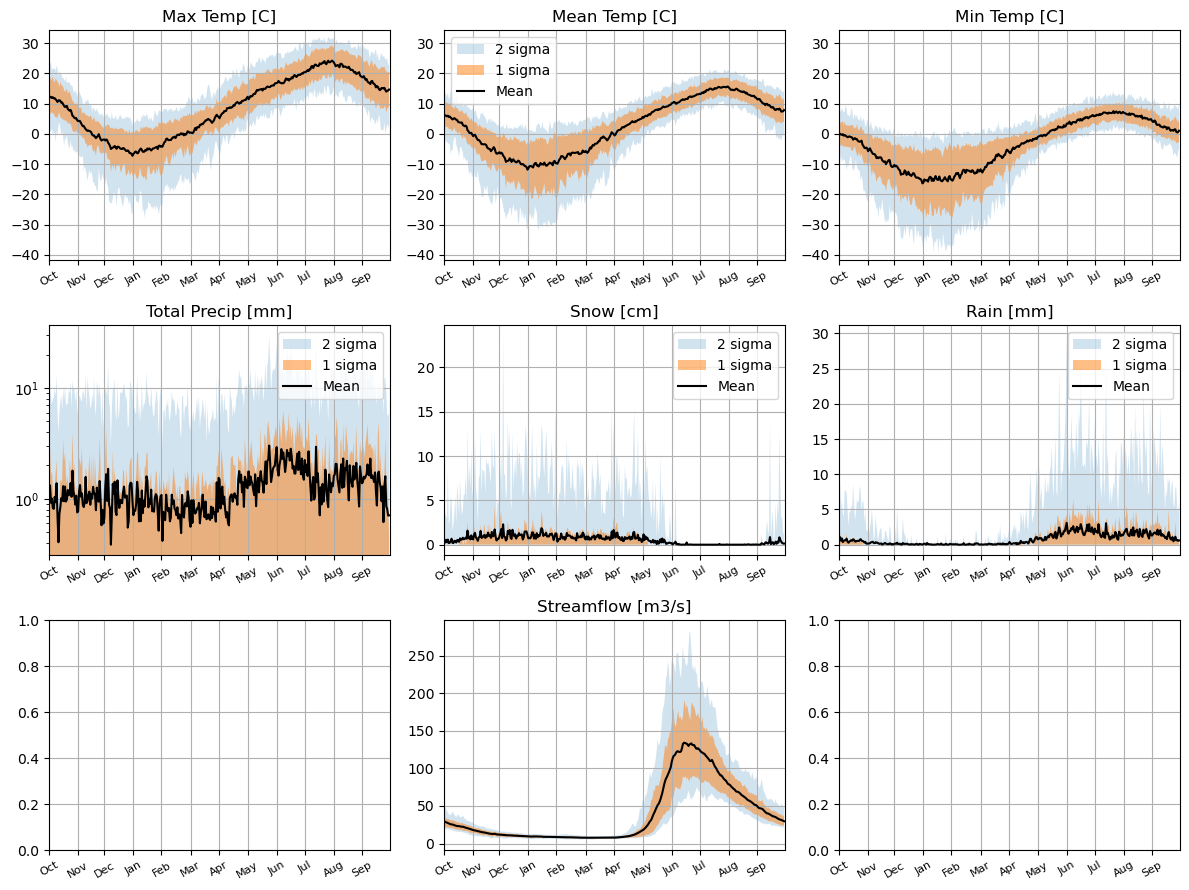

In [8]:
#visualize summary

saveIt = 0

site = 'Banff'
kk_site = sites.index(site)

nrows = 3
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

ax = axes[0,0]
ax.fill_between(x = np.arange(365), y1 = Tx_p1[kk_site,:], y2 = Tx_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Tx_p2[kk_site,:], y2 = Tx_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Tx_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Max Temp [C]')

ax = axes[0,1]
ax.fill_between(x = np.arange(365), y1 = Tmean_p1[kk_site,:], y2 = Tmean_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Tmean_p2[kk_site,:], y2 = Tmean_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Tmean_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Mean Temp [C]')
ax.legend()

ax = axes[0,2]
ax.fill_between(x = np.arange(365), y1 = Tn_p1[kk_site,:], y2 = Tn_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Tn_p2[kk_site,:], y2 = Tn_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Tn_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Min Temp [C]')
# ax.legend()

ax = axes[1,0]
ax.fill_between(x = np.arange(365), y1 = P_p1[kk_site,:], y2 = P_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = P_p2[kk_site,:], y2 = P_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(P_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_yscale('log')
ax.set_title('Total Precip [mm]')
ax.legend()

ax = axes[1,1]
ax.fill_between(x = np.arange(365), y1 = Psnow_p1[kk_site,:], y2 = Psnow_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Psnow_p2[kk_site,:], y2 = Psnow_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Psnow_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Snow [cm]')
ax.legend()

ax = axes[1,2]
ax.fill_between(x = np.arange(365), y1 = Prain_p1[kk_site,:], y2 = Prain_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Prain_p2[kk_site,:], y2 = Prain_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Prain_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Rain [mm]')
ax.legend()

ax = axes[2,1]
ax.fill_between(x = np.arange(365), y1 = Q_p1[kk_site,:], y2 = Q_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Q_p2[kk_site,:], y2 = Q_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Q_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Streamflow [m3/s]')

for ax in axes[0,:]:
    ax.set_ylim(top = np.nanmax(Tx_p4[kk_site]) + 2, bottom = np.nanmin(Tn_p1[kk_site]) - 2)

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 30, fontsize = 8)
    
plt.tight_layout()

if saveIt:
    plt.savefig('climate_summary.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

In [9]:
#calculate cumulative values

Pcumulative = [np.zeros((Nyears,365)) for Nyears in Nyears_sites] #2-dimensional arrays for each site; in each site, rows are years and columns are day of year
Psnowcumulative = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qcumulative = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qcumulative_filled = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qyearly = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qyearly_filled = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
N_missing_streamflow = [np.zeros(Nyears) for Nyears in Nyears_sites]
N_missing_temp = [np.zeros(Nyears) for Nyears in Nyears_sites]
N_missing_snow = [np.zeros(Nyears) for Nyears in Nyears_sites]
N_missing_precip = [np.zeros(Nyears) for Nyears in Nyears_sites]
precip_on_missing_snow_days = [np.zeros(Nyears) for Nyears in Nyears_sites]

for kk_site, site in enumerate(sites): #for each site

    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]
    data_start_year = df_sites['Year_start'][site]
    Q = df_flow['Value']
    P = df_weather['Total Precip (mm)']
    Psnow = df_weather['Total Snow (cm)']
    
    #fill missing values in Q
    for year in range(0,Nyears):

        day_oct1 = np.argwhere(
            (df_weather.index.year == data_start_year + year) & 
            (df_weather.index.month == 10) & 
            (df_weather.index.day == 1)
        ).squeeze()

        Qyearly[kk_site][year,:] = Q.values[day_oct1:day_oct1 + 365]
        Qcumulative[kk_site][year,:] = np.nancumsum(Q.values[day_oct1:day_oct1 + 365])

    Qyearly_filled[kk_site] = np.copy(Qyearly[kk_site])
    for year in range(Nyears):
        naninds = np.argwhere(np.isnan(Qyearly[kk_site][year,:])).squeeze()
        N_missing_streamflow[kk_site][year] = np.size(naninds)
        if np.size(naninds) < 365: #if entire year isn't missing
            Qyearly_filled[kk_site][year,naninds] = np.nanmean(Qyearly[kk_site], axis = 0)[naninds]
        else: #if entire year is missing
            Qyearly_filled[kk_site][year,:] = np.nan

    #calculate cumulative yearly values
    for year in range(0,Nyears):

        day_oct1 = np.argwhere(
            (df_weather.index.year == data_start_year + year) & 
            (df_weather.index.month == 10) & 
            # (df_weather.index.month == 1) & 
            (df_weather.index.day == 1)
        ).squeeze()

        Pcumulative[kk_site][year,:] = np.nancumsum(P.values[day_oct1:day_oct1 + 365])
        Psnowcumulative[kk_site][year,:] = np.nancumsum(Psnow.values[day_oct1:day_oct1 + 365])
        Qcumulative_filled[kk_site][year,:] = np.nancumsum(Qyearly_filled[kk_site][year,:])
        Qcumulative_filled[kk_site][year,:] = np.cumsum(Qyearly_filled[kk_site][year,:])
        Qyearly[kk_site][year,:] = Q.values[day_oct1:day_oct1 + 365]
        N_missing_temp[kk_site][year] = np.size(np.argwhere(df_weather['Mean Temp Flag'].values[day_oct1:day_oct1 + 365]=='M').squeeze())
        N_missing_snow[kk_site][year] = np.size(np.argwhere(df_weather['Total Snow Flag'].values[day_oct1:day_oct1 + 365]=='M').squeeze())
        N_missing_precip[kk_site][year] = np.size(np.argwhere(df_weather['Total Precip Flag'].values[day_oct1:day_oct1 + 365]=='M').squeeze())
        precip_on_missing_snow_days[kk_site][year] = np.nansum(P.values[day_oct1:day_oct1 + 365][np.argwhere(df_weather['Total Snow Flag'].values[day_oct1:day_oct1 + 365]=='M').squeeze()])
    
Psnowcumulative_june1 = np.array([Psnowcumulative[kk_site][:,first_days_of_month[8]] for kk_site in range(Nsites)])

In [10]:
kk_site = 4
N_missing_temp[kk_site], N_missing_snow[kk_site], N_missing_precip[kk_site], precip_on_missing_snow_days[kk_site]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        30.,  3.,  0.,  0.,  0.,  0.,  0.,  3.,  4., 17.,  9.,  1.,  4.,
         0.,  0.,  0., 32., 17.,  6., 33., 87., 42., 10.,  5.,  0.,  0.,
         3.,  0.,  3.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,
         5.,  0.,  0.,  2.,  3.,  1., 28.,  4.,  7.,  7.,  1.,  7.,  4.,
         3., 41., 12.,  6.,  5.,  6.]),
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
      

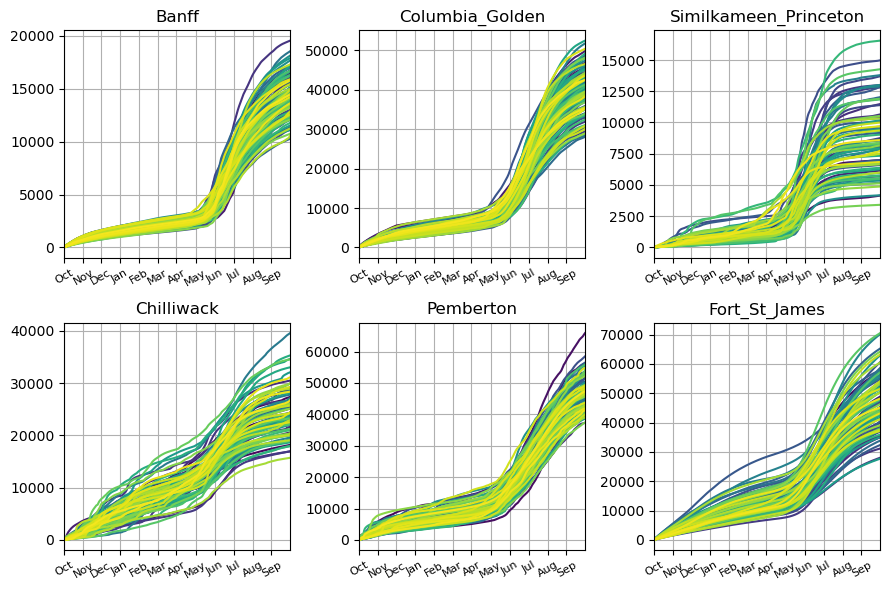

In [11]:
#visualize: cumulative flow for each year at each site

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 30, fontsize = 8)

for kk_site, site in enumerate(sites):
    
    ax = axes.flatten()[kk_site]
    
    for year in range (Nyears_sites[kk_site]-1):

        color = matplotlib.cm.get_cmap('viridis')(year / Nyears_sites[kk_site])
        ax.plot(Qcumulative_filled[kk_site][year,:], color = color)
    ax.set_title(site)
    
plt.tight_layout()

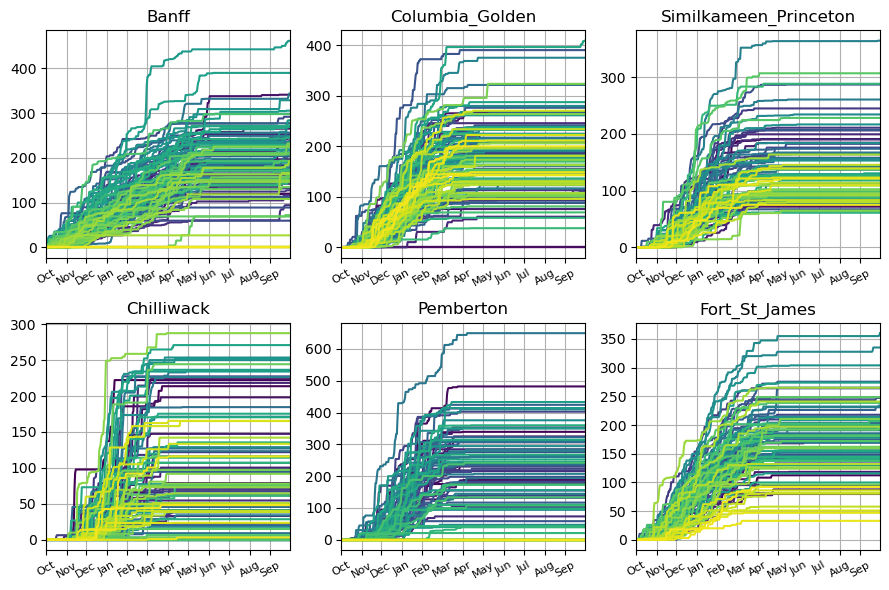

In [12]:
#visualize: cumulative snow precip for each year at each site

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 30, fontsize = 8)

for kk_site, site in enumerate(sites):
    
    ax = axes.flatten()[kk_site]
    
    for year in range (Nyears_sites[kk_site]-1):

        color = matplotlib.cm.get_cmap('viridis')(year / Nyears_sites[kk_site])
        ax.plot(Psnowcumulative[kk_site][year,:], color = color)
    ax.set_title(site)
    
plt.tight_layout()

# Year categorization

In [13]:
#in this section, we will determine the baseline and future proxy years for each site

In [14]:
#calculate freshet day (when Qcum threshold reached) for each site

threshold_fraction = 0.25
# threshold_fraction = 0.2

freshet_threshold_sites = np.array([threshold_fraction*np.nanmedian(Qcumulative_filled[kk_site][:,-1]) for kk_site in range(Nsites)]) #freshet threshold for each site

freshet_threshold_sites = np.array([threshold_fraction*np.nanmedian(Qcumulative_filled[kk_site][:,-1]-Qcumulative_filled[kk_site][:,183]) for kk_site in range(Nsites)]) #freshet threshold for each site

freshet_day = [np.zeros(Nyears) for Nyears in Nyears_sites] #day that freshet threshold is cross for each year at each site 
years_future_proxy = [] #list of future proxy years (will be filled)
years_baseline = [] #list of baseline years (will be filled)
years = [] #list of all years (will be filled)

for kk_site, site in enumerate(sites): #for each site

    freshet_threshold = freshet_threshold_sites[kk_site]
    Nyears = Nyears_sites[kk_site]
    
    for year in range(len(Qcumulative_filled[kk_site][:,0])): #for each year
        var = Qcumulative_filled[kk_site][year,:] - Qcumulative_filled[kk_site][year,183] #relative to April 1, so we are not considering variability from baseflow/rain in autumn/winter
        if np.size(np.argwhere(var<freshet_threshold)) > 0:
            freshet_day[kk_site][year] = np.max(np.argwhere(var<freshet_threshold))
        else:
            freshet_day[kk_site][year] = np.nan
    
#categorize years by freshet timing AND cumulative snowfall, rather than freshet timing alone
#initialize
years_early_dry = []
years_late_wet = []

years_early_wet = []
years_late_dry = []

for kk_site in range(Nsites): #for each site

    var1 = freshet_day[kk_site]
    var2 = Psnowcumulative_june1[kk_site]

    early_dry = np.argwhere(
        (var1 < np.nanmean(var1)) & 
        (var2 < np.nanmean(var2[var2>0])) & 
        (var2 > 0) & 
        (N_missing_snow[kk_site]<30)
    ).squeeze() #years where freshet is earlier than average and snow is less than average (note: ignore years without snow data, i.e. var2=0)

    late_wet = np.argwhere(
        (var1 > np.nanmean(var1)) & 
        (var2 > np.nanmean(var2[var2>0])) & 
        (N_missing_snow[kk_site]<30)
    ).squeeze() #years where freshet is later than average and snow is more than average
    
    early_wet = np.argwhere(
        (var1 < np.nanmean(var1)) & 
        (var2 > np.nanmean(var2[var2>0])) & 
        (var2 > 0) & 
        (N_missing_snow[kk_site]<30)
    ).squeeze() #years where freshet is earlier than average and snow is more than average

    late_dry = np.argwhere(
        (var1 > np.nanmean(var1)) & 
        (var2 < np.nanmean(var2[var2>0])) & 
        (var2 > 0) & 
        (N_missing_snow[kk_site]<30)
    ).squeeze() #years where freshet is later than average and snow is less than average
    
    years_early_dry.append(early_dry)
    years_late_wet.append(late_wet)
    
    years_early_wet.append(early_wet)
    years_late_dry.append(late_dry)
    
    print(sites[kk_site] + ':')
    print('\t# early/dry years: ' + str(len(early_dry)))
    print('\t# late/wet years:  ' + str(len(late_wet)))
    print('\t# early/wet years: ' + str(len(early_wet)))
    print('\t# late/dry years:  ' + str(len(late_dry)))

years_future_proxy = years_early_dry
years_baseline = years_late_wet

Nyears_future_proxy = np.array([len(yy) for yy in years_early_dry])
Nyears_baseline = np.array([len(yy) for yy in years_late_wet])

year_vecs = [np.arange(data_start_years[kk], data_start_years[kk] + Nyears_sites[kk]) + 1 for kk in range(6)] #time series of years for each site

Banff:
	# early/dry years: 29
	# late/wet years:  23
	# early/wet years: 22
	# late/dry years:  23
Columbia_Golden:
	# early/dry years: 21
	# late/wet years:  23
	# early/wet years: 32
	# late/dry years:  35
Similkameen_Princeton:
	# early/dry years: 22
	# late/wet years:  16
	# early/wet years: 17
	# late/dry years:  23
Chilliwack:
	# early/dry years: 19
	# late/wet years:  13
	# early/wet years: 22
	# late/dry years:  25
Pemberton:
	# early/dry years: 14
	# late/wet years:  17
	# early/wet years: 18
	# late/dry years:  21
Fort_St_James:
	# early/dry years: 14
	# late/wet years:  15
	# early/wet years: 30
	# late/dry years:  24


In [15]:
kk_site = 5
N_missing_snow[kk_site][years_future_proxy[kk_site]]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29., 26.,
       16.])

In [16]:
kk_site = 5
N_missing_streamflow[kk_site][years_baseline[kk_site]], N_missing_streamflow[kk_site][years_future_proxy[kk_site]]

(array([ 0., 99.,  0.,  0., 34., 52.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 array([334., 258.,  87.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]))

RESULTS OF MANUAL INVESTIGATION OF MISSING STREAMFLOW DATA IN BASELINE AND FUTURE PROXY YEARS

Number of missing streamflow days in years where missing data prevents freshet timing consideration

273 in kk_site = 1, future proxy, index 5  
202 in kk_site = 2, future proxy, index 0   
334 in kk_site = 5, future proxy, index 0  
258 in kk_site = 5, future proxy, index 1  

In [19]:
#remove baseline/future proxy years in which missing streamflow data hinders freshet analysis

years_future_proxy[1] = np.concatenate([years_future_proxy[1][0:5], years_future_proxy[1][6:]])
years_future_proxy[2] = years_future_proxy[2][1:]
years_future_proxy[5] = years_future_proxy[5][2:]

In [20]:
for kk_site in range(Nsites):
    print(sites[kk_site] + ':')
    print('\t# baseline years:\t ' + str(len(years_baseline[kk_site])))
    print('\t# future proxy years:\t ' + str(len(years_future_proxy[kk_site])))

Banff:
	# baseline years:	 23
	# future proxy years:	 29
Columbia_Golden:
	# baseline years:	 23
	# future proxy years:	 20
Similkameen_Princeton:
	# baseline years:	 16
	# future proxy years:	 21
Chilliwack:
	# baseline years:	 13
	# future proxy years:	 19
Pemberton:
	# baseline years:	 17
	# future proxy years:	 14
Fort_St_James:
	# baseline years:	 15
	# future proxy years:	 12


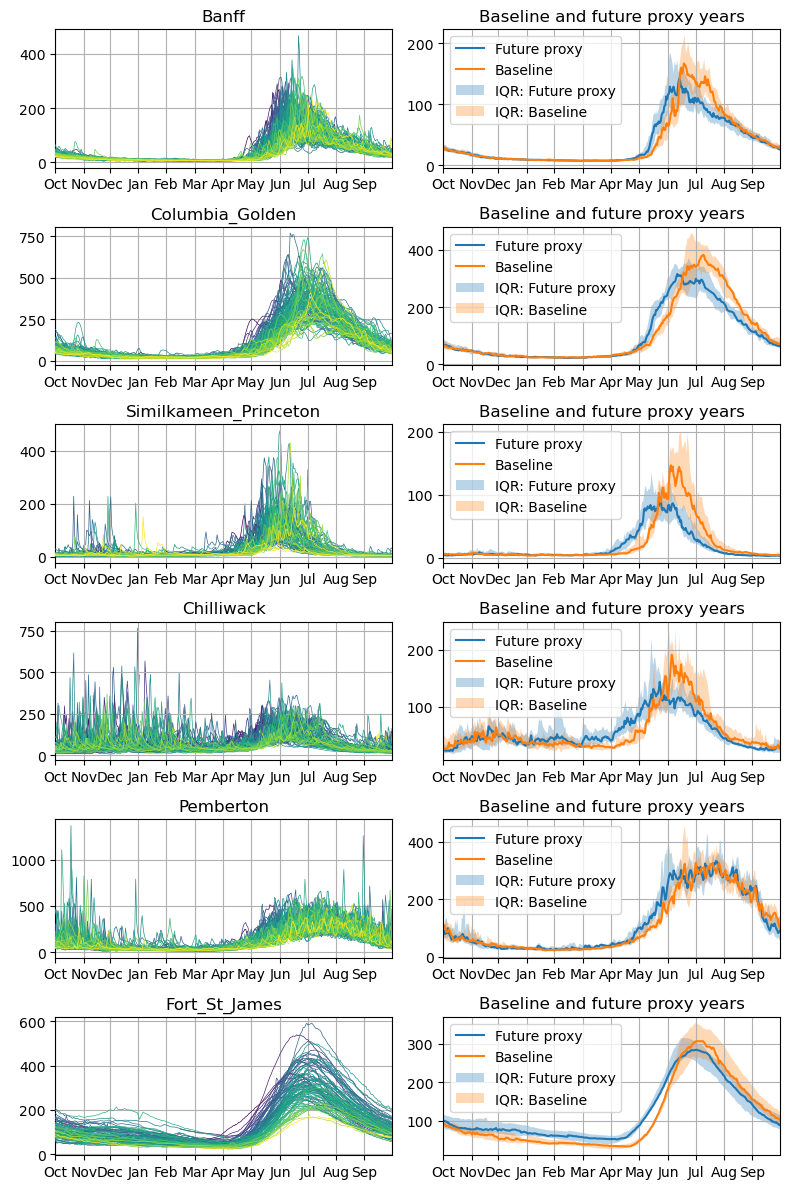

In [22]:
#visualize streamflow of individual years, and of baseline/future proxy years for each site

saveIt = 0

nrows = Nsites
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

for kk_site, site in enumerate(sites): #for each site
    
    #plot each year individually, coloured by freshet timing
    for year in range (Nyears_sites[kk_site] - 1):

        #color by freshet timing
        vmax = np.nanmax(freshet_day[kk_site])
        vmin = np.nanmin(freshet_day[kk_site])
        color = matplotlib.cm.get_cmap('viridis')( (freshet_day[kk_site][year] - vmin)/(vmax-vmin) )
        axes[kk_site,0].plot(Qyearly[kk_site][year,:], color = color, linewidth = 0.5, zorder = freshet_day[kk_site][year])

    #plot average of baseline and future proxy years
    axes[kk_site,1].plot(np.nanmedian(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0), label = 'Future proxy')
    axes[kk_site,1].plot(np.nanmedian(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0), label = 'Baseline')

    #plot IQR of baseline and future proxy years
    p1 = 25
    p2 = 75
    y1 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p1, axis = 0)
    y2 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p2, axis = 0)
    y3 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p1, axis = 0)
    y4 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p2, axis = 0)
    axes[kk_site,1].fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR: Future proxy')
    axes[kk_site,1].fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR: Baseline')

    axes[kk_site,0].set_title(site)
    axes[kk_site,1].set_title('Baseline and future proxy years')
    axes[kk_site,1].legend()
    
plt.tight_layout()

if saveIt:
    plt.savefig('streamflow_by_year_classes_freshet_snow.png', dpi = 300, bbox_inches = 'tight')

plt.show()

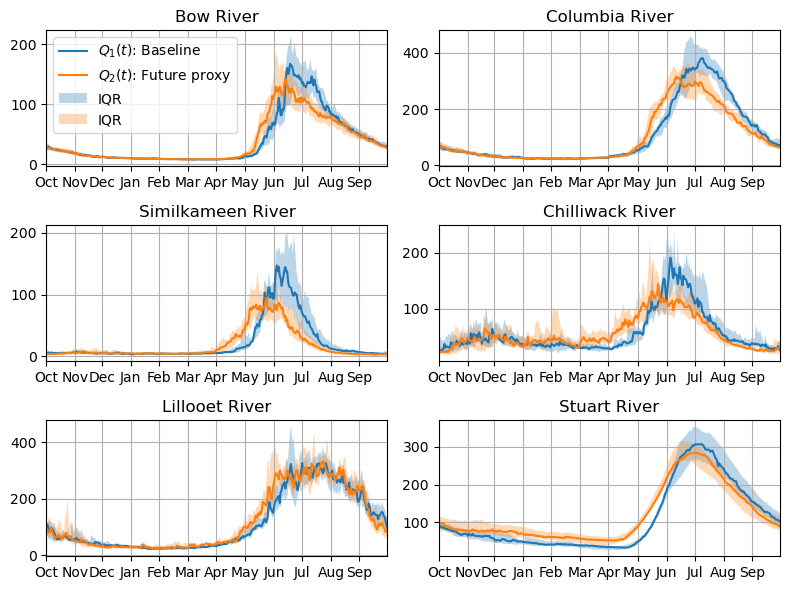

In [23]:
#visualize baseline/future proxy years for each site

saveIt = 0

nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

for kk_site, ax in enumerate(axes.flatten()): #for each site
    
    ax.set_title(sites_short[kk_site])

    #plot average of baseline and future proxy years
    ax.plot(np.nanmedian(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0), label = '$Q_1(t)$: Baseline')
    ax.plot(np.nanmedian(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0), label = '$Q_2(t)$: Future proxy')

    #plot IQR of baseline and future proxy years
    p1 = 25
    p2 = 75
    y1 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p1, axis = 0)
    y2 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p2, axis = 0)
    y3 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p1, axis = 0)
    y4 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p2, axis = 0)
    ax.fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR')
    ax.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR')

axes[0,0].legend()
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/streamflow_regimes.png', dpi = 300, bbox_inches = 'tight')

plt.show()

# Study region figure

In [26]:
#OPTIONAL FOR PLOTTING: load basin data
#basin polygons can be downloaded from: https://collaboration.cmc.ec.gc.ca/cmc/hydrometrics/www/HydrometricNetworkBasinPolygons/

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle' #filename of pickle file which contains the basin outlines
pickle_in = open('./Data/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)
basin_inds = [157, 51, 121, 82, 80, 88]


In [28]:
#load DEM of region and characterize study basins

mosaic = rasterio.open('./Data/AB_BC_mosaic.tif') #tif file of DEM
dem = mosaic.read(1)
dem = np.array(dem, dtype = np.float32)
dem[dem<0] = 0 #set missing data (eg ocean/glacier) to 0

minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]

demLon_highres = np.linspace(minlon,maxlon,15601)
demLat_highres = np.linspace(minlat,maxlat,20401)

In [30]:
#make hillshade
nn = 2000 #number of pixels to interpolate to
# nn = 10000
res = cv2.resize(dem, dsize=(nn, nn), interpolation=cv2.INTER_LINEAR) #resize to smaller dimensions
demLon = np.linspace(minlon,maxlon,nn)
demLat = np.linspace(minlat,maxlat,nn)
hs_array = hillshade(res,315,360) #hillshade
demLat = np.flipud(demLat.reshape(-1,1)).squeeze()

In [31]:
#open RGI data and extract area/locations
rgi_dir = './Data/'
poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(rgi_dir + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']


In [33]:
#use dem to calculate basin outlet elevation
#note: set nn > 2000 for higher resolution; or don't resize dem to smaller dimensions

# for kk_site in range(6):
#     site_lon = df_sites['Longitude'][kk_site] #stream gauge lon
#     site_lat = df_sites['Latitude'][kk_site] #stream gauge lat
    
#     argLon = np.argmin(np.abs(demLon - site_lon))
#     argLat = np.argmin(np.abs(demLat - site_lat))
    
#     print(res[argLat,argLon])

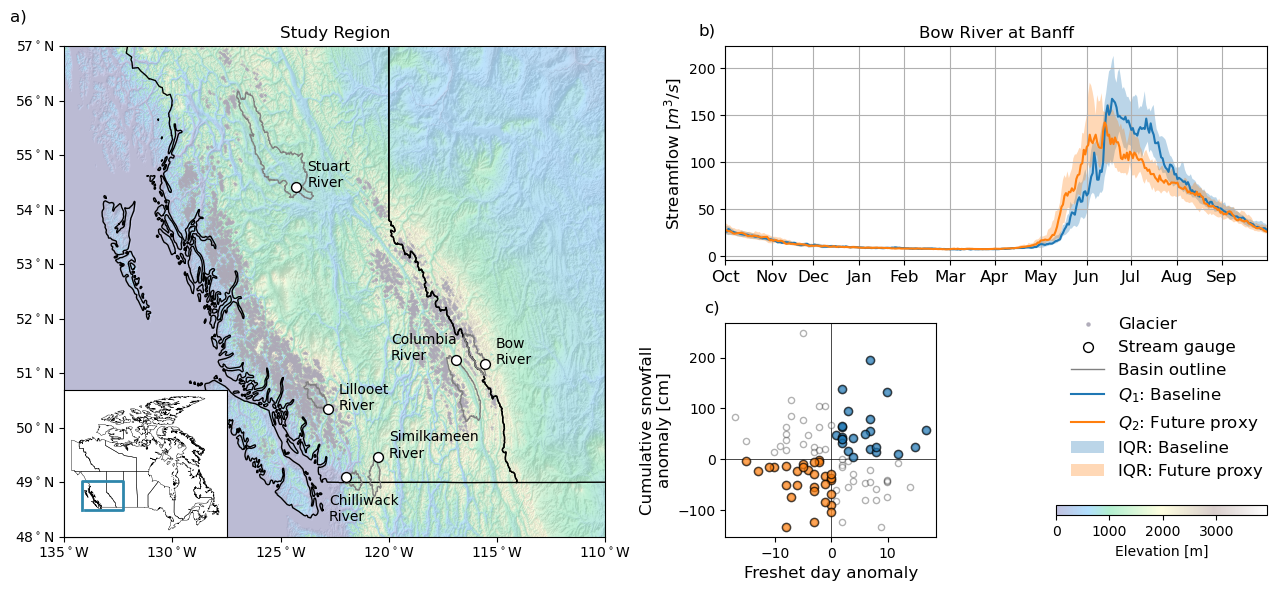

In [34]:
#visualize study region: year categorization in terms of anomaly

saveIt = 0

fs = 12

nrows = 4
ncols = 4
fig = plt.figure(figsize = (3.2*ncols, 1.5*nrows))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

ax_map = fig.add_subplot(gs[:,:-2])
ax_banff = fig.add_subplot(gs[:2,-2:])
ax_years = fig.add_subplot(gs[2:,-2])
ax_legend = fig.add_subplot(gs[2:,-1])

##### INSET
rgb_bb = np.array([46, 134, 171]) / 255
canada_east = -108
canada_west = -142
canada_north = 60
canada_south = 46
ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax_map, [0,0,0.3,0.3])
ax_inset.set_axes_locator(ip)
plot_prov_ax(prov = 'all', ax = ax_inset, linewidth = 0.3)

#bounding box
x = [-135,-135,-110,-110,-133]
y = [48,57,57,48,48]
ax_inset.plot(x,y, color = rgb_bb, linewidth = 2)
ax_inset.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
#####

##### MAP
topo = ax_map.imshow(res, aspect = 'auto', vmin = 0, alpha = 0.3, cmap = 'terrain', extent = extentDEM)
hill = ax_map.imshow(hs_array, aspect = 'auto', alpha = 0.15, cmap = 'Greys', extent = extentDEM)
plot_prov_ax(prov=prov, ax = ax_map)
cc = np.array([173, 169, 183]) / 255
ax_map.scatter(cenLon[cenLat>49],cenLat[cenLat>49], color=cc, s = 0.15, alpha = 0.9) #glaciers in figure
ax_map.scatter(0,0, color=cc, s = 5, alpha = 0.9, label = 'Glacier') #for legend
ax_map.scatter(df_sites['Longitude'],df_sites['Latitude'], color='w', s = 50, linewidth = 1, edgecolor = 'k', zorder = 3, label = 'Stream gauge')

ax_map.tick_params(labelsize = fs-2)
ax_map.set_title('Study Region', fontsize = fs)
ax_map.set_ylim(bottom = 48, top = 57)
ax_map.set_xlim(left = -135, right = -110)

#basins
jj = 0
for kk,basin in enumerate([stationBasins[ind] for ind in basin_inds]):
  if basin is not None:
    jj+=1
    x,y = basin.exterior.xy
    #label
    if jj == 1:
      ax_map.plot(x, y, color = 'gray', linewidth = 1, label = 'Basin outline') #label for legend
    else:
      ax_map.plot(x, y, color = 'gray', linewidth = 1)

ax_map.text(x = -0.1, y = 1.05, s = abc[0], transform = ax_map.transAxes, fontsize = fs)
ax_map.tick_params(labelsize = fs-2)


##### BANFF FLOW

kk_site = 0 #banff

#plot median and IQR of baseline and future proxy years
p1 = 25
p2 = 75
y1 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p1, axis = 0)
y2 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p2, axis = 0)
y3 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p1, axis = 0)
y4 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p2, axis = 0)
ax_banff.plot(np.nanmedian(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0), label = '$Q_1$: Baseline')
ax_banff.plot(np.nanmedian(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0), label = '$Q_2$: Future proxy')
ax_banff.fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR: Baseline')
ax_banff.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR: Future proxy')

ax_banff.set_title('Bow River at Banff', fontsize = fs)
ax_banff.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax_banff.tick_params(labelsize = fs-2)
ax_banff.text(x = -0.05, y = 1.05, s = abc[1], transform = ax_banff.transAxes, fontsize = fs)


##### freshet timing vs cumulative snowfall
freshet_day_mean = np.array([np.nanmean(freshet_day[kk_site]) for kk_site in range(Nsites)])
var = Psnowcumulative_june1
Psnowcumulative_june1_mean = np.array([np.nanmean(var[kk_site][var[kk_site]>0]) for kk_site in range(Nsites)])

inds = np.argwhere(
    (var[kk_site] > 0) & 
    (N_missing_snow[kk_site] < 30)
).squeeze() 

ax_years.scatter(freshet_day[kk_site][inds]-freshet_day_mean[kk_site], 
                 Psnowcumulative_june1[kk_site][inds]-Psnowcumulative_june1_mean[kk_site], 
                 s = 20, facecolor = 'w', edgecolor = 'k', alpha = 0.3) #all
ax_years.scatter(freshet_day[kk_site][years_baseline[kk_site]]-freshet_day_mean[kk_site], 
                 Psnowcumulative_june1[kk_site][years_baseline[kk_site]]-Psnowcumulative_june1_mean[kk_site], 
                 edgecolor = 'k', alpha = 0.7) #baseline years
ax_years.scatter(freshet_day[kk_site][years_future_proxy[kk_site]]-freshet_day_mean[kk_site], 
                 Psnowcumulative_june1[kk_site][years_future_proxy[kk_site]]-Psnowcumulative_june1_mean[kk_site], 
                 edgecolor = 'k', alpha = 0.7) #future proxy years

ax_years.axhline(0, color = 'k', linewidth = 0.5, zorder = 0)
ax_years.axvline(0, color = 'k', linewidth = 0.5, zorder = 0)

ax_years.set_xlabel('Freshet day anomaly', fontsize = fs)
ax_years.set_ylabel('Cumulative snowfall\nanomaly [cm]', fontsize = fs)
ax_years.tick_params(labelsize = fs-2)
ax_years.text(x = -0.1, y = 1.05, s = abc[2], transform = ax_years.transAxes, fontsize = fs)


#### FIGURE FORMATTING

#legend
h0, l0 = ax_map.get_legend_handles_labels()
h1, l1 = ax_banff.get_legend_handles_labels()
h2, l2 = ax_years.get_legend_handles_labels()
labels = l0+l1+l2
handles = h0+h1+h2
ax_legend.legend(handles, labels, fontsize = fs, frameon = False, loc = 'center left')
ax_legend.axis('off')

#ticks/etc
for ax in [ax_banff]:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0, fontsize = fs)
    
#colourbar
cbar = plt.colorbar(topo, ax = ax_legend, orientation='horizontal')
cbar.ax.set_xlabel('Elevation [m]', fontsize = fs-2)

plt.tight_layout()

#edit ticklabels
xtls = [item.get_text()[1:] + '$^\circ$W' for item in ax_map.get_xticklabels()]
ax_map.set_xticklabels(xtls)
ytls = [item.get_text() + '$^\circ$N' for item in ax_map.get_yticklabels()]
ax_map.set_yticklabels(ytls)

#add station labels
ax_map.text(x = df_sites['Longitude'][0]+0.5, y = df_sites['Latitude'][0], s = sites_short[0][:-6]+'\nRiver')
ax_map.text(x = df_sites['Longitude'][1]-3, y = df_sites['Latitude'][1], s = sites_short[1][:-6]+'\nRiver')
ax_map.text(x = df_sites['Longitude'][2]+0.5, y = df_sites['Latitude'][2], s = sites_short[2][:-6]+'\nRiver')
ax_map.text(x = df_sites['Longitude'][3]+0.5, y = df_sites['Latitude'][3], s = sites_short[4][:-6]+'\nRiver')
ax_map.text(x = df_sites['Longitude'][4]+0.5, y = df_sites['Latitude'][4], s = sites_short[5][:-6]+'\nRiver')
ax_map.text(x = df_sites['Longitude'][5]-0.8, y = df_sites['Latitude'][5]-0.8, s = sites_short[3][:-6]+'\nRiver')

    
if saveIt:
    plt.savefig('Figures/study_region2.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [35]:
basin_lat = df_sites['Latitude']
basin_lon = df_sites['Longitude']

ws_lat = [df_site['Latitude (y)'].iloc[0] for df_site in df_sites['Weather_stations']]
ws_lon = [df_site['Longitude (x)'].iloc[0] for df_site in df_sites['Weather_stations']]

In [36]:
#if wanting to make high-resolution figures of study basins for supplementary info; uncomment this cell and run
#the difference with the prior resized dem is only the resolution

# #make hillshade
# nn = 5000
# # nn = 10000
# res = cv2.resize(dem, dsize=(nn, nn), interpolation=cv2.INTER_LINEAR) #resize to smaller dimensions
# # res = dem
# demLon = np.linspace(minlon,maxlon,nn)
# demLat = np.linspace(minlat,maxlat,nn)
# hs_array = hillshade(res,315,360) #hillshade
# demLat = np.flipud(demLat.reshape(-1,1)).squeeze()

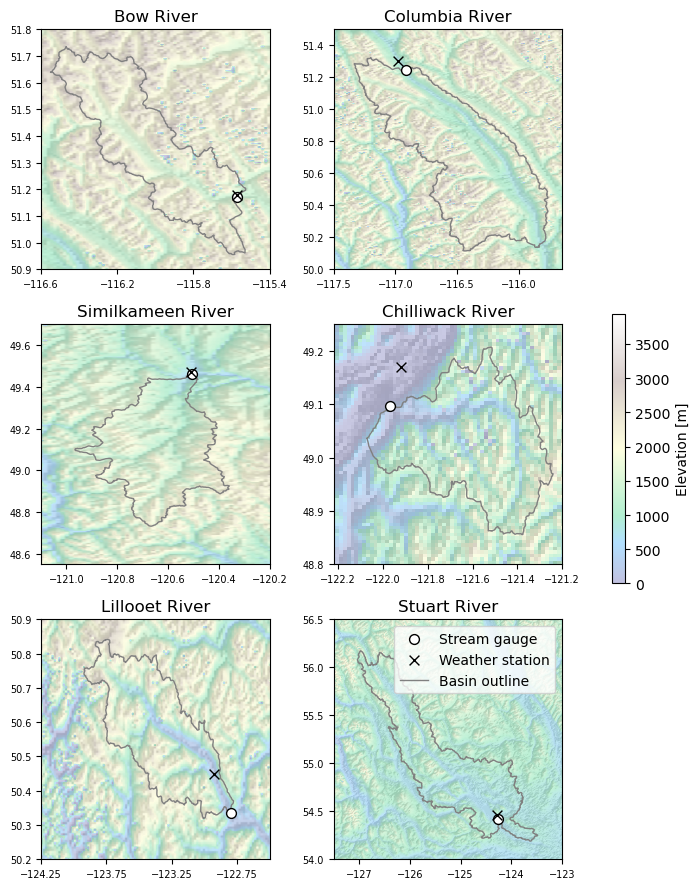

In [38]:
saveIt = 0

nrows = 3
ncols = 2

basin_order = [0,5,2,3,4,1]

bottoms = [50.9,   50,   48.55, 48.8, 50.2,   54]
tops =    [51.8,   51.5, 49.7,   49.25, 50.9,   56.5]
lefts =   [-116.6, -117.5,   -121.1, -122.22, -124.25, -127.5]
rights =  [-115.45, -115.65,   -120.2,   -121.2, -122.5, -123]

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for kk_ax, ax in enumerate(axes.flatten()):

    topo = ax.imshow(res, aspect = 'auto', vmin = 0, alpha = 0.3, cmap = 'terrain', extent = extentDEM)
    hill = ax.imshow(hs_array, aspect = 'auto', alpha = 0.15, cmap = 'Greys', extent = extentDEM)
    # plot_prov_ax(prov=prov, ax = ax)
    
    ax.scatter(basin_lon, basin_lat, color='w', s = 50, linewidth = 1, edgecolor = 'k', zorder = 3, label = 'Stream gauge')
    ax.scatter(ws_lon, ws_lat, marker = 'x', s = 50, linewidth = 1, color = 'k', zorder = 3, label = 'Weather station')

    #basins
    jj = 0
    for kk,basin in enumerate([stationBasins[ind] for ind in [basin_inds[basin_order[kk_ax]]]]):
        if basin is not None:
            jj+=1
            x,y = basin.exterior.xy
            #label
            if jj == 1:
                ax.plot(x, y, color = 'gray', linewidth = 1, label = 'Basin outline') #label for legend
            else:
                ax.plot(x, y, color = 'gray', linewidth = 1)
        
    #FORMATTING
    bottom = bottoms[kk_ax]
    top = tops[kk_ax]
    left = lefts[kk_ax]
    right = rights[kk_ax]
    ax.set_xlim(left = left, right = right)
    ax.set_ylim(bottom = bottom, top = top)
    ax.tick_params(labelsize = 7)
    
    ax.set_title(sites_short[kk_ax])
    
    if (kk_ax == 0) | (kk_ax == 4):
        ax.set_xticks(ax.get_xticks()[::2])
    
ax.legend()
        
plt.tight_layout()

#add colourbar to bottom subplot of each column
cbar_ax = fig.add_axes([0.9, 0.33, 0.15, 0.33])
cbar_ax.axis('off')
cb = fig.colorbar(topo, ax=cbar_ax,)
cb.ax.set_ylabel('Elevation [m]')

if saveIt:
    plt.savefig('Figures/Supplementary/ws_stream_gauge_detail2.png', dpi = 300, bbox_inches = 'tight')

Bow River at Banff elevation (https://hess.copernicus.org/articles/24/5953/2020/)  
Max: 3420  
Min: 1380  
Mean: 2130  
My method -- Min: 1385  
Banff WS elevation: 1383.7 (https://api.weather.gc.ca/collections/ahccd-stations/items/3050520?lang=en)  

Columbia SG elevation: 789  
Golden WS elevation: 784.9 (https://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=1364&autofwd=1)  

Similkameen SG elevation: 636  
Princeton WS elevation: 701.65 

Lillooet SG elevation: 217  
Pemberton Meadows WS elevation: 222.5  
Pemberton BCFS WS elevation: 218.2  
Pemberton Airport CS WS elevation: 204.31  

Stuart SG elevation: 681  
Fort St James WS elevation: 691  

Chilliwack SG elevation: 33  
Chilliwack WS elevation: 11  


In [39]:
ws_elevation = np.array([1383.7, 784.9, 701.65, 11, 204.31, 691])

In [ ]:
#make masks to determine weather station / basin data

mask_dem = np.zeros((Nsites,nn,nn))

for kk_basin,basin in enumerate([stationBasins[ind] for ind in basin_inds]):
    
    if basin is not None:
        
        x,y = basin.exterior.xy
    
        coords = [(x[kk],y[kk]) for kk in range(len(x))]
        poly = Polygon(coords)
        
        print(kk_basin)

        for kk_x in range(len(demLon)):
            if np.mod(kk_x,1000)==0:
                print('\t' + str(kk_x))
            for kk_y in range(len(demLat)):

                condition1 = (demLon[kk_x] >= np.min(x)) & (demLon[kk_x] <= np.max(x))
                condition2 = (demLat[kk_y] >= np.min(y)) & (demLat[kk_y] <= np.max(y))

                if condition1 & condition2:

                    point = Point(demLon[kk_x],demLat[kk_y])
                    if poly.contains(point):
                        mask_dem[kk_basin,kk_y,kk_x] = 1   

In [ ]:
for kk_site in range(Nsites):
    
    print(sites_short[kk_site])
    print('\tWeather station: {}'.format(str(np.round(ws_elevation[kk_site],decimals=0))))
    print('\tBasin median:    {}'.format(np.round(np.median(res[(mask_dem[basin_order[kk_site]]==1) & (res>ws_elevation[kk_site])]), decimals = 0)))


In [ ]:
basin_median_elevation = np.array([np.median(res[(mask_dem[basin_order[kk_ax]]==1) & (res>ws_elevation[kk_ax])]) for kk_ax in range(6)])
basin_min_elevation = np.array([np.min(res[(mask_dem[basin_order[kk_ax]]==1) & (res>ws_elevation[kk_ax])]) for kk_ax in range(6)])
basin_max_elevation = np.array([np.max(res[(mask_dem[basin_order[kk_ax]]==1) & (res>ws_elevation[kk_ax])]) for kk_ax in range(6)])

In [ ]:
print(ws_elevation)
print(basin_min_elevation)
print(basin_median_elevation)
print(basin_max_elevation)

In [ ]:
saveIt = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for kk_ax, ax in enumerate(axes.flatten()):
    
    color = matplotlib.cm.get_cmap('viridis')(kk_ax / (Nsites-1))
    
    h = ax.hist(res[(mask_dem[basin_order[kk_ax]]==1) & (res>ws_elevation[kk_ax])], edgecolor = 'k', facecolor = color, linewidth = 1, alpha = 0.6, label = 'Basin elevation')
    ax.plot([ws_elevation[kk_ax], ws_elevation[kk_ax]],[0, 1.05*np.max(h[0])], 'k--', label = 'Weather station', linewidth = 1)
    ax.plot([basin_median_elevation[kk_ax], basin_median_elevation[kk_ax]],[0, 1.05*np.max(h[0])], color = 'k', linestyle = '-', linewidth = 1, label = 'Basin median')
    
    ax.text(ws_elevation[kk_ax]-20, 1.06*np.max(h[0]), s = str(int(ws_elevation[kk_ax])), fontsize = 9)
    ax.text(basin_median_elevation[kk_ax]-20, 1.06*np.max(h[0]), s = str(int(basin_median_elevation[kk_ax])), fontsize = 9)

    
    # ax.hist(res)
        
    #FORMATTING
    ax.set_title(sites_short[kk_ax])
    if np.mod(kk_ax,2)==0:
        ax.set_ylabel('Count')
    if kk_ax>3:
        ax.set_xlabel('Elevation [m]')
    ax.set_ylim(top = 1.15*np.max(h[0]))
        
ax.legend(loc = 'center right')
        
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/ws_basin_elevation3.png', dpi = 300, bbox_inches = 'tight')

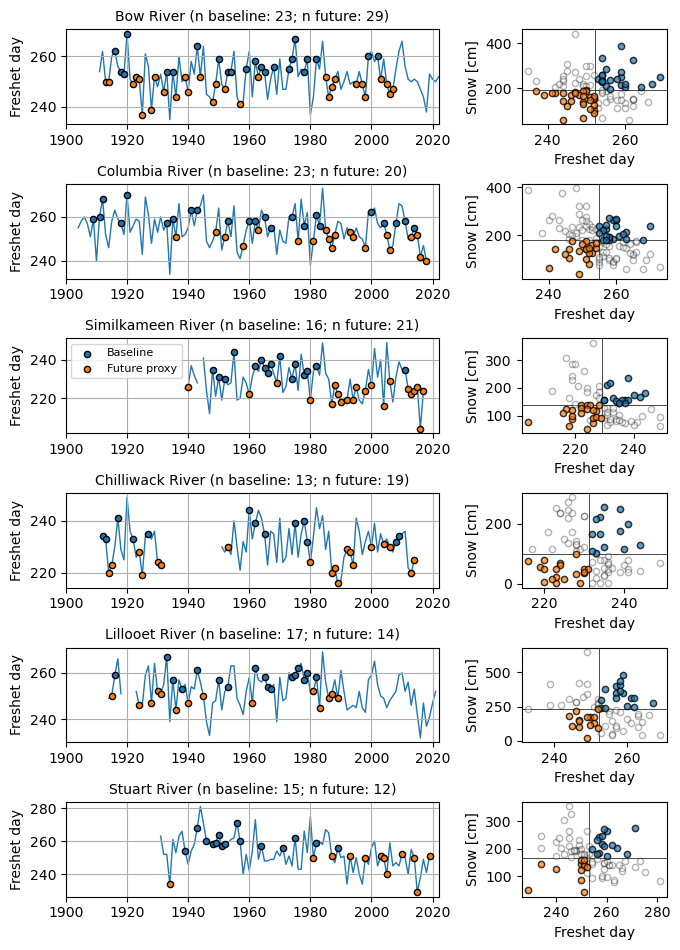

In [40]:
#visualize timing of baseline / future proxy years for each site

saveIt = 0

fs = 10

nrows = 6
ncols = 3
fig = plt.figure(figsize = (2.3*ncols, 1.6*nrows))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

for kk_site in range(Nsites): #for each site

    ax_timeseries = fig.add_subplot(gs[kk_site,:-1]) #timeseries of year categories
    ax_years = fig.add_subplot(gs[kk_site,-1]) #snow vs freshet timing 

    ##### timeseries
    ax_timeseries.plot(year_vecs[kk_site], freshet_day[kk_site], linewidth = 1, zorder = 0)
    ax_timeseries.scatter(year_vecs[kk_site][years_baseline[kk_site]], freshet_day[kk_site][years_baseline[kk_site]], s = 20, edgecolor = 'k', linewidth = 1, label = 'Baseline')
    ax_timeseries.scatter(year_vecs[kk_site][years_future_proxy[kk_site]], freshet_day[kk_site][years_future_proxy[kk_site]], s = 20, edgecolor = 'k', linewidth = 1, label = 'Future proxy')
    ax_timeseries.set_ylabel('Freshet day')
    ax_timeseries.set_title(sites_short[kk_site], fontsize = fs)
    ax_timeseries.set_xlim(left = 1900,right = 2022)
    ax_timeseries.grid(True)
    ax_timeseries.set_axisbelow(True)
    
    if kk_site == 2:
        ax_timeseries.legend(fontsize = fs-2)

    ##### freshet timing vs cumulative snowfall
    freshet_day_mean = np.array([np.nanmean(freshet_day[kk_site]) for kk_site in range(Nsites)])
    var = Psnowcumulative_june1
    Psnowcumulative_june1_mean = np.array([np.nanmean(var[kk_site][var[kk_site]>0]) for kk_site in range(Nsites)])
    inds = np.argwhere(
        (var[kk_site]>0) & 
        (N_missing_snow[kk_site] < 30)
    ).squeeze()

    ax_years.scatter(freshet_day[kk_site][inds], Psnowcumulative_june1[kk_site][inds], s = 20, facecolor = 'w', edgecolor = 'k', alpha = 0.3) #all
    ax_years.scatter(freshet_day[kk_site][years_baseline[kk_site]], Psnowcumulative_june1[kk_site][years_baseline[kk_site]], s = 20, edgecolor = 'k', alpha = 0.7) #baseline years
    ax_years.scatter(freshet_day[kk_site][years_future_proxy[kk_site]], Psnowcumulative_june1[kk_site][years_future_proxy[kk_site]], s = 20, edgecolor = 'k', alpha = 0.7) #future proxy years

    ax_years.set_xlabel('Freshet day', fontsize = fs)
    ax_years.set_ylabel('Snow [cm]', fontsize = fs)
    
    N_baseline = len(years_baseline[kk_site])
    N_future = len(years_future_proxy[kk_site])
    ax_timeseries.set_title(sites_short[kk_site] + ' (n baseline: ' + str(N_baseline) + '; n future: ' + str(N_future) + ')', fontsize = fs)
    
    ax_years.axhline(Psnowcumulative_june1_mean[kk_site], color = 'k', linewidth = 0.5, zorder = 0)
    ax_years.axvline(freshet_day_mean[kk_site], color = 'k', linewidth = 0.5, zorder = 0)
    
plt.tight_layout()
    
if saveIt:
    plt.savefig('Figures/Supplementary/baseline_future_years_viz.png', bbox_inches = 'tight', dpi = 300)

plt.show()

# Calculate climate of year categories

In [42]:
#initialize: cumulative vars
Qcumulative_future_proxy = np.zeros((Nsites,365))
Qcumulative_baseline = np.zeros((Nsites,365))
Pcumulative_future_proxy = np.zeros((Nsites,365))
Pcumulative_baseline = np.zeros((Nsites,365))
Psnowcumulative_future_proxy = np.zeros((Nsites,365))
Psnowcumulative_baseline = np.zeros((Nsites,365))

#initialize: mean temp
Tmean_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy] #yearly values for each future proxy year at each site
Tmean_baseline = [np.zeros(nn) for nn in Nyears_baseline] #yearly values for each baseline year at each site
Tmean_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy] #monthly values for each month in each future proxy year at each site
Tmean_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline] #monthly values for each month in each baseline year at each site
Tmean_monthly = [np.zeros((12,nn)) for nn in Nyears_sites] #monthly values for each month in each baseline year at each site

#initialize: max temp
Tmax_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy] #same form as above
Tmax_baseline = [np.zeros(nn) for nn in Nyears_baseline]
Tmax_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
Tmax_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]

#initialize: min temp
Tmin_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy]
Tmin_baseline = [np.zeros(nn) for nn in Nyears_baseline]
Tmin_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
Tmin_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]

#initialize: precip
P_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy]
P_baseline = [np.zeros(nn) for nn in Nyears_baseline]
P_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
P_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]
P_monthly = [np.zeros((12,nn)) for nn in Nyears_sites] #monthly values for each month in each baseline year at each site

for kk_site, site in enumerate(sites): #for each site
    
    df_weather = df_sites['Weather_stations'][site]
    year_start = df_sites['Year_start'][site] + 1 #plus 1 for first water year (eg Oct 1 19XX is water year 19XX+1)
    
    #cumulative flow
    Qcumulative_future_proxy[kk_site,:] = np.mean(Qcumulative_filled[kk_site][years_future_proxy[kk_site],:], axis = 0)
    Qcumulative_baseline[kk_site,:] = np.mean(Qcumulative_filled[kk_site][years_baseline[kk_site],:], axis = 0)

    #cumulative precip
    Pcumulative_future_proxy[kk_site,:] = np.mean(Pcumulative[kk_site][years_future_proxy[kk_site],:], axis = 0)
    Pcumulative_baseline[kk_site,:] = np.mean(Pcumulative[kk_site][years_baseline[kk_site],:], axis = 0)
    Psnowcumulative_future_proxy[kk_site,:] = np.mean(Psnowcumulative[kk_site][years_future_proxy[kk_site],:], axis = 0)
    Psnowcumulative_baseline[kk_site,:] = np.mean(Psnowcumulative[kk_site][years_baseline[kk_site],:], axis = 0)

    #mean temperature by year and month
    Tmean_future_proxy[kk_site] = np.array([np.mean(df_weather['Mean Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    Tmean_baseline[kk_site] = np.array([np.mean(df_weather['Mean Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    Tmean_future_proxy_monthly[kk_site] = np.array([np.array([np.nanmean(df_weather['Mean Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    Tmean_baseline_monthly[kk_site] = np.array([np.array([np.nanmean(df_weather['Mean Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])
    Tmean_monthly[kk_site] = np.array([np.array([np.nanmean(df_weather['Mean Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in year_vecs[kk_site] - year_vecs[kk_site][0]]) for month in range(12)])
    
    #max temperature by year and month
    Tmax_future_proxy[kk_site] = np.array([np.mean(df_weather['Max Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    Tmax_baseline[kk_site] = np.array([np.mean(df_weather['Max Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    Tmax_future_proxy_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Max Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    Tmax_baseline_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Max Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])

    #min temperature by year and month
    Tmin_future_proxy[kk_site] = np.array([np.mean(df_weather['Min Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    Tmin_baseline[kk_site] = np.array([np.mean(df_weather['Min Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    Tmin_future_proxy_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Min Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    Tmin_baseline_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Min Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])

    #precip by year and month
    P_future_proxy[kk_site] = np.array([np.nansum(df_weather['Total Precip (mm)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    P_baseline[kk_site] = np.array([np.nansum(df_weather['Total Precip (mm)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    P_future_proxy_monthly[kk_site] = np.array([np.array([np.nansum(df_weather['Total Precip (mm)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    P_baseline_monthly[kk_site] = np.array([np.array([np.nansum(df_weather['Total Precip (mm)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])
    P_monthly[kk_site] = np.array([np.array([np.nanmean(df_weather['Total Precip (mm)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in year_vecs[kk_site] - year_vecs[kk_site][0]]) for month in range(12)])


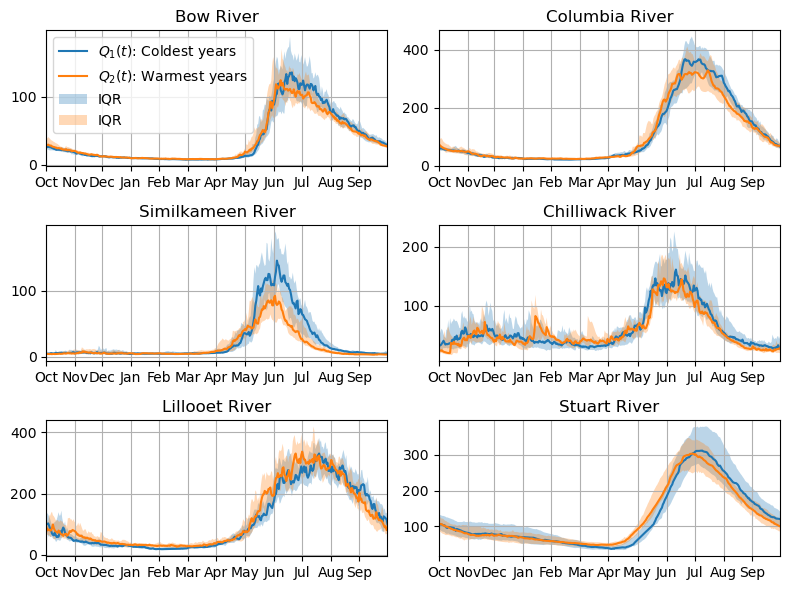

In [43]:
#visualize streamflow for each site between hottest / coldest years for each site
#note: this can be used to motivate the use of freshet timing / snowfall to develop future proxy vs baseline years

saveIt = 0

nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

for kk_site, ax in enumerate(axes.flatten()): #for each site
    
    Tmean_yearly = np.mean(Tmean_monthly[kk_site], axis = 0)
    coldest_years = np.argsort(Tmean_yearly)[:30]
    warmest_years = np.argsort(Tmean_yearly)[-30:]
    
    ax.set_title(sites_short[kk_site])

    #plot average of baseline and future proxy years
    ax.plot(np.nanmedian(Qyearly[kk_site][coldest_years,:],axis = 0), label = '$Q_1(t)$: Coldest years')
    ax.plot(np.nanmedian(Qyearly[kk_site][warmest_years,:],axis = 0), label = '$Q_2(t)$: Warmest years')

    #plot IQR of baseline and future proxy years
    p1 = 25
    p2 = 75
    y1 = np.nanpercentile(Qyearly[kk_site][warmest_years,:], q = p1, axis = 0)
    y2 = np.nanpercentile(Qyearly[kk_site][warmest_years,:], q = p2, axis = 0)
    y3 = np.nanpercentile(Qyearly[kk_site][coldest_years,:], q = p1, axis = 0)
    y4 = np.nanpercentile(Qyearly[kk_site][coldest_years,:], q = p2, axis = 0)
    ax.fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR')
    ax.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR')

axes[0,0].legend()
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/streamflow_regimes_by_annual_temp.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [44]:
N_days_per_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31]) #index 0 = January

In [45]:
#calculate seasonal climatology, weighting months by duration

x = [None for kk in range(Nsites)]
x_baseline = [None for kk in range(Nsites)]
x_future_proxy = [None for kk in range(Nsites)]
y = [None for kk in range(Nsites)]
y_baseline = [None for kk in range(Nsites)]
y_future_proxy = [None for kk in range(Nsites)]

kk_months_MAM = np.array([2,3,4])
kk_months_JJA = np.array([5,6,7])
kk_months_SON = np.array([8,9,10])
kk_months_DJF = np.array([11,0,1])
kk_months_year = np.arange(12)

for kk_site in range(6):

    x_MAM = np.nanmean(np.array([Tmean_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_MAM]), axis = 0) / np.mean(N_days_per_month[kk_months_MAM])
    x_JJA = np.nanmean(np.array([Tmean_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_JJA]), axis = 0) / np.mean(N_days_per_month[kk_months_JJA])
    x_SON = np.nanmean(np.array([Tmean_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_SON]), axis = 0) / np.mean(N_days_per_month[kk_months_SON])
    x_DJF = np.nanmean(np.array([Tmean_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_DJF]), axis = 0) / np.mean(N_days_per_month[kk_months_DJF])
    x_year = np.mean(np.array([Tmean_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_year]), axis = 0) / np.mean(N_days_per_month[kk_months_year])
    
    x_baseline_MAM = np.nanmean(np.array([Tmean_baseline_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_MAM]), axis = 0) / np.mean(N_days_per_month[kk_months_MAM])
    x_baseline_JJA = np.nanmean(np.array([Tmean_baseline_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_JJA]), axis = 0) / np.mean(N_days_per_month[kk_months_JJA])
    x_baseline_SON = np.nanmean(np.array([Tmean_baseline_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_SON]), axis = 0) / np.mean(N_days_per_month[kk_months_SON])
    x_baseline_DJF = np.nanmean(np.array([Tmean_baseline_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_DJF]), axis = 0) / np.mean(N_days_per_month[kk_months_DJF])
    x_baseline_year = np.nanmean(np.array([Tmean_baseline_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_year]), axis = 0) / np.mean(N_days_per_month[kk_months_year])
    
    x_future_proxy_MAM = np.nanmean(np.array([Tmean_future_proxy_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_MAM]), axis = 0) / np.mean(N_days_per_month[kk_months_MAM])
    x_future_proxy_JJA = np.nanmean(np.array([Tmean_future_proxy_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_JJA]), axis = 0) / np.mean(N_days_per_month[kk_months_JJA])
    x_future_proxy_SON = np.nanmean(np.array([Tmean_future_proxy_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_SON]), axis = 0) / np.mean(N_days_per_month[kk_months_SON])
    x_future_proxy_DJF = np.nanmean(np.array([Tmean_future_proxy_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_DJF]), axis = 0) / np.mean(N_days_per_month[kk_months_DJF])
    x_future_proxy_year = np.nanmean(np.array([Tmean_future_proxy_monthly[kk_site][kk_month,:] * N_days_per_month[kk_month] for kk_month in kk_months_year]), axis = 0) / np.mean(N_days_per_month[kk_months_year])
    
    y_MAM = np.sum(P_monthly[kk_site][2:5,:], axis = 0)
    y_JJA = np.sum(P_monthly[kk_site][5:8,:], axis = 0)
    y_SON = np.sum(P_monthly[kk_site][8:11,:], axis = 0)
    y_DJF = np.sum(P_monthly[kk_site][[11,0,1],:], axis = 0)
    y_year = np.sum(P_monthly[kk_site], axis = 0)
    
    y_baseline_MAM = np.sum(P_baseline_monthly[kk_site][2:5,:], axis = 0)
    y_baseline_JJA = np.sum(P_baseline_monthly[kk_site][5:8,:], axis = 0)
    y_baseline_SON = np.sum(P_baseline_monthly[kk_site][8:11,:], axis = 0)
    y_baseline_DJF = np.sum(P_baseline_monthly[kk_site][[11,0,1],:], axis = 0)
    y_baseline_year = np.sum(P_baseline_monthly[kk_site], axis = 0)
    
    y_future_proxy_MAM = np.sum(P_future_proxy_monthly[kk_site][2:5,:], axis = 0)
    y_future_proxy_JJA = np.sum(P_future_proxy_monthly[kk_site][5:8,:], axis = 0)
    y_future_proxy_SON = np.sum(P_future_proxy_monthly[kk_site][8:11,:], axis = 0)
    y_future_proxy_DJF = np.sum(P_future_proxy_monthly[kk_site][[11,0,1],:], axis = 0)
    y_future_proxy_year = np.sum(P_future_proxy_monthly[kk_site], axis = 0)

    x[kk_site] = np.array([x_MAM, x_JJA, x_SON, x_DJF, x_year])
    x_baseline[kk_site] = np.array([x_baseline_MAM, x_baseline_JJA, x_baseline_SON, x_baseline_DJF, x_baseline_year])
    x_future_proxy[kk_site] = np.array([x_future_proxy_MAM, x_future_proxy_JJA, x_future_proxy_SON, x_future_proxy_DJF, x_future_proxy_year])
    
    y[kk_site] = np.array([y_MAM, y_JJA, y_SON, y_DJF, y_year])
    y_baseline[kk_site] = np.array([y_baseline_MAM, y_baseline_JJA, y_baseline_SON, y_baseline_DJF, y_baseline_year])
    y_future_proxy[kk_site] = np.array([y_future_proxy_MAM, y_future_proxy_JJA, y_future_proxy_SON, y_future_proxy_DJF, y_future_proxy_year])


In [47]:
print('MEAN YEARLY TEMPERATURE IN YEARS WITH COMPLETE DATA RECORDS')
for kk_site in range(Nsites):
    print(sites_short[kk_site])
    print('\tBaseline: \t' + str(np.round(np.nanmean(x[kk_site][-1][years_baseline[kk_site]]), decimals = 1)))
    print('\tFuture proxy:\t' + str(np.round(np.nanmean(x[kk_site][-1][years_future_proxy[kk_site]]), decimals = 1)))

MEAN YEARLY TEMPERATURE IN YEARS WITH COMPLETE DATA RECORDS
Bow River
	Baseline: 	2.1
	Future proxy:	2.7
Columbia River
	Baseline: 	4.4
	Future proxy:	5.4
Similkameen River
	Baseline: 	5.7
	Future proxy:	7.0
Chilliwack River
	Baseline: 	9.6
	Future proxy:	10.6
Lillooet River
	Baseline: 	7.0
	Future proxy:	8.3
Stuart River
	Baseline: 	1.9
	Future proxy:	4.1


In [48]:
var_names = ['T_MAM', 'T_JJA', 'T_SON', 'T_DJF', 'T_year']
print('BASELINE')
for kk_site in range(6):
    print(sites[kk_site])
    for kk_var in range(4):
        print('\t' + var_names[kk_var] + ': ' + str(np.round(np.nanmean(x_baseline[kk_site][kk_var]), decimals = 1)))

BASELINE
Banff
	T_MAM: 1.4
	T_JJA: 13.1
	T_SON: 3.4
	T_DJF: -9.6
Columbia_Golden
	T_MAM: 5.0
	T_JJA: 16.1
	T_SON: 4.4
	T_DJF: -8.0
Similkameen_Princeton
	T_MAM: 5.4
	T_JJA: 16.5
	T_SON: 6.4
	T_DJF: -5.9
Chilliwack
	T_MAM: 9.4
	T_JJA: 17.4
	T_SON: 10.2
	T_DJF: 1.9
Pemberton
	T_MAM: 7.3
	T_JJA: 17.2
	T_SON: 7.4
	T_DJF: -4.0
Fort_St_James
	T_MAM: 2.5
	T_JJA: 13.8
	T_SON: 3.1
	T_DJF: -11.8


In [49]:
var_names = ['T_MAM', 'T_JJA', 'T_SON', 'T_DJF', 'T_year']
print('FUTURE PROXY')
for kk_site in range(6):
    print(sites[kk_site])
    for kk_var in range(4):
        print('\t' + var_names[kk_var] + ': ' + str(np.round(np.nanmean(x_future_proxy[kk_site][kk_var]), decimals = 1)))

FUTURE PROXY
Banff
	T_MAM: 2.8
	T_JJA: 13.3
	T_SON: 2.9
	T_DJF: -8.8
Columbia_Golden
	T_MAM: 6.8
	T_JJA: 16.5
	T_SON: 4.9
	T_DJF: -7.1
Similkameen_Princeton
	T_MAM: 7.5
	T_JJA: 17.3
	T_SON: 6.9
	T_DJF: -4.4
Chilliwack
	T_MAM: 10.7
	T_JJA: 17.6
	T_SON: 10.6
	T_DJF: 3.6
Pemberton
	T_MAM: 9.1
	T_JJA: 17.6
	T_SON: 8.4
	T_DJF: -1.9
Fort_St_James
	T_MAM: 4.6
	T_JJA: 14.9
	T_SON: 4.2
	T_DJF: -7.3


In [50]:
for kk_site in range(6):
    site_lon = df_sites['Longitude'][kk_site]
    site_lat = df_sites['Latitude'][kk_site]
    
    argLon = np.argmin(np.abs(demLon - site_lon))
    argLat = np.argmin(np.abs(demLat - site_lat))
    
    print(res[argLat,argLon])

1384.0208
789.1594
635.6052
245.90128
689.00616
37.03625


Bow River at Banff elevation (https://hess.copernicus.org/articles/24/5953/2020/)  
Max: 3420  
Min: 1380  
Mean: 2130  
My method -- Min: 1385  
Banff WS elevation: 1383.7 (https://api.weather.gc.ca/collections/ahccd-stations/items/3050520?lang=en)  

Columbia SG elevation: 789  
Golden WS elevation: 784.9 (https://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=1364&autofwd=1)  

Similkameen SG elevation: 636  
Princeton WS elevation: 701.65 

Lillooet SG elevation: 217  
Pemberton Meadows WS elevation: 222.5  
Pemberton BCFS WS elevation: 218.2  
Pemberton Airport CS WS elevation: 204.31  

Stuart SG elevation: 681  
Fort St James WS elevation: 691  

Chilliwack SG elevation: 33  
Chilliwack WS elevation: 11  


In [51]:
#for responding to ERL reviewer comments

kk_site = 0

df = pd.DataFrame(data=x[kk_site].T, columns=['$T_{MAM}$ [$\degree$C]',
                                              '$T_{JJA}$ [$\degree$C]',
                                              '$T_{SON}$ [$\degree$C]',
                                              '$T_{DJF}$ [$\degree$C]',
                                              '$T_{Year}$ [$\degree$C]'])
df.corr()

$T_{MAM}$ [$\degree$C]  $T_{JJA}$ [$\degree$C]  \
$T_{MAM}$ [$\degree$C]                 1.000000                0.142718   
$T_{JJA}$ [$\degree$C]                 0.142718                1.000000   
$T_{SON}$ [$\degree$C]                -0.075060                0.103857   
$T_{DJF}$ [$\degree$C]                 0.247910                0.233480   
$T_{Year}$ [$\degree$C]                0.601775                0.439759   

                         $T_{SON}$ [$\degree$C]  $T_{DJF}$ [$\degree$C]  \
$T_{MAM}$ [$\degree$C]                -0.075060                0.247910   
$T_{JJA}$ [$\degree$C]                 0.103857                0.233480   
$T_{SON}$ [$\degree$C]                 1.000000               -0.032829   
$T_{DJF}$ [$\degree$C]                -0.032829                1.000000   
$T_{Year}$ [$\degree$C]                0.324015                0.802943   

                         $T_{Year}$ [$\degree$C]  
$T_{MAM}$ [$\degree$C]                  0.601775  
$T_{JJA}$ [$\degree$C]                  0.439759  
$T_{SON}$ [$\degree$C]                  0.324015  
$T_{DJF}$ [$\degree$C]                  0.802943  
$T_{Year}$ [$\degree$C]                 1.000000

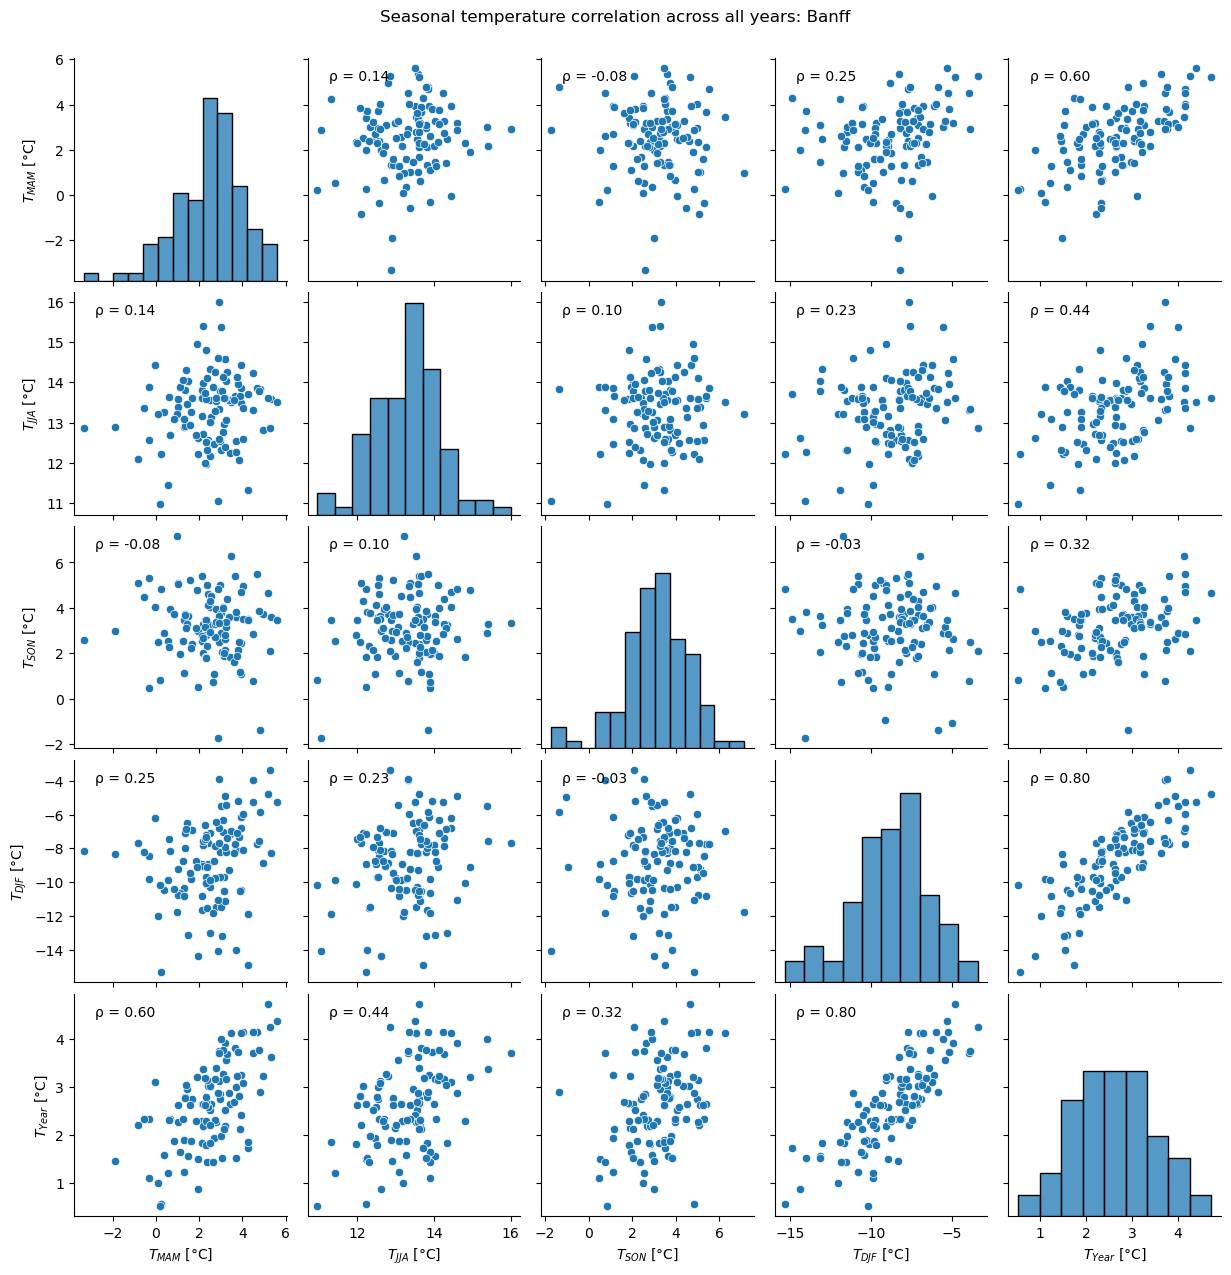

In [52]:
#for responding to ERL reviewer comments

saveIt = 0

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    x = x[~np.isnan(x+y)]
    y = y[~np.isnan(x+y)]
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(df)
g.fig.suptitle('Seasonal temperature correlation across all years: {}'.format(sites[kk_site]), y = 1.02)
g.map_lower(corrfunc)
g.map_upper(corrfunc)

if saveIt:
    plt.savefig('Figures/Supplementary/seasonal_temperature_correlation.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [53]:
#print out climate characteristics of baseline and future proxy years for each site

for kk_site, site in enumerate(sites):
    x1 = np.nanmean(x[kk_site][-1][years_future_proxy[kk_site]])
    x2 = np.nanmean(x[kk_site][-1][years_baseline[kk_site]])
    x3 = Psnowcumulative_future_proxy[kk_site][-1]
    x4 = Psnowcumulative_baseline[kk_site][-1]
    x5 = Pcumulative_future_proxy[kk_site][-1]
    x6 = Pcumulative_baseline[kk_site][-1]
    
    dT = x1 - x2
    dPsnow = 100 * (x3 - x4) / x4
    dP = 100 * (x5 - x6) / x6
    
    print(site)
    print()
    print('\tFuture proxy temp:   ', np.round(x1, decimals = 1), 'C')
    print('\tBaseline temp:       ', np.round(x2, decimals = 1), 'C')
    print('\tFuture proxy snow:   ', np.round(x3, decimals = 0), 'cm')
    print('\tBaseline snow:       ', np.round(x4, decimals = 0), 'cm')
    print('\tFuture proxy precip: ', np.round(x5, decimals = 0), 'mm')
    print('\tBaseline precip:     ', np.round(x6, decimals = 0), 'mm')
    print()
    print('\tTemp diff:           ', np.round(dT, decimals = 1), 'C')
    print('\tSnow diff:           ', np.round(dPsnow, decimals = 1), '%')
    print('\tPrecip diff:         ', np.round(dP, decimals = 1), '%')
    print()

Banff

	Future proxy temp:    2.7 C
	Baseline temp:        2.1 C
	Future proxy snow:    157.0 cm
	Baseline snow:        258.0 cm
	Future proxy precip:  423.0 mm
	Baseline precip:      478.0 mm

	Temp diff:            0.6 C
	Snow diff:            -39.1 %
	Precip diff:          -11.5 %

Columbia_Golden

	Future proxy temp:    5.4 C
	Baseline temp:        4.4 C
	Future proxy snow:    131.0 cm
	Baseline snow:        216.0 cm
	Future proxy precip:  427.0 mm
	Baseline precip:      500.0 mm

	Temp diff:            1.0 C
	Snow diff:            -39.5 %
	Precip diff:          -14.7 %

Similkameen_Princeton

	Future proxy temp:    7.0 C
	Baseline temp:        5.7 C
	Future proxy snow:    106.0 cm
	Baseline snow:        170.0 cm
	Future proxy precip:  331.0 mm
	Baseline precip:      350.0 mm

	Temp diff:            1.3 C
	Snow diff:            -37.6 %
	Precip diff:          -5.6 %

Chilliwack

	Future proxy temp:    10.6 C
	Baseline temp:        9.6 C
	Future proxy snow:    42.0 cm
	Baseline snow:

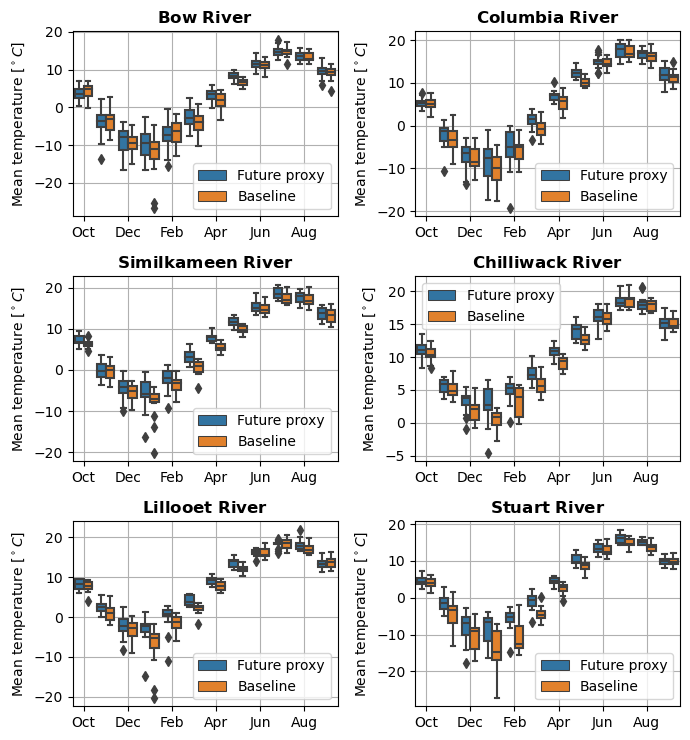

In [55]:
#TEMPERATURE: BY YEAR CATEGORY

saveIt = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 2.5*nrows))

for kk_site, ax in enumerate(axes.flatten()): #for each site

    bb = np.concatenate([Tmean_baseline_monthly[kk_site][month,:] for month in month_water_year]) #monthly baseline temp
    aa = np.concatenate([Tmean_future_proxy_monthly[kk_site][month,:] for month in month_water_year]) #monthly future proxy temp

    cc = np.concatenate([aa,bb]) #data has to be in single vector: y-variable
    bins = np.concatenate([np.concatenate([month*np.ones(len(var[month,:])) for month in range(12)]) for var in [Tmean_future_proxy_monthly[kk_site], Tmean_baseline_monthly[kk_site]]]) #x-variable: integers of month)

    hue = np.concatenate([np.tile('Future proxy',len(aa)), np.tile('Baseline', len(bb))]) #colour by baseline / future proxy
    sns.boxplot(
        x = bins,
        y = cc,
        hue = hue,
        ax = ax
    )
    ax.set_ylabel('Mean temperature [$^\circ C$]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')

#formatting
for ax in axes.flatten():
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)

    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/year_classes_temp_summary.png', dpi = 300, bbox_inches = 'tight')

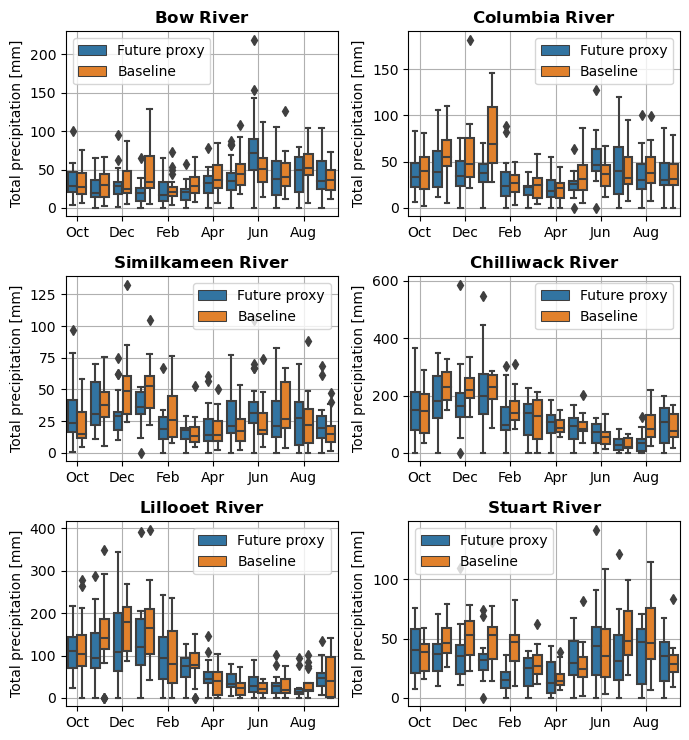

In [56]:
#PRECIP: BY YEAR CATEGORY

saveIt = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 2.5*nrows))

for kk_site, ax in enumerate(axes.flatten()):               

    aa = np.concatenate([P_future_proxy_monthly[kk_site][month,:] for month in month_water_year])
    bb = np.concatenate([P_baseline_monthly[kk_site][month,:] for month in month_water_year])
    cc = np.concatenate([aa,bb])
    bins = np.concatenate([np.concatenate([month*np.ones(len(var[month,:])) for month in range(12)]) for var in [Tmean_future_proxy_monthly[kk_site], Tmean_baseline_monthly[kk_site]]])
    hue = np.concatenate([np.tile('Future proxy',len(aa)), np.tile('Baseline', len(bb))])
    sns.boxplot(
        x = bins,
        y = cc,
        hue = hue,
        ax = ax
    )
    ax.set_ylabel('Total precipitation [mm]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')


for ax in axes.flatten():
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)

    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/year_classes_precip_summary.png', dpi = 300, bbox_inches = 'tight')

# Calculate heatwaves and their qualities

In [57]:
#calculate:
#when are heatwaves?
#what are the qualities and meteorological characteristics of all heatwaves?

hws = [[] for kk in range(Nsites)]
Tmean_exceedance = []

for kk_site, site in enumerate(sites): #for each site

    #data for this site
    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]
    data_start_year = df_sites['Year_start'][site]
    Q = df_flow['Value']
    Tmean = df_weather['Mean Temp (°C)']
    Tx = df_weather['Max Temp (°C)']
    Tn = df_weather['Min Temp (°C)']
    Ndays = len(Q)
    
    #temp exceedance
    Tmean_90_4year = np.concatenate([Tmean_90[kk_site],Tmean_90[kk_site],Tmean_90[kk_site],np.array([Tmean_90[kk_site][-1]]),Tmean_90[kk_site]]) #3 normal years and 1 leap year in 1912
    Tmean_90_vector = np.tile(Tmean_90_4year,29)[:len(Q)]
    Tmean_exceedance.append(Tmean - Tmean_90_vector)

    inds_hotter_90 = np.argwhere([Tmean > Tmean_90_vector])[:,1] #indices where temp is greater than heatwave threshold
    is_heatwave = np.zeros(Ndays) #initialize: will be binary 0 or 1 indicating if day is part of a heatwave

    #determine the indices of all heatwave days in temperature record
    for kk,ind in enumerate(inds_hotter_90[2:]): #for each day that is > HW threshold temp (starting at 3rd day, because we need at least 3 consecutive days)
        if (inds_hotter_90[2:][kk-2]==ind-2) & (inds_hotter_90[2:][kk-1]==ind-1): #if prior two days were also > HW threshold
            if P_running[kk_site][ind] < 200: #can adjust running precip threshold to identify hot/dry vs just hot events
                if (np.isnan(Q[ind]) == False) & (np.isnan(Q[ind-1]) == False) & (np.isnan(Q[ind-2]) == False): #if streamflow data is available
                    is_heatwave[ind] = 1
                    is_heatwave[ind-1] = 1
                    is_heatwave[ind-2] = 1
    inds_heatwave = np.argwhere(is_heatwave==1) #indices of heatwaves

    #define heatwaves as events, defined by a start day and end day
    jj_hw = 0
    hws[kk_site] = np.zeros([6000,2]) #arbitrarily large; will reduce size later
    hws[kk_site][0,0] = inds_heatwave[0] #first heatwave
    for kk, ind in enumerate(inds_heatwave[:-1]):
        if inds_heatwave[kk+1] != ind + 1: #if the next heatwave day is not the following day, it means we have reached the end of this heatwave
            hws[kk_site][jj_hw,1] = ind #final day of current heatwave is the present day
            hws[kk_site][jj_hw+1,0] = inds_heatwave[kk+1] #first day of next heatwave is the next heatwave day
            jj_hw+=1
    hws[kk_site] = hws[kk_site][:jj_hw-1,:] #clip final hw (end day of final hw is day 0)

In [58]:
#calculate characteristics of each heatwave

Nhws = [len(hh) for hh in hws]        #number
hwd = [np.zeros(nn) for nn in Nhws]   #duration (days)
hwm = [np.zeros(nn) for nn in Nhws]   #magnitude (degrees)
t_hw = [np.zeros(nn) for nn in Nhws]  #timing (day of year)

year_categories_hw = [np.zeros(nn) for nn in Nhws] #0: basic year; 1: baseline; 2: future proxy

dQ_hw = [np.zeros(nn) for nn in Nhws] #change in streamflow (m3/s)
dQdT_hw = [np.zeros(nn) for nn in Nhws]
Qinit = [np.zeros(nn) for nn in Nhws]
Qfinal = [np.zeros(nn) for nn in Nhws]

Tmean_hw = [np.zeros(nn) for nn in Nhws]  #mean temp during heatwave (degrees)
P_hw = [np.zeros(nn) for nn in Nhws]  #precip during heatwave (mm)

hw_year = [np.zeros(nn) for nn in Nhws] #year of heatwave
hw_month = [np.zeros(nn) for nn in Nhws] #month of heatwave

Pcumulative_hw = [np.zeros(nn) for nn in Nhws] #cumulative precip during HW

future_proxy_hw = [np.zeros(nn) for nn in Nhws] #binary 0 or 1 if future proxy year or not
baseline_hw = [np.zeros(nn) for nn in Nhws] #binary 0 or 1 if baseline year or not

Q_future_proxy = np.zeros((Nsites,365)) #average streamflow in future proxy years for each site
Q_baseline = np.zeros((Nsites,365)) #average streamflow in baseline years for each site
Q_diff_freshet = np.zeros((Nsites,365)) # average difference in flow between future proxy and baseline years

inds_future_proxy_hw = []
inds_baseline_hw = []
inds_DJF = []
inds_MAM = []
inds_JJA = []
inds_SON = []
inds_MAMJ = []

for kk_site, site in enumerate(sites): #for each site

    #data for this site
    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]
    data_start_year = df_sites['Year_start'][site] + 1
    Q = df_flow['Value']
    Tmean = df_weather['Mean Temp (°C)']
    Tx = df_weather['Max Temp (°C)']
    Tn = df_weather['Min Temp (°C)']
    Ndays = len(Q)
    
    for kk_hw in range(Nhws[kk_site]): #for each heatwave at this site

        day_start = int(hws[kk_site][kk_hw][0]) #first day of heatwave
        day_final = int(hws[kk_site][kk_hw][1]) #last day of heatwave

        hwd[kk_site][kk_hw] = hws[kk_site][kk_hw,1] - hws[kk_site][kk_hw,0] + 1 #duration
        hwm[kk_site][kk_hw] = np.mean(Tmean_exceedance[kk_site][day_start  : day_final+1]) #magnitude
        t_hw[kk_site][kk_hw] = df_weather['Day_of_year'][day_start] #day of year of first day 
        hw_year[kk_site][kk_hw] = int(df_weather.iloc[day_start]['Year']) #heatwave year
        hw_month[kk_site][kk_hw] = df_weather.index[day_start].month #heatwave month
                
        if len(np.argwhere(years_future_proxy[kk_site] == (hw_year[kk_site][kk_hw]-data_start_years[kk_site]-1))) == 1: #future proxy
            year_categories_hw[kk_site][kk_hw] = 2
        if len(np.argwhere(years_baseline[kk_site] == (hw_year[kk_site][kk_hw]-data_start_years[kk_site]-1))) == 1: #baseline
            year_categories_hw[kk_site][kk_hw] = 1
            
        Q_start = Q[day_start] #initial flow
        Q_final = Q[day_final] #final flow
        Q_max_hw = np.nanmax(Q[day_start : day_final + 1]) #peak flow
        day_max = np.argwhere(Q[day_start : day_final + 1].values == Q_max_hw).squeeze() #day of max flow
        if np.size(day_max) > 1: #if max flow achieved on more than 1 day during heatwave, then count the first day
            day_max = day_max[0]
        dQ_hw[kk_site][kk_hw] = Q_max_hw - Q_start #max change in flow during heatwave
        Qinit[kk_site][kk_hw] = Q_start
        Qfinal[kk_site][kk_hw] = Q_final

        Tmean_hw[kk_site][kk_hw] = np.nanmean(Tmean[day_start  : day_final+1]) #mean temp of heatwave
        P_hw[kk_site][kk_hw] = np.nansum(P[day_start : day_final + 1]) #total precip during heatwave

    dQdT_hw[kk_site] = dQ_hw[kk_site] / ((Tmean_hw[kk_site] + 273)*hwd[kk_site]) #beta 

    #determine year category of each heatwave
    for kk_hw, year in enumerate(hw_year[kk_site]-data_start_year):
        if year < Nyears_sites[kk_site]-1:
            if np.size(np.argwhere(year==years_future_proxy[kk_site]))>0:
                future_proxy_hw[kk_site][kk_hw] = 1
            elif np.size(np.argwhere(year==years_baseline[kk_site]))>0:
                baseline_hw[kk_site][kk_hw] = 1

    inds_future_proxy_hw.append(np.argwhere(future_proxy_hw[kk_site] == 1).squeeze())
    inds_baseline_hw.append(np.argwhere(baseline_hw[kk_site] == 1).squeeze())
    
    Q_future_proxy[kk_site] = np.nanmean(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0)
    Q_baseline[kk_site] = np.nanmean(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0)
    Q_diff_freshet[kk_site] = Q_future_proxy[kk_site] - Q_baseline[kk_site]
    
    inds_DJF.append(np.argwhere( (t_hw[kk_site] > 60)  & (t_hw[kk_site] < 150 ) & (dQ_hw[kk_site]>0)).squeeze())
    inds_MAM.append(np.argwhere( (t_hw[kk_site] > 150)  & (t_hw[kk_site] < 240 ) & (dQ_hw[kk_site]>0)).squeeze())
    inds_JJA.append(np.argwhere( (t_hw[kk_site] > 240) & (t_hw[kk_site] < 335 ) & (dQ_hw[kk_site]>0)).squeeze())
    inds_SON.append(np.argwhere( ((t_hw[kk_site] > 335) | (t_hw[kk_site] < 60 )) & (dQ_hw[kk_site]>0)).squeeze())
    inds_MAMJ.append(np.argwhere( (t_hw[kk_site] > 60)  & (t_hw[kk_site] < 180 ) & (dQ_hw[kk_site]>0)).squeeze())
    

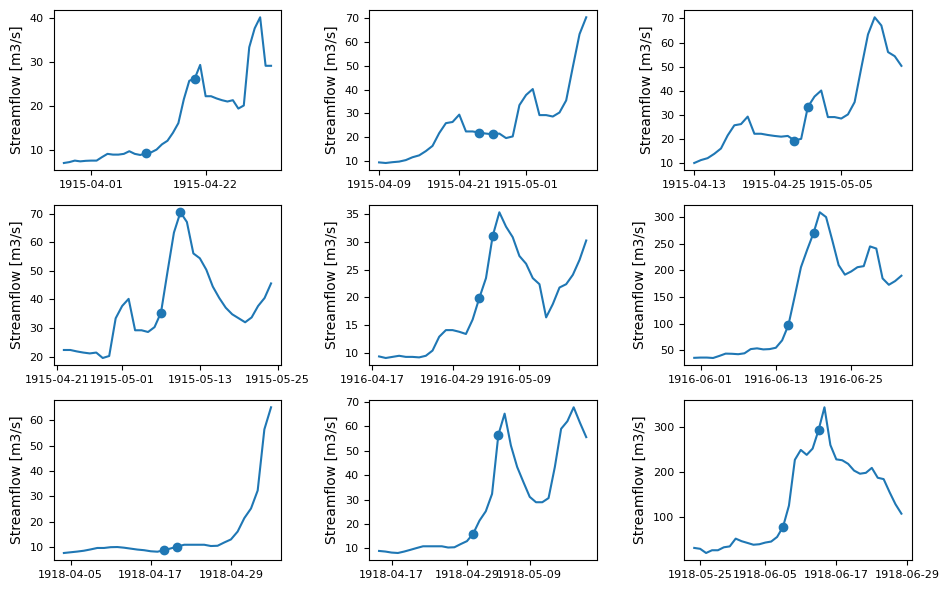

In [60]:
#visualize a few individual events to see what the raw data look like

#select site
site = 'Banff'
kk_site = sites.index(site)
df_flow = df_sites['Streamflow'][site]
Q = df_flow['Value']

nrows = 3
ncols = 3

inds_freshet = np.argwhere((t_hw[kk_site] >= 190) & (t_hw[kk_site] < 270)).squeeze()
t_hw_freshet = t_hw[kk_site][inds_freshet]
hws_freshet = hws[kk_site][inds_freshet]

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.2*ncols, 2*nrows))

for kk, ax in enumerate(axes.flatten()):
    
    kk_hw = kk+10

    window = 15 #number days around start/end of hw to plot

    hw_start = int(hws_freshet[kk_hw][0])
    hw_final = int(hws_freshet[kk_hw][1])
    start = int(hws_freshet[kk_hw][0] - window)
    final = int(hws_freshet[kk_hw][1] + window)
    
    ax.plot(Q[start:final])
    ax.scatter([df_flow.index[hw_start], df_flow.index[hw_final]], [Q[hw_start], Q[hw_final]])

    ax.set_xticks(ax.get_xticks()[::3])
    ax.tick_params(labelsize = 8)
    ax.set_ylabel('Streamflow [m3/s]')

plt.tight_layout()
    
plt.show()

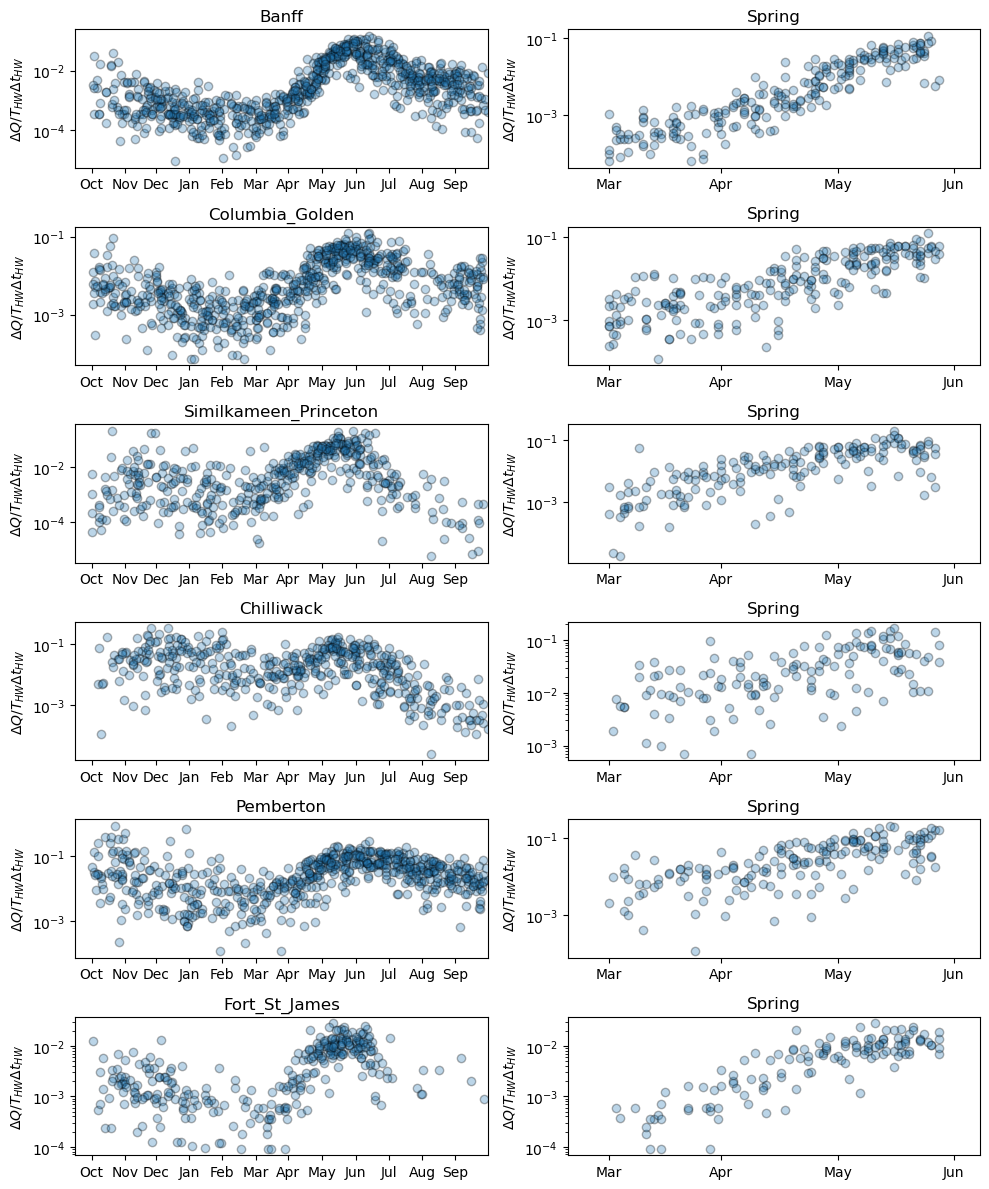

In [63]:
#visualize beta vs time for all heatwaves at each site

nrows = Nsites
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2*nrows))

for kk_site, site in enumerate(sites): #for each site

    var1 = t_hw[kk_site]
    var2 = dQdT_hw[kk_site]

    #plot all hws
    axes[kk_site,0].scatter(var1,var2, edgecolor = 'k', alpha = 0.3)
    axes[kk_site,0].set_xlim(left = -15,right = 364)
    axes[kk_site,0].set_xticks(first_days_of_month)
    axes[kk_site,0].set_xticklabels(months_str, rotation = 0)
    axes[kk_site,0].set_title(site)

    #plot just spring hws
    axes[kk_site,1].scatter(var1[inds_MAM[kk_site]],var2[inds_MAM[kk_site]], edgecolor = 'k', alpha = 0.3)
    axes[kk_site,1].set_xticks(first_days_of_month)
    axes[kk_site,1].set_xticklabels(months_str, rotation = 0)
    axes[kk_site,1].set_xlim(left = 140,right = 250)
    axes[kk_site,1].set_title('Spring')

#formatting
for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_ylabel('$\Delta Q / T_{HW} \Delta t_{HW}$')
    
plt.tight_layout()
plt.show()

In [64]:
#calculate beta and streamflow over rolling 30-day windows for baseline and future proxy cases

#initialize
dQdT_rolling_future_proxy = np.zeros((Nsites,365))
dQdT_rolling_future_proxy_p1 = np.zeros((Nsites,365))
dQdT_rolling_future_proxy_p2 = np.zeros((Nsites,365))
dQdT_rolling_future_proxy_std = np.zeros((Nsites,365))

dQdT_rolling_baseline = np.zeros((Nsites,365))
dQdT_rolling_baseline_p1 = np.zeros((Nsites,365))
dQdT_rolling_baseline_p2 = np.zeros((Nsites,365))
dQdT_rolling_baseline_std = np.zeros((Nsites,365))

Q_future_proxy_rolling = np.zeros((Nsites,365))
Q_baseline_rolling = np.zeros((Nsites,365))
Q_diff_freshet_rolling = np.zeros((Nsites,365))

Q_init_baseline_rolling = np.zeros((Nsites,365))
Q_init_future_proxy_rolling = np.zeros((Nsites,365))

N_future_proxy_hw = np.zeros((Nsites,365))
N_baseline_hw = np.zeros((Nsites,365))
N_all_hw = np.zeros((Nsites,365))

Tmean_baseline_hw_rolling = np.zeros((Nsites,365))
Tmean_future_proxy_hw_rolling = np.zeros((Nsites,365))

Pmean_baseline_hw_rolling = np.zeros((Nsites,365))
Pmean_future_proxy_hw_rolling = np.zeros((Nsites,365))

bin_width = 30

for kk_site, site in enumerate(sites): #for each site
    
    for day_start in range(0,365): #for each day of the year (left edge of 30-day bins)

        if day_start < 335: #if there are at least 30 days left in the year, 
            
            inds_daily = np.arange(day_start,day_start + bin_width)

            inds_bin_future_proxy = np.argwhere(
                (t_hw[kk_site][inds_future_proxy_hw[kk_site]] >= day_start) & 
                (t_hw[kk_site][inds_future_proxy_hw[kk_site]] < day_start + bin_width)
            ).squeeze() #indices of heatwaves in future proxy years that are in this 30-day bin

            inds_bin_baseline = np.argwhere(
                (t_hw[kk_site][inds_baseline_hw[kk_site]] >= day_start) & 
                (t_hw[kk_site][inds_baseline_hw[kk_site]] < day_start + bin_width)
            ).squeeze() #indices of heatwaves in baseline years that are in this 30-day bin

            inds_bin_all = np.argwhere(
                (t_hw[kk_site] >= day_start) & 
                (t_hw[kk_site] < day_start + bin_width)
            ).squeeze()  #indices of heatwaves in all years that are in this 30-day bin

        else:
            
            N_rollover_days = 30 - (365 - day_start) #periodic: number of days in this 30-day bin that roll over to the start of the water year
            
            inds_daily = np.concatenate([np.arange(N_rollover_days), np.arange(day_start,365)])

            inds_bin_future_proxy = np.argwhere(
                (t_hw[kk_site][inds_future_proxy_hw[kk_site]] >= day_start) | 
                (t_hw[kk_site][inds_future_proxy_hw[kk_site]] < N_rollover_days)
            ).squeeze() #indices of heatwaves in future proxy years that are in this 30-day bin

            inds_bin_baseline = np.argwhere(
                (t_hw[kk_site][inds_baseline_hw[kk_site]] >= day_start) | 
                (t_hw[kk_site][inds_baseline_hw[kk_site]] < N_rollover_days)
            ).squeeze() #indices of heatwaves in baseline years that are in this 30-day bin

            inds_bin_all = np.argwhere(
                (t_hw[kk_site] >= day_start) | 
                (t_hw[kk_site] < N_rollover_days)
            ).squeeze() #indices of heatwaves in all years that are in this 30-day bin

        N_future_proxy_hw[kk_site,day_start] = np.size(inds_bin_future_proxy) #number of future proxy hws in this bin
        N_baseline_hw[kk_site,day_start] = np.size(inds_bin_baseline) #number of baseline hws in this bin
        N_all_hw[kk_site,day_start] = np.size(inds_bin_all) #number of all-year hws in this bin

        #calculate average / variability of dQdT in future proxy years in this bin
        if N_future_proxy_hw[kk_site,day_start] > 0:
            
            # dQdT_rolling_future_proxy[kk_site,day_start] = np.mean(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
            dQdT_rolling_future_proxy[kk_site,day_start] = np.median(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
            dQdT_rolling_future_proxy_p1[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy], q = 25)
            dQdT_rolling_future_proxy_p2[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy], q = 75)
            dQdT_rolling_future_proxy_std[kk_site,day_start] = np.std(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
        
            Q_init_future_proxy_rolling[kk_site,day_start] = np.mean(Qinit[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
            Tmean_future_proxy_hw_rolling[kk_site,day_start] = np.nanmean(Tmean_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
            Pmean_future_proxy_hw_rolling[kk_site,day_start] = np.nanmean(P_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy] / hwd[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
        
        else:    
            dQdT_rolling_future_proxy[kk_site,day_start] = np.nan
            dQdT_rolling_future_proxy_p1[kk_site,day_start] = np.nan
            dQdT_rolling_future_proxy_p2[kk_site,day_start] = np.nan
            dQdT_rolling_future_proxy_std[kk_site,day_start] = np.nan
            Q_init_future_proxy_rolling[kk_site,day_start] = np.nan
            Tmean_future_proxy_hw_rolling[kk_site,day_start] = np.nan
            Pmean_future_proxy_hw_rolling[kk_site,day_start] = np.nan

        #calculate average / variability of dQdT in baseline years in this bin
        if N_baseline_hw[kk_site,day_start] > 0:
            
            # dQdT_rolling_baseline[kk_site,day_start] = np.mean(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
            dQdT_rolling_baseline[kk_site,day_start] = np.median(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
            dQdT_rolling_baseline_p1[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline], q = 25)
            dQdT_rolling_baseline_p2[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline], q = 75)
            dQdT_rolling_baseline_std[kk_site,day_start] = np.std(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
            
            Q_init_baseline_rolling[kk_site,day_start] = np.mean(Qinit[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
            Tmean_baseline_hw_rolling[kk_site,day_start] = np.nanmean(Tmean_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
            Pmean_baseline_hw_rolling[kk_site,day_start] = np.nanmean(P_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline] / hwd[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
        
        else:
            dQdT_rolling_baseline[kk_site,day_start] = np.nan
            dQdT_rolling_baseline_p1[kk_site,day_start] = np.nan
            dQdT_rolling_baseline_p2[kk_site,day_start] = np.nan
            dQdT_rolling_baseline_std[kk_site,day_start] = np.nan
            Q_init_baseline_rolling[kk_site,day_start] = np.nan
            Tmean_baseline_hw_rolling[kk_site,day_start] = np.nan
            Pmean_baseline_hw_rolling[kk_site,day_start] = np.nan

        #calculate average streamflow in baseline / future proxy years, and the difference
        Q_future_proxy_rolling[kk_site,day_start] = np.mean(Q_future_proxy[kk_site,inds_daily])
        Q_baseline_rolling[kk_site,day_start] = np.mean(Q_baseline[kk_site,inds_daily])
        Q_diff_freshet_rolling[kk_site,day_start] = np.mean(Q_diff_freshet[kk_site,inds_daily])
        # Q_future_proxy_rolling[kk_site,day_start] = np.median(Q_future_proxy[kk_site,inds_daily])
        # Q_baseline_rolling[kk_site,day_start] = np.median(Q_baseline[kk_site,inds_daily])
        # Q_diff_freshet_rolling[kk_site,day_start] = np.median(Q_diff_freshet[kk_site,inds_daily])

    dQdT_diff_rolling = dQdT_rolling_future_proxy - dQdT_rolling_baseline

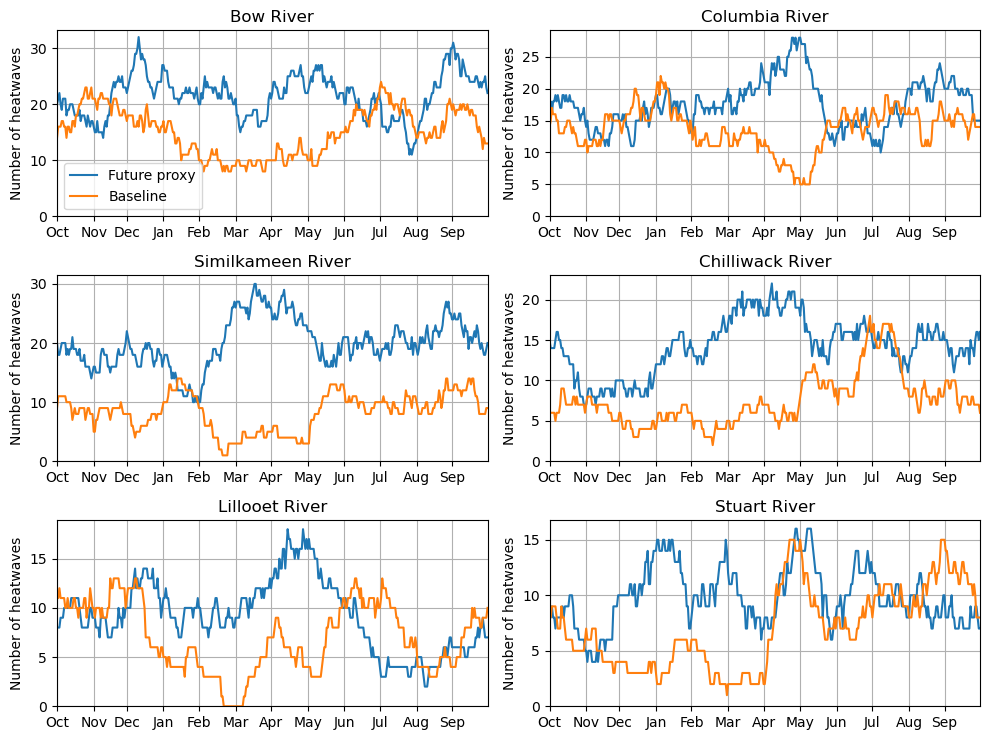

In [65]:
#visualize the number of heatwaves starting in each 30-day bin, for baseline/future proxy years at each site

saveIt = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2.5*nrows))

for kk_site, ax in enumerate(axes.flatten()[:Nsites]): #for each site
    ax.plot(N_future_proxy_hw[kk_site], label = 'Future proxy')
    ax.plot(N_baseline_hw[kk_site], label = 'Baseline')
    ax.set_title(sites_short[kk_site])
    ax.set_ylabel('Number of heatwaves')

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
axes[0,0].legend()
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/N_hws.png', dpi = 300, bbox_inches = 'tight')

In [66]:
np.mean(N_future_proxy_hw), np.mean(N_baseline_hw)

(15.41095890410959, 9.780821917808218)

In [67]:
np.std(N_future_proxy_hw), np.std(N_baseline_hw)

(5.935041708789342, 4.815632578661945)

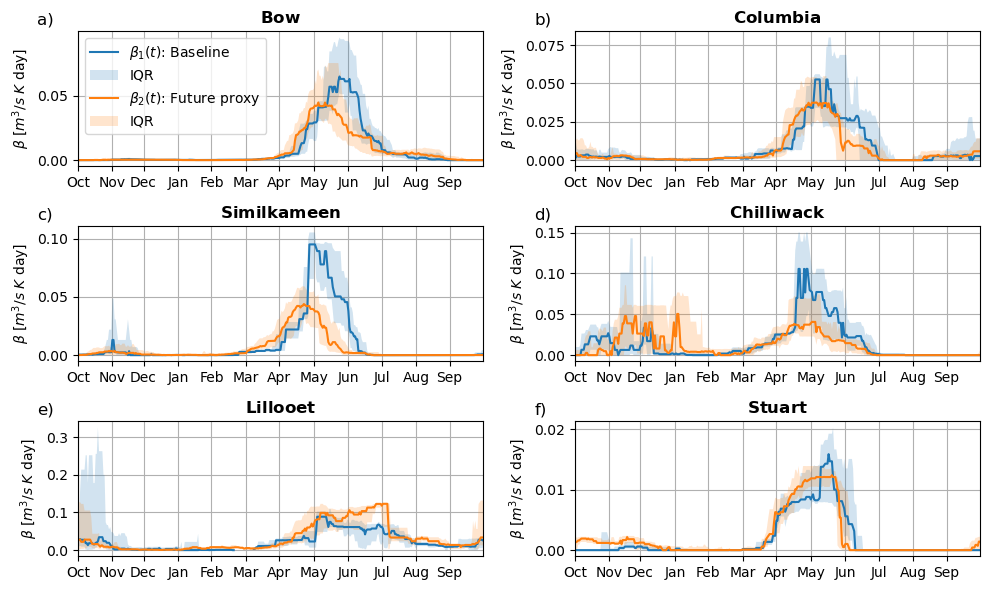

In [68]:
#visualize baseline and future proxy beta for each site

saveIt = 0

fs = 12

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2*nrows))

for kk_site, ax in enumerate(axes.flatten()): #for each site

    ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$: Baseline')
    ax.fill_between(x = np.arange(365), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$: Future proxy')
    ax.fill_between(x = np.arange(365), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $K$ day]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$')
    if kk_site == 0:
        ax.legend(loc = 'upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[kk_site], transform = ax.transAxes, fontsize = fs)

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/dQdTdt_all_sites_80p_2.png', dpi = 300, bbox_inches = 'tight')
    # plt.savefig('Figures/Supplementary/dQdTdt_all_sites_90p_2.png', dpi = 300, bbox_inches = 'tight')

plt.show()

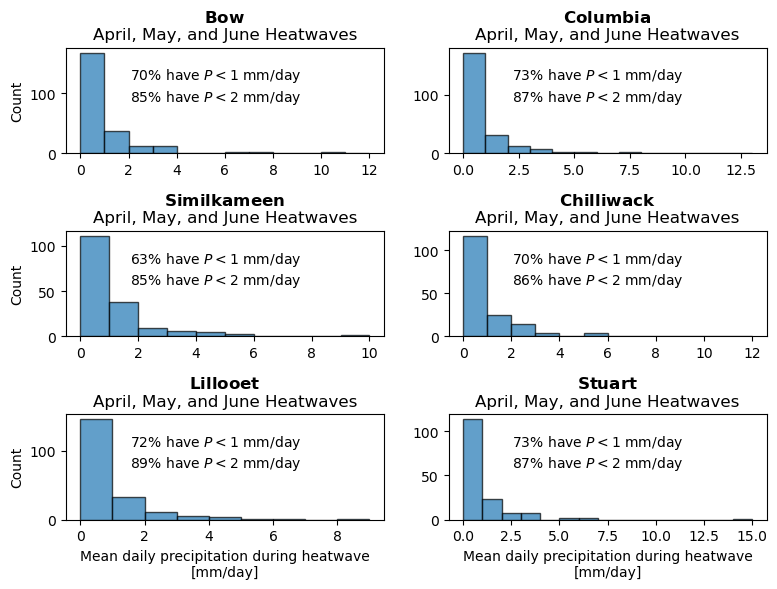

In [69]:
saveIt = 0

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

for kk_site, ax in enumerate(axes.flatten()):

    inds_freshet = np.argwhere(
        (t_hw[kk_site] > 180) & 
        (t_hw[kk_site] < 270)
    ).squeeze()

    xx = P_hw[kk_site][inds_freshet] / hwd[kk_site][inds_freshet]
    
    bins = np.arange(np.ceil(np.max(xx))+1)

    ax.hist(xx, bins = bins, edgecolor = 'k', linewidth = 1, alpha = 0.7)
    
    if np.mod(kk_site,2) == 0:
        ax.set_ylabel('Count')
        
    if kk_site > 3:
        ax.set_xlabel('Mean daily precipitation during heatwave\n[mm/day]')
        
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$\nApril, May, and June Heatwaves')
    
    s1 = str(int(100*len(xx[xx<1])/len(xx))) + '% have $P<1$ mm/day'
    s2 = str(int(100*len(xx[xx<2])/len(xx))) + '% have $P<2$ mm/day'
    ax.text(x = 0.2, y = 0.7, s=s1, transform = ax.transAxes)
    ax.text(x = 0.2, y = 0.5, s=s2, transform = ax.transAxes)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/freshet_heatwave_precip.png', dpi = 300, bbox_inches = 'tight')

plt.show()

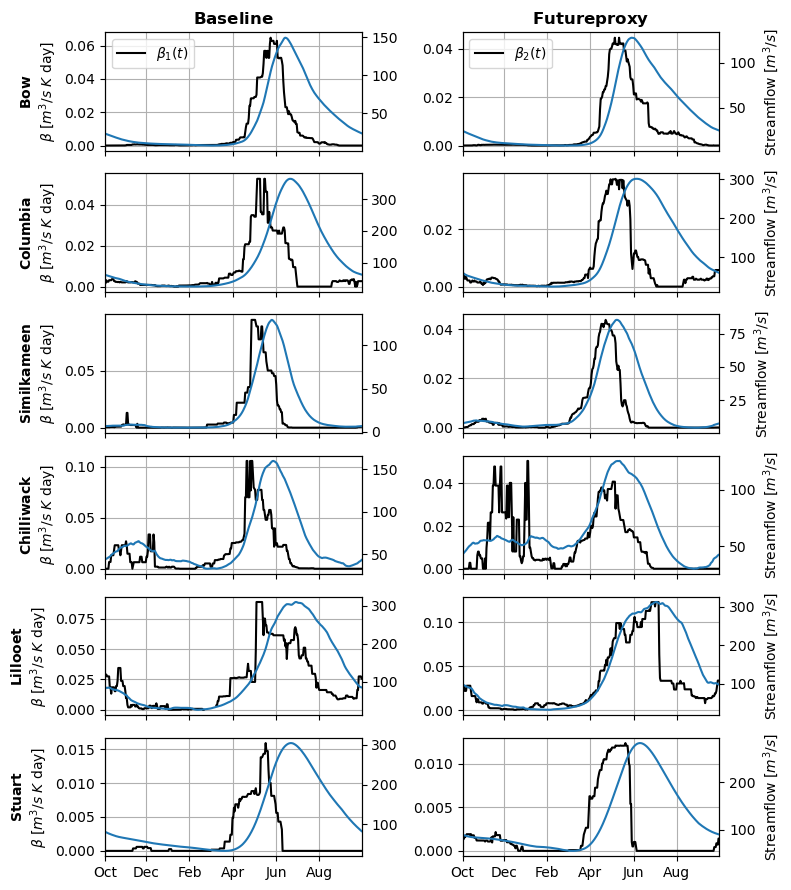

In [70]:
#visualize baseline and future proxy beta and streamflow for each site

saveIt = 0

fs = 12

nrows = 6
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 1.5*nrows))

#BASELINE
for kk_site, ax in enumerate(axes[:,0]):

    ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$', color = 'k')
    ax2 = ax.twinx()
    ax2.plot(Q_baseline_rolling[kk_site], label = '$Q_1$')
    
    #formatting
    ax.set_ylabel(r'$\bf{' + sites_short[kk_site][:-5] + '}$\n$\u03B2$ [$m^3 / s$ $K$ day]')
    if kk_site == 0:
        ax.set_title(r'$\bf{Baseline}$')
    if kk_site == 0:
        ax.legend(loc = 'upper left')
    
#FUTURE PROXY
for kk_site, ax in enumerate(axes[:,1]):

    ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$', color = 'k')    
    ax2 = ax.twinx()
    ax2.plot(Q_future_proxy_rolling[kk_site], label = '$Q_2$')
    
    #formatting
    ax2.set_ylabel('Streamflow [$m^3 / s$]')
    if kk_site == 0:
        ax.set_title(r'$\bf{Future proxy}$')
    if kk_site == 0:
        ax.legend(loc = 'upper left')

#formatting
for kk_ax, ax in enumerate(axes.flatten()):
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month[::2])
    if kk_ax > 9:
        ax.set_xticklabels(months_str[::2], rotation = 0)
    else:
        ax.set_xticklabels([])
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/dQdTdt_Q_all_sites.png', dpi = 300, bbox_inches = 'tight')

plt.show()

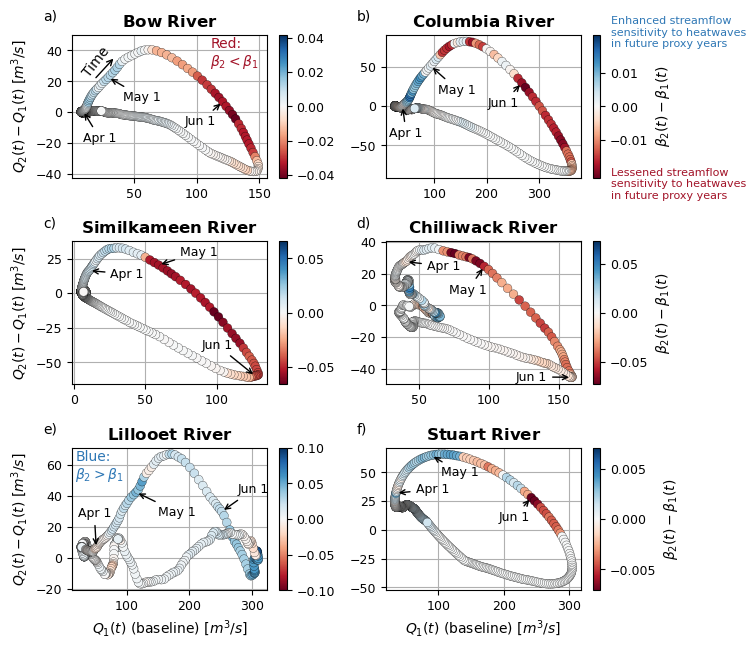

In [72]:
#visualize the change in flow vs baseline flow, coloured by change in beta

saveIt = 0

fs = 10

#for labelling text on the figure
dx_text = [[0,12,-30],
           [-25,15,-65],
           [15,15,-38],
           [15,-25,-40],
           [-30,35,25],
           [30,15,-50]]

dy_text = [[-20,-15,-15],
           [-40,-35,-30],
           [-5,7,20],
           [-5,-17,-2],
           [20,-15,12],
           [0,-18,-20]]        

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 2.2*nrows))

for kk_site, ax in enumerate(axes.flatten()): #for each site

    vmax = np.max(np.abs(dQdT_diff_rolling[kk_site])) #centre colourmap at 0
    vmin = -vmax
    s = ax.scatter(x = Q_baseline_rolling[kk_site], 
                y = Q_diff_freshet_rolling[kk_site], 
                c = dQdT_diff_rolling[kk_site],
                edgecolor = 'k',
                linewidth = 0.2,
                cmap = 'RdBu',
                vmax = vmax, 
                vmin = vmin,
                s = 40
               )
    
    inds_markers = [60,150,240,330]
    inds_markers = [180,210,240]
    inds_text = ['Apr 1', 'May 1', 'Jun 1']
    for kk, ind in enumerate(inds_markers):
        x = Q_baseline_rolling[kk_site][inds_markers][kk]
        y = Q_diff_freshet_rolling[kk_site][inds_markers][kk]
        ax.annotate(fontsize = 9, text = inds_text[kk], xy = (x, y), xytext = (x+dx_text[kk_site][kk],y+dy_text[kk_site][kk]), arrowprops=dict(arrowstyle="->"))
    
    #formatting
    if kk_site > 3:
        ax.set_xlabel('$Q_1(t)$ (baseline) $[m^3/s]$', fontsize = fs)
    if np.mod(kk_site,2)==0:
        ax.set_ylabel('$Q_2(t)-Q_1(t)$ $[m^3/s]$', fontsize = fs)
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
    ax.tick_params(labelsize = fs-1)
    
    #colourbar
    cbar = plt.colorbar(s,ax=ax)
    cbar.ax.tick_params(labelsize = fs-1)
    if np.mod(kk_site,2)==1:
        cbar.ax.set_ylabel('$\u03B2 _2(t) - \u03B2 _1(t)$', fontsize = fs)
    if kk_site == 1:
        cbar.ax.set_yticks([-0.01,0,0.01])
        
    ax.text(x = -0.15, y = 1.1, s = abc[kk_site], transform = ax.transAxes, fontsize = fs)

#gridlines
for ax in axes.flatten():
    ax.grid(True)
    ax.set_axisbelow(True)
    
#text labels

##### TIME
ax = axes[0,0]
x = 7
y = 23
s = 'Time'
ax.text(x = x, y = y, s = s, rotation = 52)
ax.annotate(text = '', xy = (18,21), xytext = (35,36), arrowprops=dict(arrowstyle="<-"))

##### RED
ax = axes[0,0]
ax.set_ylim(top = 50)
x = 111
y = 30
s = 'Red:\n$\u03B2 _2 < \u03B2 _1$'
c = matplotlib.cm.get_cmap('RdBu')(20)
ax.text(x = x, y = y, s = s, c = c)

##### BLUE
ax = axes[2,0]
x = 17
y = 51
s = 'Blue:\n$\u03B2 _2 > \u03B2 _1$'
c = matplotlib.cm.get_cmap('RdBu')(220)
ax.text(x = x, y = y, s = s, c = c)

##### COLOURBAR TEXT: BLUE
x = 0.88
y = 0.92
s = 'Enhanced streamflow\nsensitivity to heatwaves\nin future proxy years'
c = matplotlib.cm.get_cmap('RdBu')(220)
fig.text(x = x, y = y, s = s, c = c, fontsize = 8)

##### COLOURBAR TEXT: RED
x = 0.88
y = 0.69
s = 'Lessened streamflow\nsensitivity to heatwaves\nin future proxy years'
c = matplotlib.cm.get_cmap('RdBu')(20)
fig.text(x = x, y = y, s = s, c = c, fontsize = 8)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/dQdTdt_by_Qdiff_Q_all_sites_6.png', dpi = 300, bbox_inches = 'tight')

plt.show()

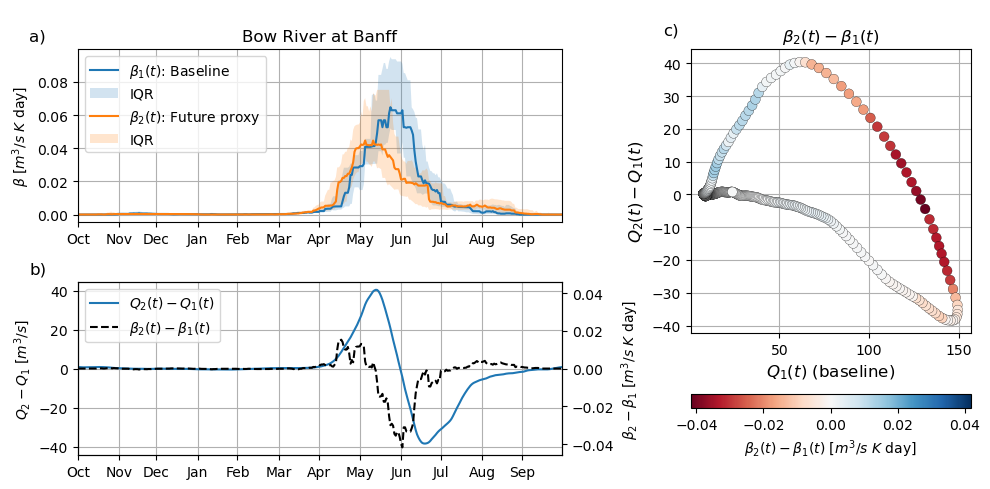

In [76]:
#visualize a single site beta, flow, and change-in-beta-and-flow scatter plot
#this format is useful for powerpoint presentations

saveIt = 0

fs = 12

kk_site = 0

nrows = 2
ncols = 5

fig = plt.figure(figsize = (2*ncols,2.5*nrows))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

axes_beta = [fig.add_subplot(gs[0,:3]) for kk in range(1)]
axes_diff_time = [fig.add_subplot(gs[1,:3]) for kk in range(1)]
axes_diff_state = [fig.add_subplot(gs[:,3:]) for kk in range(1)]

for kk_site, site in enumerate(sites[:1]): #for each site

    ##### BETA THROUGH TIME
    ax = axes_beta[kk_site]
    ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$: Baseline')
    ax.fill_between(x = np.arange(365), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$: Future proxy')
    ax.fill_between(x = np.arange(365), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $K$ day]')
    ax.set_title('Bow River at Banff', fontsize = fs)
    ax.legend(loc = 'upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[0], transform = ax.transAxes, fontsize = fs)

    ##### BETA2 - BETA1 & Q2 - Q1
    ax = axes_diff_time[kk_site]
    ymax1 = 1.1*np.nanmax(np.abs(Q_diff_freshet_rolling[kk_site]))
    ymin1 = -ymax1
    ymax2 = 1.1*np.nanmax(np.abs(dQdT_diff_rolling[kk_site]))
    ymin2 = -ymax2
    l1 = ax.plot(Q_diff_freshet_rolling[kk_site], label = '$Q_2(t) - Q_1(t)$')
    ax.set_ylabel('$Q_2 - Q_1$ [$m^3/s$]')
    ax.set_ylim(bottom = ymin1, top = ymax1)
    ax2 = ax.twinx()
    l2 = ax2.plot(dQdT_diff_rolling[kk_site],'k--', label = '$\u03B2 _2(t) - \u03B2 _1(t)$')
    ax2.set_ylim(bottom = ymin2, top = ymax2)
    ax2.set_ylabel('$\u03B2 _2 - \u03B2 _1$ [$m^3 / s$ $K$ day]')
    labels = [ll.get_label() for ll in l1+l2]
    ax.legend(l1+l2,labels, loc='upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[1], transform = ax.transAxes, fontsize = fs)
    
    ##### Q_DIFF VS Q1 BY BETA_DIFF
    ax = axes_diff_state[kk_site]
    ax.grid(True)
    ax.set_axisbelow(True)
    vmax = np.max(np.abs(dQdT_diff_rolling[kk_site]))
    vmin = -vmax
    s = ax.scatter(x = Q_baseline_rolling[kk_site], 
                y = Q_diff_freshet_rolling[kk_site], 
                c = dQdT_diff_rolling[kk_site],
                edgecolor = 'k',
                linewidth = 0.2,
                cmap = 'RdBu',
                vmax = vmax, 
                vmin = vmin,
                s = 50
               )
    #formatting
    ax.set_xlabel('$Q_1(t)$ (baseline)', fontsize = fs)
    ax.set_ylabel('$Q_2(t)-Q_1(t)$', fontsize = fs)
    ax.set_title('\n$\u03B2 _2(t) - \u03B2 _1(t)$')
    ax.text(x = -0.1, y = 1.05, s = abc[2], transform = ax.transAxes, fontsize = fs)
    ax.tick_params(labelsize = fs-2)
    
    #colourbar
    cbar = plt.colorbar(s,ax=ax, orientation = 'horizontal')
    cbar.ax.tick_params(labelsize = fs-2)
    cbar.ax.set_xlabel('$\u03B2 _2(t) - \u03B2 _1(t)$ [$m^3 / s$ $K$ day]')

#formatting
for ax in axes_beta:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
for ax in axes_diff_time:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout(w_pad = -1.)

if saveIt:
    plt.savefig('Figures/dQdTdt_and_streamflow_5.png', dpi = 300, bbox_inches = 'tight')

plt.show()

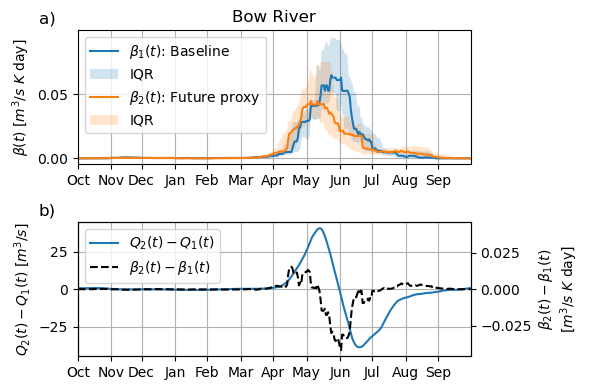

In [77]:
#visualize beta, flow, and relative diff between baseline and future proxy years for one site

saveIt = 0

fs = 12

kk_site = 0

nrows = 2
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 2*nrows))

axes_beta = axes[0]
axes_diff_time = axes[1]

##### BETA THROUGH TIME
ax = axes_beta
ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$: Baseline')
ax.fill_between(x = np.arange(365), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$: Future proxy')
ax.fill_between(x = np.arange(365), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
ax.set_ylabel('$\u03B2(t)$ [$m^3 / s$ $K$ day]')
ax.set_title(sites_short[kk_site], fontsize = fs)
ax.legend(loc = 'upper left')
ax.text(x = -0.1, y = 1.05, s = abc[0], transform = ax.transAxes, fontsize = fs)

##### BETA2 - BETA1 & Q2 - Q1
ax = axes_diff_time
ymax1 = 1.1*np.nanmax(np.abs(Q_diff_freshet_rolling[kk_site]))
ymin1 = -ymax1
ymax2 = 1.1*np.nanmax(np.abs(dQdT_diff_rolling[kk_site]))
ymin2 = -ymax2
l1 = ax.plot(Q_diff_freshet_rolling[kk_site], label = '$Q_2(t) - Q_1(t)$')
ax.set_ylabel('$Q_2(t) - Q_1(t)$ [$m^3/s$]')
ax.set_ylim(bottom = ymin1, top = ymax1)
ax2 = ax.twinx()
l2 = ax2.plot(dQdT_diff_rolling[kk_site],'k--', label = '$\u03B2 _2(t) - \u03B2 _1(t)$')
ax2.set_ylim(bottom = ymin2, top = ymax2)
ax2.set_ylabel('$\u03B2 _2(t) - \u03B2 _1(t)$\n[$m^3 / s$ $K$ day]')
labels = [ll.get_label() for ll in l1+l2]
ax.legend(l1+l2,labels, loc='upper left')
ax.text(x = -0.1, y = 1.05, s = abc[1], transform = ax.transAxes, fontsize = fs)

#formatting
for ax in axes:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout(w_pad = -1.)

if saveIt:
    plt.savefig('Figures/dQdTdt_and_streamflow_5.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [80]:
print('HEATWAVE DURATION')
for kk_site in range(Nsites):
    print(sites_short[kk_site])
    print('\tMean: ' + str(np.round(np.mean(hwd[kk_site]), decimals = 2)) + ' days')
    print('\tMedian: ' + str(np.round(np.median(hwd[kk_site]), decimals = 2)) + ' days')
    print('\tStdDev: ' + str(np.round(np.std(hwd[kk_site]), decimals = 2)) + ' days')

HEATWAVE DURATION
Bow River
	Mean: 4.7 days
	Median: 4.0 days
	StdDev: 2.22 days
Columbia River
	Mean: 5.04 days
	Median: 4.0 days
	StdDev: 2.68 days
Similkameen River
	Mean: 4.72 days
	Median: 4.0 days
	StdDev: 2.49 days
Chilliwack River
	Mean: 4.52 days
	Median: 4.0 days
	StdDev: 1.98 days
Lillooet River
	Mean: 5.54 days
	Median: 4.0 days
	StdDev: 3.48 days
Stuart River
	Mean: 4.51 days
	Median: 4.0 days
	StdDev: 2.19 days


In [81]:
print('HEATWAVE MAGNITUDE')
for kk_site in range(Nsites):
    print(sites_short[kk_site])
    print('\tMean: ' + str(np.round(np.mean(hwm[kk_site]), decimals = 2)) + ' C')
    print('\tMedian: ' + str(np.round(np.median(hwm[kk_site]), decimals = 2)) + ' C')
    print('\tStdDev: ' + str(np.round(np.std(hwm[kk_site]), decimals = 2)) + ' C')

HEATWAVE MAGNITUDE
Bow River
	Mean: 2.28 C
	Median: 2.1 C
	StdDev: 1.09 C
Columbia River
	Mean: 1.97 C
	Median: 1.83 C
	StdDev: 0.94 C
Similkameen River
	Mean: 1.96 C
	Median: 1.77 C
	StdDev: 0.93 C
Chilliwack River
	Mean: 2.02 C
	Median: 1.84 C
	StdDev: 1.02 C
Lillooet River
	Mean: 1.54 C
	Median: 1.42 C
	StdDev: 0.79 C
Stuart River
	Mean: 2.26 C
	Median: 2.03 C
	StdDev: 1.08 C


In [84]:
day_start = datetime.date(2001,10,1) #arbitrary reference: October 1st, (any year that is not a leap year)

print('OVERALL FRESHET TIMING')
for kk_site in range(Nsites):
    delta = datetime.timedelta(np.round(np.nanmean(freshet_day[kk_site]))-1)
    day_fin = day_start + delta
    print(sites_short[kk_site] + ':\n\t' + day_fin.strftime("%d-%m-%Y") + u" \u00B1 " + str(np.round(np.nanstd(freshet_day[kk_site]))))

OVERALL FRESHET TIMING
Bow River:
	09-06-2002 ± 7.0
Columbia River:
	12-06-2002 ± 7.0
Similkameen River:
	17-05-2002 ± 9.0
Chilliwack River:
	19-05-2002 ± 7.0
Lillooet River:
	09-06-2002 ± 7.0
Stuart River:
	10-06-2002 ± 10.0


In [85]:
print('BASELINE FRESHET TIMING')
for kk_site in range(Nsites):
    delta = datetime.timedelta(np.round(np.nanmean(freshet_day[kk_site][years_baseline[kk_site]]))-1)
    day_fin = day_start + delta
    print(sites_short[kk_site] + ':\n\t' + day_fin.strftime("%d-%m-%Y") + u" \u00B1 " + str(np.round(np.nanstd(freshet_day[kk_site][years_baseline[kk_site]]))))    
    

BASELINE FRESHET TIMING
Bow River:
	15-06-2002 ± 4.0
Columbia River:
	16-06-2002 ± 4.0
Similkameen River:
	24-05-2002 ± 4.0
Chilliwack River:
	24-05-2002 ± 4.0
Lillooet River:
	15-06-2002 ± 4.0
Stuart River:
	17-06-2002 ± 4.0


In [86]:
print('FUTURE PROXY FRESHET TIMING')
for kk_site in range(Nsites):
    delta = datetime.timedelta(np.round(np.nanmean(freshet_day[kk_site][years_future_proxy[kk_site]]))-1)
    day_fin = day_start + delta
    print(sites_short[kk_site] + ':\n\t' + day_fin.strftime("%d-%m-%Y") + u" \u00B1 " + str(np.round(np.nanstd(freshet_day[kk_site][years_future_proxy[kk_site]]))))
    

FUTURE PROXY FRESHET TIMING
Bow River:
	05-06-2002 ± 4.0
Columbia River:
	06-06-2002 ± 4.0
Similkameen River:
	10-05-2002 ± 5.0
Chilliwack River:
	12-05-2002 ± 4.0
Lillooet River:
	06-06-2002 ± 2.0
Stuart River:
	04-06-2002 ± 7.0


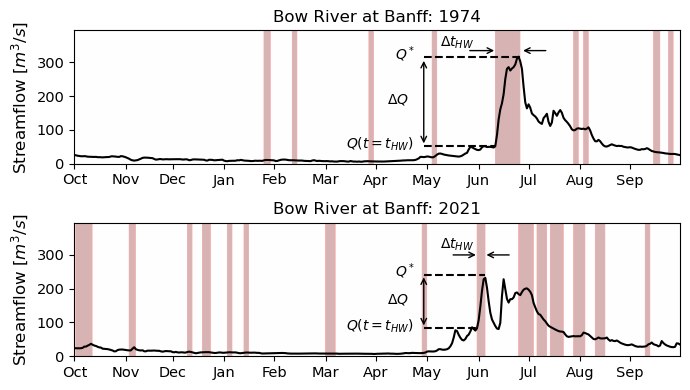

In [87]:
#visualize: individual years of streamflow and heatwaves

saveIt = 0

fs = 12

years = [63,110]

nrows = 2
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (7,4))

##### 1974

ax = axes[0]
year = years[0]
heatwave_vec = np.zeros(365)
hws_this_year = np.argwhere(hw_year[0]==year+data_start_years[0]+1).squeeze()
for hw in hws_this_year:
    heatwave_vec[int(t_hw[0][hw]):int(t_hw[0][hw]+hwd[0][hw])] = 1

ax.imshow(heatwave_vec.reshape(1,-1), aspect = 'auto', extent = [0,365,0,395], cmap = 'seismic', vmin = -1, alpha = 0.3)
ax.plot(Qyearly[0][year,:], 'k')

#annotate figure with labels etc
tt = int(t_hw[0][hws_this_year[4]])
ttf = tt + int(hwd[0][hws_this_year[4]])
Q_t_hw = Qyearly[0][year,tt]
Q_star = Qyearly[0][year,ttf]

ax.plot([210, tt], [Q_t_hw, Q_t_hw], 'k--')
ax.plot([210, ttf], [Q_star+12, Q_star+12], 'k--')

ax.text(x = 163, y = Q_t_hw-6, s = '$Q(t=t_{HW})$')
ax.text(x = 193, y = Q_star+5, s = '$Q^*$')
ax.text(x = 188, y = 0.5*(Q_star - Q_t_hw) + Q_t_hw, s = '$\Delta Q$')
ax.text(x = 220, y = 348, s = '$\Delta t_{HW}$')
ax.annotate(text = '', xy = (210,Q_t_hw), xytext = (210,Q_star+10), arrowprops=dict(arrowstyle="<->"))
ax.annotate(text = '', xy = (236,335), xytext = (tt+1,335), arrowprops=dict(arrowstyle="<-"))
ax.annotate(text = '', xy = (285,335), xytext = (ttf-0,335), arrowprops=dict(arrowstyle="<-"))

ax.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax.set_title('Bow River at Banff: ' + str(years[0] + data_start_years[0] + 1), fontsize = fs)


##### 2021

ax = axes[1]
year = years[1]
heatwave_vec = np.zeros(365)
hws_this_year = np.argwhere(hw_year[0]==year+data_start_years[0]+1).squeeze()
for hw in hws_this_year:
    heatwave_vec[int(t_hw[0][hw]):int(t_hw[0][hw]+hwd[0][hw])] = 1

ax.imshow(heatwave_vec.reshape(1,-1), aspect = 'auto', extent = [0,365,0,395], cmap = 'seismic', vmin = -1, alpha = 0.3)
ax.plot(Qyearly[0][year,:], 'k')

#annotate figure with labels etc
tt = int(t_hw[0][hws_this_year[8]])
ttf = tt + int(hwd[0][hws_this_year[8]])
Q_t_hw = Qyearly[0][year,tt]
Q_star = Qyearly[0][year,ttf]

ax.plot([210, tt], [Q_t_hw, Q_t_hw], 'k--')
ax.plot([210, ttf], [Q_star+10, Q_star+10], 'k--')

ax.text(x = 163, y = Q_t_hw-6, s = '$Q(t=t_{HW})$')
ax.text(x = 193, y = Q_star+5, s = '$Q^*$')
ax.text(x = 188, y = 0.5*(Q_star - Q_t_hw) + Q_t_hw, s = '$\Delta Q$')
ax.text(x = 220, y = 318, s = '$\Delta t_{HW}$')
ax.annotate(text = '', xy = (210,Q_t_hw), xytext = (210,Q_star+10), arrowprops=dict(arrowstyle="<->"))
ax.annotate(text = '', xy = (226,300), xytext = (tt+1,300), arrowprops=dict(arrowstyle="<-"))
ax.annotate(text = '', xy = (263,300), xytext = (ttf-1,300), arrowprops=dict(arrowstyle="<-"))

ax.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax.set_title('Bow River at Banff: ' + str(years[1] + data_start_years[0] + 1), fontsize = fs)

##### FORMATTING
for ax in axes:
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(top = 395)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0, fontsize = fs-2)
    ax.tick_params(labelsize = fs-1.5)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Q_labels_two_years.png', dpi = 400, bbox_inches = 'tight')

plt.show()

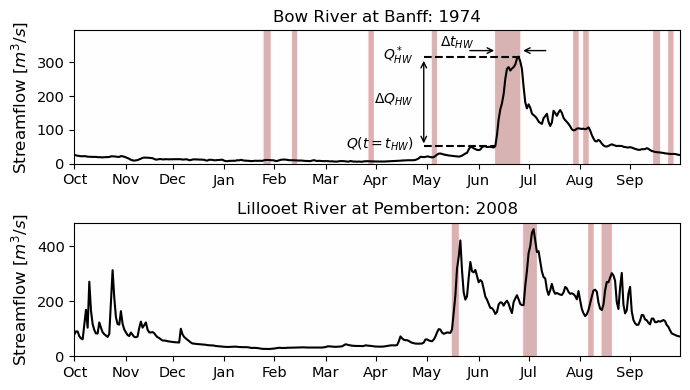

In [88]:
#visualize: individual years of streamflow and heatwaves

saveIt = 0

fs = 12

nrows = 2
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (7,4))

##### Bow

ax = axes[0]
year = 63
heatwave_vec = np.zeros(365)
hws_this_year = np.argwhere(hw_year[0]==year+data_start_years[0]+1).squeeze()
for hw in hws_this_year:
    heatwave_vec[int(t_hw[0][hw]):int(t_hw[0][hw]+hwd[0][hw])] = 1

ax.imshow(heatwave_vec.reshape(1,-1), aspect = 'auto', extent = [0,365,0,395], cmap = 'seismic', vmin = -1, alpha = 0.3)
ax.plot(Qyearly[0][year,:], 'k')

#annotate figure with labels etc
tt = int(t_hw[0][hws_this_year[4]])
ttf = tt + int(hwd[0][hws_this_year[4]])
Q_t_hw = Qyearly[0][year,tt]
Q_star = Qyearly[0][year,ttf]

ax.plot([210, tt], [Q_t_hw, Q_t_hw], 'k--')
ax.plot([210, ttf], [Q_star+12, Q_star+12], 'k--')

ax.text(x = 163, y = Q_t_hw-6, s = '$Q(t=t_{HW})$')
ax.text(x = 185.5, y = Q_star+5, s = '$Q^*_{HW}$')
ax.text(x = 180, y = 0.5*(Q_star - Q_t_hw) + Q_t_hw, s = '$\Delta Q_{HW}$')
ax.text(x = 220, y = 348, s = '$\Delta t_{HW}$')
ax.annotate(text = '', xy = (210,Q_t_hw), xytext = (210,Q_star+10), arrowprops=dict(arrowstyle="<->"))
ax.annotate(text = '', xy = (236,335), xytext = (tt+1,335), arrowprops=dict(arrowstyle="<-"))
ax.annotate(text = '', xy = (285,335), xytext = (ttf-0,335), arrowprops=dict(arrowstyle="<-"))

ax.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax.set_title('Bow River at Banff: ' + str(years[0] + data_start_years[0] + 1), fontsize = fs)


##### Lillooet

ax = axes[1]
year = 95 #107, 96
kk_station = 4

heatwave_vec = np.zeros(365)
hws_this_year = np.argwhere(hw_year[kk_station]==year+data_start_years[kk_station]+1).squeeze()
for hw in hws_this_year:
    heatwave_vec[int(t_hw[kk_station][hw]):int(t_hw[kk_station][hw]+hwd[kk_station][hw])] = 1
    
ax.imshow(heatwave_vec.reshape(1,-1), aspect = 'auto', extent = [0,365,0,500], cmap = 'seismic', vmin = -1, alpha = 0.3)
ax.plot(Qyearly[kk_station][year,:], 'k')

ax.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax.set_title('Lillooet River at Pemberton: ' + str(year + data_start_years[kk_station] + 1), fontsize = fs)

ax.set_xlim(left = 0,right = 364)
ax.set_ylim(top = 485)
ax.set_xticks(first_days_of_month)
ax.set_xticklabels(months_str, rotation = 0, fontsize = fs-2)
ax.tick_params(labelsize = fs-1.5)

##### FORMATTING
axes[0].set_ylim(top = 395)
for ax in axes:
    ax.set_xlim(left = 0,right = 364)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0, fontsize = fs-2)
    ax.tick_params(labelsize = fs-1.5)
    # ax.grid(True)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Q_labels_two_years_two_rivers.png', dpi = 400, bbox_inches = 'tight')

plt.show()

# Streamflow math  

#### Definitions

$Q^*$: Largest streamflow achieved during heatwave  
$Q(t=t_{HW})$: Streamflow at time of heatwave onset  
$t_{HW}$: Day of heatwave onset    
$T$: Temperature during heatwave  
$\Delta t$: Heatwave duration  
$\Delta Q$: Streamflow increase during heatwave  
$\beta$: Streamflow sensitivity to heatwave  
$\beta=\Delta Q/T\Delta t$
  

#### Case 1: Baseline   
$\underbrace{Q^*_1}_{peak} = \underbrace{Q_1(t=t_{HW})}_{seasonal} + \underbrace{\beta _1T_{1}\Delta t_1}_{heatwave}$  
  
Fraction heatwave $=\beta _1T_{1}\Delta t_1$ / $Q^*_1$  
  

#### Case 2: Future proxy
$\underbrace{Q^*_2}_{peak} = \underbrace{Q_2(t=t_{HW})}_{seasonal} + \underbrace{\beta _2T_{2}\Delta t_2}_{heatwave}$  
  
Fraction heatwave $=\beta _2T_{2}\Delta t_2$ / $Q^*_2$  
  

#### Plane equation
$\underbrace{Q^*_2 - Q^*_1}_{\Delta peak flow} = \underbrace{Q_2(t=t_{HW}) - Q_1(t=t_{HW})}_{\Delta seasonal} + \underbrace{\beta _2T_{2}\Delta t_2 - \beta _1T_{1}\Delta t_1}_{\Delta heatwave}$  
  
$z = ax+by+c$  
$z = Q^*_2 - Q^*_1$  
$a = - \beta _1(t)$  
$b = \beta _2(t)$  
$c = Q_2(t=t_{HW}) - Q_1(t=t_{HW})$  
$x = T_{1}\Delta t_1$  
$y = T_{2}\Delta t_2$  


# Seasonal and heatwave reservoirs / fractions

In [90]:
#calculate planes for each day

#initialize 
beta1 = np.zeros((Nsites, 365)) #baseline
beta2 = np.zeros((Nsites, 365)) #future proxy
a = np.zeros((Nsites, 365))
b = np.zeros((Nsites, 365))
c = np.zeros((Nsites, 365))

#discretize
Nx = 25
Ny = 25
Nt = 365
xmax = 2500
ymax = 2500
x = np.linspace(0,xmax,Nx)
y = np.linspace(0,ymax,Ny)
z = np.zeros((Nsites,Ny,Nx,Nt)) #rows x columns x time
y0 = np.zeros((Nsites,Nx,Nt)) #solution that sets z = 0
t_hw_x = np.zeros((Nsites,Nx,Nt))

for kk_site in range(Nsites): #for each site

    beta1[kk_site,:] = dQdT_rolling_baseline[kk_site]
    beta2[kk_site,:] = dQdT_rolling_future_proxy[kk_site]
    a[kk_site,:] = -beta1[kk_site,:]
    b[kk_site,:] = beta2[kk_site,:]
    c[kk_site,:] = Q_diff_freshet_rolling[kk_site]

    for kt in range(Nt): #for each day
        for kx in range(Nx): #for each x step
            t_hw_x[kk_site,kx,kt] = x[kx] / (Tmean_90[kk_site][kt] + 273) #convert to t_hw
            y0[kk_site,kx,kt] = -(a[kk_site,kt]/b[kk_site,kt])*x[kx] - (c[kk_site,kt]/b[kk_site,kt]) #solve for y that satisfies z = 0
            for ky in range(Ny): #for each y step
                z[kk_site,ky,kx,kt] = a[kk_site,kt]*x[kx] + b[kk_site,kt]*y[ky] + c[kk_site,kt] #z = ax + by + c
                

In [91]:
#consider fast (heatwave; a*x) and slow (seasonal; b*y) reservoirs in baseline (1) and future proxy years (2)

#initialize
fast1 = np.zeros((Nsites,Nx,365))
fast2 = np.zeros((Nsites,Nx, 365))
frac_fast_baseline = np.zeros((Nsites,Nx,365))
frac_fast_future_proxy = np.zeros((Nsites,Nx,365))

for kk_site in range(Nsites): #for each site
    for kx in range(Nx): #for each x step

        fast1[kk_site,kx,:] = (a[kk_site,:]*x[kx]) 
        fast2[kk_site,kx,:] = (b[kk_site,:]*y[kx])

        frac_fast_baseline[kk_site,kx,:] = -fast1[kk_site,kx,:] / (-fast1[kk_site,kx,:] + Q_baseline_rolling[kk_site,:])
        frac_fast_future_proxy[kk_site,kx,:] = fast2[kk_site,kx,:] / (fast2[kk_site,kx,:] + Q_future_proxy_rolling[kk_site,:])

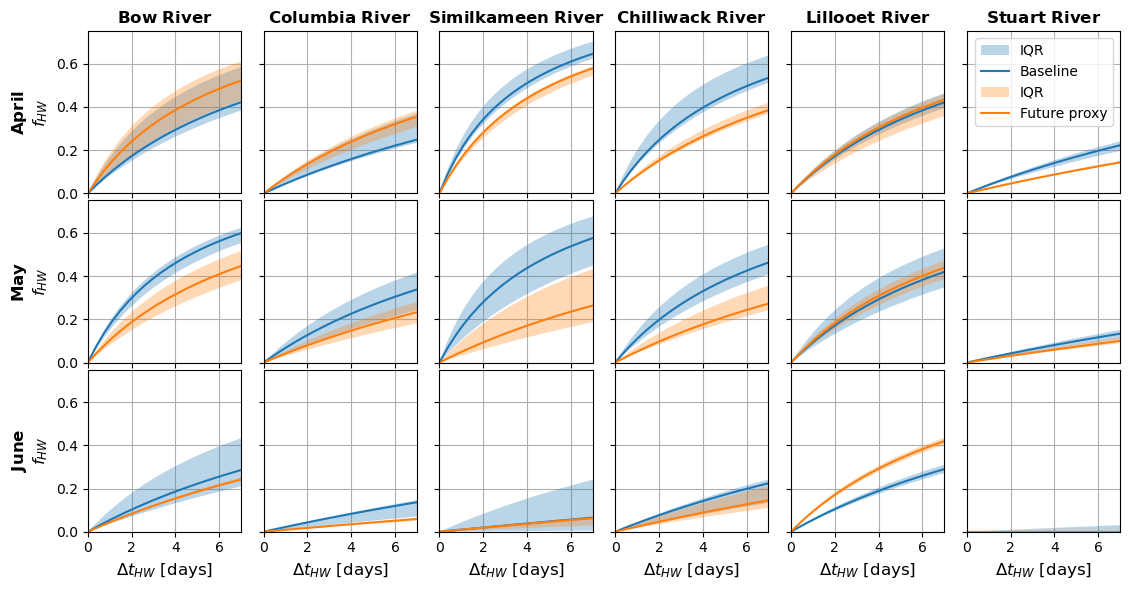

In [92]:
#visualize the heatwave fraction by month through the freshet, as a function of heatwave duration, for each site

saveIt = 0

kk_months = [6,7,8]

labels = ['April', 'May', 'June']

ncols = Nsites
nrows = len(kk_months)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.9*ncols, 2*nrows))

for kk_site in range(Nsites): #for each site
    
    for kk_ax, kk_month in enumerate(kk_months): #for each month in freshet

        ax = axes[kk_ax,kk_site]

        kk_days = np.arange(kk_month*30,(kk_month+1)*30)
        
        #calculate average and variability for future proxy and baseline
        vars = [frac_fast_baseline[kk_site], frac_fast_future_proxy[kk_site]]
        var1 = np.median(vars[0][:,kk_days], axis = 1)
        var1p1 = np.percentile(vars[0][:,kk_days], q = 25, axis = 1)
        var1p2 = np.percentile(vars[0][:,kk_days], q = 75, axis = 1)
        var2 = np.median(vars[1][:,kk_days], axis = 1)
        var2p1 = np.percentile(vars[1][:,kk_days], q = 25, axis = 1)
        var2p2 = np.percentile(vars[1][:,kk_days], q = 75, axis = 1)
        
        t_hw_xx = np.mean(t_hw_x[kk_site,:,kk_days], axis = 0)

        ax.fill_between(x = t_hw_xx, y1 = var1p1, y2 = var1p2, alpha = 0.3, label = 'IQR')
        ax.plot(t_hw_xx,var1, label = 'Baseline')

        ax.fill_between(x = t_hw_xx, y1 = var2p1, y2 = var2p2, alpha = 0.3, label = 'IQR')
        ax.plot(t_hw_xx,var2, label = 'Future proxy')

        #formatting
        if kk_month == kk_months[0]:
            ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
            if kk_site == Nsites-1:
                ax.legend(fontsize = fs-2)
        ax.set_xlim(left = 0, right = 7)
        ax.set_xticks(np.arange(7)[::2])
        ax.set_yticks(np.linspace(0,0.7,8)[::2])
        ax.set_ylim(bottom = 0, top = 0.75)
        ax.grid(True)
        ax.set_axisbelow(True)
        if kk_ax < 2: #remove x tick labels for all but bottom row
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('$\Delta t_{HW}$ [days]', fontsize = fs)
        if kk_site > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$\bf{' + labels[kk_ax] + '}$\n$f_{HW}$', fontsize = fs)# = \u03B2$ $T_{HW}\Delta t_{HW}$ / $Q^*$')
            
plt.tight_layout(h_pad = -0.1, w_pad = 0.3)

if saveIt:
    plt.savefig('Figures/frac_fast2.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

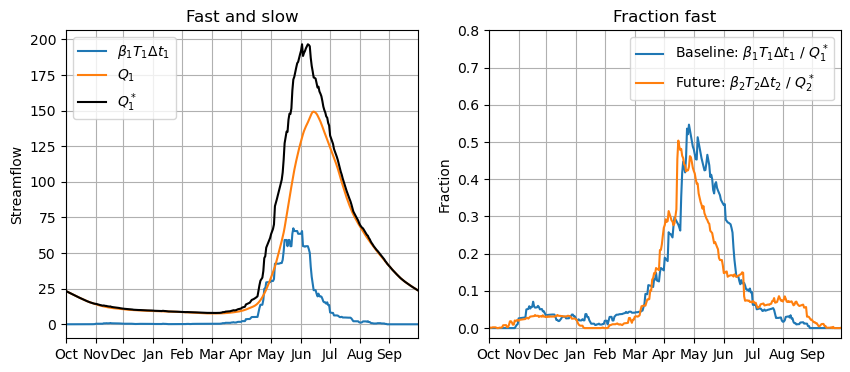

In [ ]:
#visualize heatwave, seasonal, and peak flow

kk_site = 0
kx = 10

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

ax = axes[0]
ax.plot(-fast1[kk_site,kx,:], label = '$\u03B2 _1T_{1}\Delta t_{1}$')
ax.plot(Q_baseline_rolling[kk_site], label = '$Q_1$')
ax.plot(-fast1[kk_site,kx,:] + Q_baseline_rolling[kk_site], label = '$Q^*_1$', color = 'k')
ax.set_ylabel('Streamflow')
ax.set_title('Fast and slow')
ax.legend()

ax = axes[1]
ax.plot(frac_fast_baseline[kk_site,kx,:], label = 'Baseline: $\u03B2 _1T_{1}\Delta t_{1}$ / $Q^*_1$')
ax.plot(frac_fast_future_proxy[kk_site,kx,:], label = 'Future: $\u03B2 _2T_{2}\Delta t_{2}$ / $Q^*_2$')
ax.set_ylabel('Fraction')
ax.set_title('Fraction fast')
ax.set_ylim(top = 0.8)
ax.legend()

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

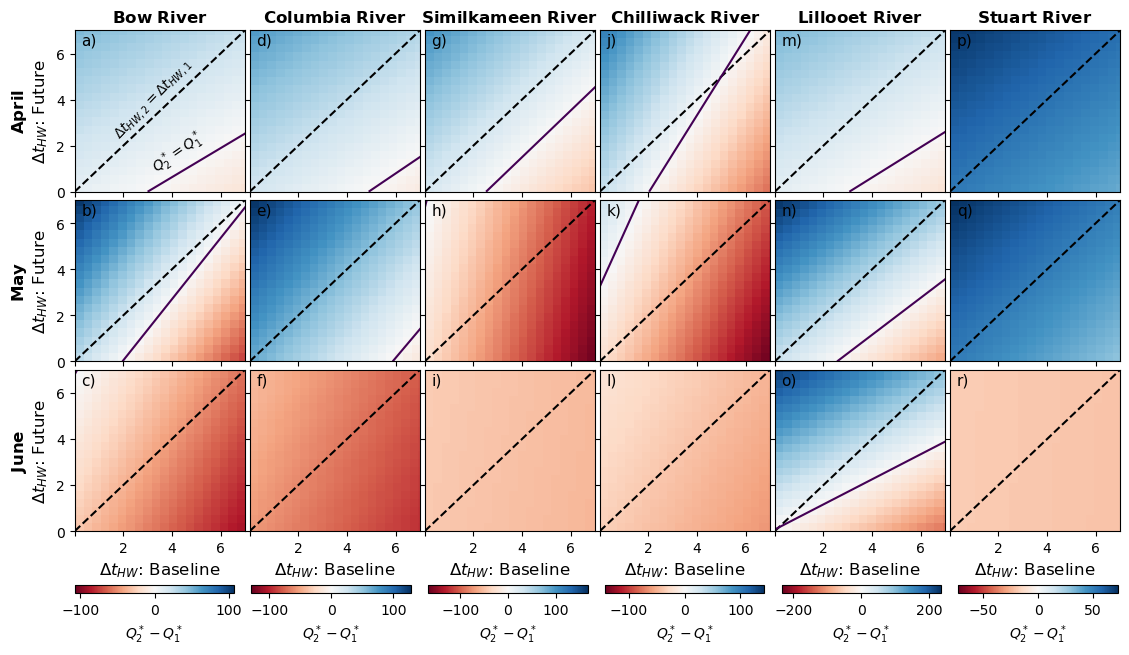

In [94]:
#visualize monthly Q* planes for each site

saveIt = 0

days = np.array([183, 213, 244], dtype = 'int') #first days of months in freshet
Ndays = len(days)

labels = ['April', 'May', 'June']

nrows = Ndays
ncols = Nsites

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.9*ncols, 2*nrows))

jj = 0

#calculate 30-day rolling heatwave threshold, for scaling x- and y- axes to be in units of time
Tmean_90_rolling = np.zeros((Nsites,365))
for kk_site in range(Nsites):
    Tmean_90_rolling[kk_site,:] = np.array([np.mean(Tmean_90[kk_site,day:day+30]) for day in range(365)])

for kk_site in range(Nsites): #for each site
    
    vmax = np.max([np.abs(np.mean(z[kk_site,:-4,:-4,days[kk]:days[kk]+30], axis = -1)) for kk in range(3)])
    vmin = -vmax

    for kk_day in range(Ndays): #for each start day
        
        ax = axes[kk_day, kk_site]

        kt = int(days[kk_day])
        xscale = Tmean_90_rolling[kk_site,kt] + 273
        extent = [min(x)/xscale, max(x)/xscale, min(y)/xscale, max(y)/xscale]
        var = np.mean(z[kk_site,:,:,kt:kt+30],axis = -1)
        i = ax.imshow(var, aspect = 'auto', extent = extent, origin = 'lower', cmap = 'RdBu', vmin = vmin, vmax = vmax)

        ax.plot([0,xmax/xscale],[0,ymax/xscale], 'k--') #1-1 line
        ax.contour(x/xscale, y/xscale, var, levels = np.array([0])) #z = 0 line

        #formatting
        ax.set_xlim(left = 0, right = 7)
        ax.set_ylim(bottom = 0, top = 7)
        ax.set_xticks([0,2,4,6])
        ax.set_xticklabels([None,2,4,6])
        year = '2019'
        if kt < 10:
            day_num = '0' + str((kt - 92)%365)
        else:
            day_num = str((kt - 92)%365)   
        res = datetime.datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%B-%d-%Y")[:-5]
        ax.set_xlabel('$\Delta t_{HW}$: Baseline', fontsize = fs)

        if kk_day == Ndays-1: 
            #add colourbar to bottom subplot of each column
            cbar_ax = fig.add_axes([0.155*kk_site+0.07, -0., 0.14, 0.1])
            cbar_ax.axis('off')
            cb = fig.colorbar(i, ax=cbar_ax, orientation = 'horizontal')
            cb.ax.set_xlabel('$Q^*_2-Q^*_1$')           
        else:           
            #remove x-axis labels from all but the last row
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            
        if kk_site > 0:            
            #remove y-axis labels from all but the first column
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        else:
            ax.set_ylabel(r'$\bf{' + labels[kk_day] + '}$\n$\Delta t_{HW}$: Future', fontsize = fs)
        
        if kk_day == 0:
            #put river name in title of first row
            ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
            
        ax.text(x = 0.04, y = 0.91, s = abc[jj], transform = ax.transAxes, fontsize = fs-1)
        jj+=1
        
axes[0,0].text(x = 3, y = 0.9, s = '$Q_2^* = Q_1^*$', rotation = 35)
axes[0,0].text(x = 1.5, y = 2.4, s = '$\Delta t_{HW,2}= \Delta t_{HW,1}$', rotation = 46)

plt.tight_layout(h_pad = -0, w_pad = 0.)

if saveIt:
    plt.savefig('Figures/Qstar_planes.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

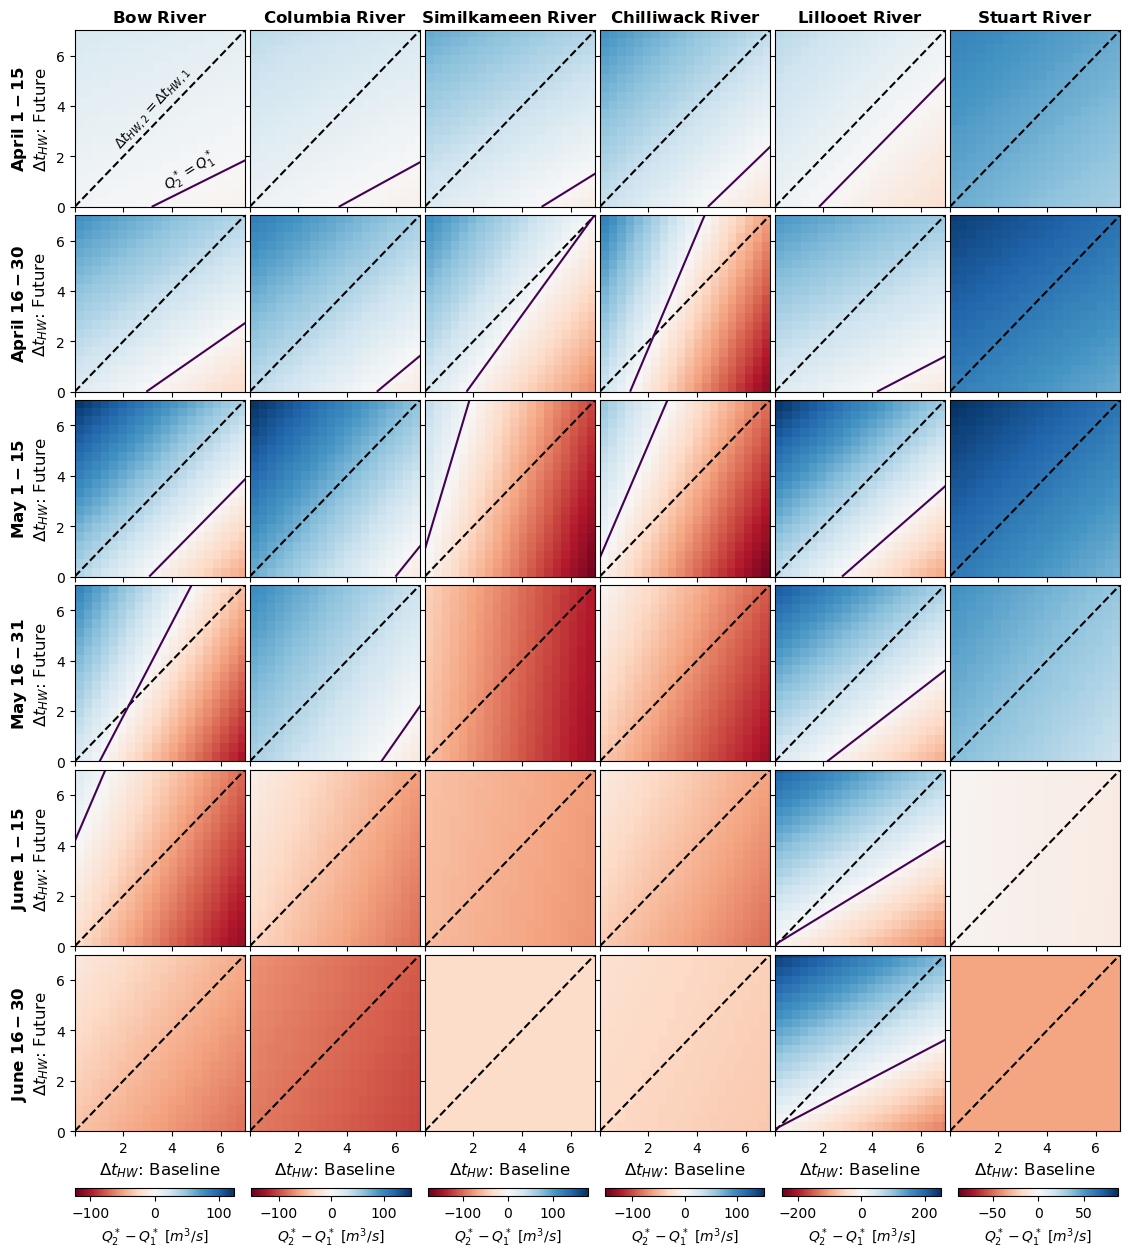

In [95]:
#visualize Q* planes: two week segments through the freshet

saveIt = 0

days = np.array([183, 198, 213, 229, 244, 259], dtype = 'int') #starting days of each 2 week segment
Ndays = len(days)

labels = ['April 1 - 15', 'April 16 - 30','May 1 - 15', 'May 16 - 31', 'June 1 - 15', 'June 16 - 30']
labels_month = ['April', 'April', 'May', 'May', 'June', 'June']
labels_day = ['1 - 15', '16 - 30','1 - 15', '16 - 31', '1 - 15', '16 - 30']

nrows = Ndays
ncols = Nsites

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.9*ncols, 2*nrows))

jj = 0

for kk_site in range(Nsites): #for each site
    
    vmax = np.max([np.abs(np.mean(z[kk_site,:-4,:-4,days[kk]:days[kk]+15], axis = -1)) for kk in range(3)])
    vmin = -vmax

    for kk_day in range(Ndays): #for each start day
        
        ax = axes[kk_day, kk_site]

        kt = int(days[kk_day])
        xscale = Tmean_90_rolling[kk_site,kt] + 273
        extent = [min(x)/xscale, max(x)/xscale, min(y)/xscale, max(y)/xscale]
        var = np.mean(z[kk_site,:,:,kt:kt+15],axis = -1)
        i = ax.imshow(var, aspect = 'auto', extent = extent, origin = 'lower', cmap = 'RdBu', vmin = vmin, vmax = vmax)

        ax.plot([0,xmax/xscale],[0,ymax/xscale], 'k--')
        ax.contour(x/xscale, y/xscale, var, levels = np.array([0]))

        #formatting
        ax.set_xlim(left = 0, right = 7)
        ax.set_ylim(bottom = 0, top = 7)
        ax.set_xticks([0,2,4,6])
        ax.set_xticklabels([None,2,4,6])
        year = '2019'
        if kt < 10:
            day_num = '0' + str((kt - 92)%365)
        else:
            day_num = str((kt - 92)%365)       
        res = datetime.datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%B-%d-%Y")[:-5]
        ax.set_xlabel('$\Delta t_{HW}$: Baseline', fontsize = fs)

        if kk_day == Ndays-1: 
            #add colourbar to bottom subplot of each column
            cbar_ax = fig.add_axes([0.155*kk_site+0.07, -0.01, 0.14, 0.1])
            cbar_ax.axis('off')
            cb = fig.colorbar(i, ax=cbar_ax, orientation = 'horizontal')
            cb.ax.set_xlabel('$Q^*_2-Q^*_1$ $[m^3/s]$')           
        else:           
            #remove x-axis labels from all but the last row
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            
        if kk_site > 0:            
            #remove y-axis labels from all but the first column
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        else:
            ax.set_ylabel(r'$\bf{' + labels[kk_day] + '}$\n$\Delta t_{HW}$: Future', fontsize = fs)
            ax.set_ylabel(r'$\bf{' + labels_month[kk_day] + '}$' + r' $\bf{' + labels_day[kk_day] + '}$\n$\Delta t_{HW}$: Future', fontsize = fs)
        
        if kk_day == 0:
            #put river name in title of first row
            ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
            
        jj+=1
        
axes[0,0].text(x = 3.5, y = 0.7, s = '$Q_2^* = Q_1^*$', rotation = 32.5)
axes[0,0].text(x = 1.5, y = 2.4, s = '$\Delta t_{HW,2}= \Delta t_{HW,1}$', rotation = 48)

plt.tight_layout(h_pad = -0, w_pad = 0.)

if saveIt:
    plt.savefig('Figures/Qstar_planes_biweekly3.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

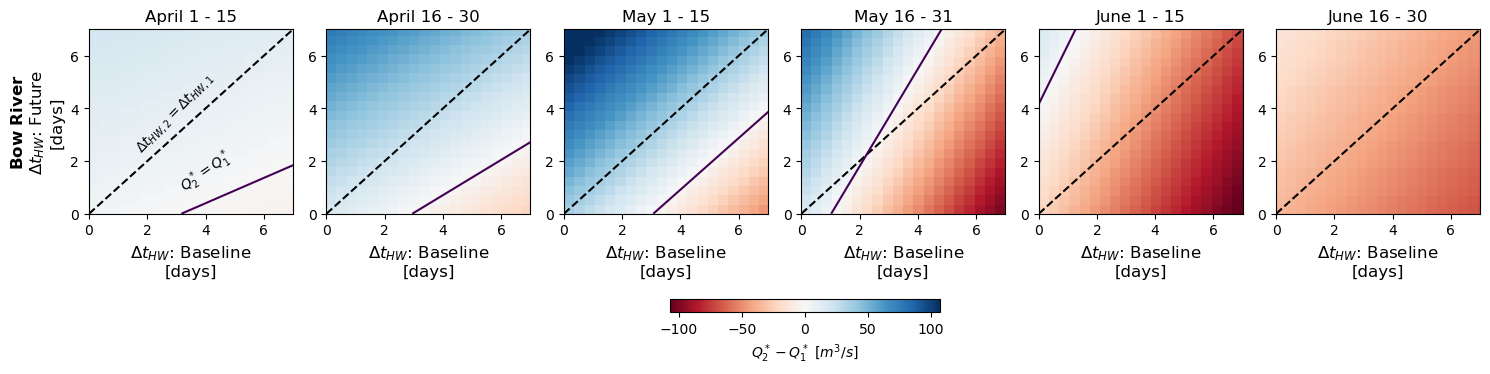

In [96]:
#visualize Q* planes, but for a single site

saveIt = 0

days = np.array([183, 198, 213, 229, 244, 259], dtype = 'int')
Ndays = len(days)

labels = ['April 1 - 15', 'April 16 - 30','May 1 - 15', 'May 16 - 31', 'June 1 - 15', 'June 16 - 30']

nrows = 1
ncols = 6

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (2.5*ncols, 3*nrows))

jj = 0

for kk_site in range(1): #for each site
    
    vmax = np.max([np.abs(np.mean(z[kk_site,:-4,:-4,days[kk]:days[kk]+30], axis = -1)) for kk in range(3)])
    vmin = -vmax

    for kk_day in range(Ndays):
        
        ax = axes[kk_day]

        kt = int(days[kk_day])
        xscale = Tmean_90_rolling[kk_site,kt] + 273
        extent = [min(x)/xscale, max(x)/xscale, min(y)/xscale, max(y)/xscale]
        var = np.mean(z[kk_site,:,:,kt:kt+15],axis = -1)
        i = ax.imshow(var, aspect = 'auto', extent = extent, origin = 'lower', cmap = 'RdBu', vmin = vmin, vmax = vmax)

        ax.plot([0,xmax/xscale],[0,ymax/xscale], 'k--')
        ax.contour(x/xscale, y/xscale, var, levels = np.array([0]))

        #formatting
        ax.set_xlim(left = 0, right = 7)
        ax.set_ylim(bottom = 0, top = 7)
        year = '2019'
        if kt < 10:
            day_num = '0' + str((kt - 92)%365)
        else:
            day_num = str((kt - 92)%365)   
        res = datetime.datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%B-%d-%Y")[:-5]
        ax.set_xlabel('$\Delta t_{HW}$: Baseline\n[days]', fontsize = fs)

        if kk_day == Ndays-1: 
            #add colourbar to bottom subplot of each column
            cbar_ax = fig.add_axes([0.29, -0.06, 0.5, 0.3])
            cbar_ax.axis('off')
            cb = fig.colorbar(i, ax=cbar_ax, orientation = 'horizontal')
            cb.ax.set_xlabel('$Q^*_2-Q^*_1$ [$m^3/s$]')           
            
        if kk_day > 0:            
            #remove y-axis labels from all but the first column
            ax.set_ylabel(None)
        else:
            # ax.set_ylabel(r'$\bf{' + res + '}$\n$\Delta t_{HW}$: Future')
            ax.set_ylabel(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$\n$\Delta t_{HW}$: Future\n[days]', fontsize = fs)
        
        if kk_site == 0:
            #put river name in title of first row
            ax.set_title(labels[kk_day], fontsize = fs)
            
        jj+=1
        
axes[0].text(x = 3, y = 0.9, s = '$Q_2^* = Q_1^*$', rotation = 35)
axes[0].text(x = 1.5, y = 2.4, s = '$\Delta t_{HW,2}= \Delta t_{HW,1}$', rotation = 46)

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/Qstar_planes_bow_biweekly.png', dpi = 450, bbox_inches = 'tight')
    
plt.show()

# Supplementary 

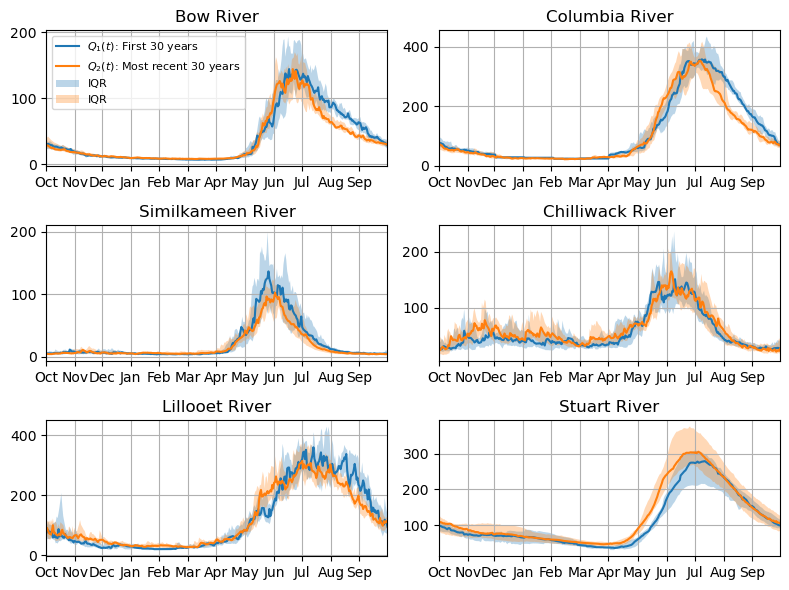

In [97]:
#visualize: what if we split years by time, not by freshet/snow characteristics?

saveIt = 0

nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

ind_sets = [np.arange(20), np.arange(-20,0,1)]

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
for kk_site, ax in enumerate(axes.flatten()):
    
    ax.set_title(sites_short[kk_site])

    #plot average of early and late freshet years
    ax.plot(np.nanmedian(Qyearly[kk_site][ind_sets[0],:],axis = 0), label = '$Q_1(t)$: First 30 years')
    ax.plot(np.nanmedian(Qyearly[kk_site][ind_sets[1],:],axis = 0), label = '$Q_2(t)$: Most recent 30 years')

    p1 = 25
    p2 = 75
    y1 = np.nanpercentile(Qyearly[kk_site][ind_sets[1],:], q = p1, axis = 0)
    y2 = np.nanpercentile(Qyearly[kk_site][ind_sets[1],:], q = p2, axis = 0)
    y3 = np.nanpercentile(Qyearly[kk_site][ind_sets[0],:], q = p1, axis = 0)
    y4 = np.nanpercentile(Qyearly[kk_site][ind_sets[0],:], q = p2, axis = 0)
    ax.fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR')
    ax.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR')

axes[0,0].legend(fontsize = fs-4)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/streamflow_regimes_time_separation.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [123]:
#define a function that calculates the number of heatwaves in baseline / future proxy years, considering a precip threshold
def get_N_hws(df_sites, Nsites, sites, Nyears_sites, Tmean_90, P_running, freshet_day, years_future_proxy, years_baseline, P_threshold):
    
    #calculate:
    #when are heatwaves?
    #what are the qualities and meteorological characteristics of all heatwaves?

    hws = [[] for kk in range(Nsites)]
    Tmean_exceedance = []

    for kk_site, site in enumerate(sites):

        df_weather = df_sites['Weather_stations'][site]
        df_flow = df_sites['Streamflow'][site]
        Nyears = Nyears_sites[kk_site]
        data_start_year = df_sites['Year_start'][site]
        Q = df_flow['Value']
        Tmean = df_weather['Mean Temp (°C)']
        Tx = df_weather['Max Temp (°C)']
        Tn = df_weather['Min Temp (°C)']
        Ndays = len(Q)

        #temp exceedance and anomaly
        Tmean_90_4year = np.concatenate([Tmean_90[kk_site],Tmean_90[kk_site],Tmean_90[kk_site],np.array([Tmean_90[kk_site][-1]]),Tmean_90[kk_site]]) #3 normal years and 1 leap year in 1912
        Tmean_90_vector = np.tile(Tmean_90_4year,29)[:len(Q)]
        Tmean_exceedance.append(Tmean - Tmean_90_vector)

        inds_hotter_90 = np.argwhere([Tmean > Tmean_90_vector])[:,1]
        is_heatwave = np.zeros(Ndays)

        #determine the indices of all heatwave days in temperature record
        for kk,ind in enumerate(inds_hotter_90[2:]):
            if (inds_hotter_90[2:][kk-2]==ind-2) & (inds_hotter_90[2:][kk-1]==ind-1): #if prior two days were also >90th percentile
                if P_running[kk_site][ind] < P_threshold: #if less than 2mm rain the past 7 days
                    if (np.isnan(Q[ind]) == False) & (np.isnan(Q[ind-1]) == False) & (np.isnan(Q[ind-2]) == False): #if streamflow data is available
                        is_heatwave[ind] = 1
                        is_heatwave[ind-1] = 1
                        is_heatwave[ind-2] = 1
        inds_heatwave = np.argwhere(is_heatwave==1)

        #define heatwaves as events, defined by a start day and end day

        jj_hw = 0
        hws[kk_site] = np.zeros([6000,2])
        hws[kk_site][0,0] = inds_heatwave[0]
        for kk, ind in enumerate(inds_heatwave[:-1]):
            if inds_heatwave[kk+1] != ind + 1: #if the next heatwave day is not the following day, it means we have reached the end of this heatwave
                hws[kk_site][jj_hw,1] = ind #final day of current heatwave is the present day
                hws[kk_site][jj_hw+1,0] = inds_heatwave[kk+1] #first day of next heatwave is the next heatwave day
                jj_hw+=1
        hws[kk_site] = hws[kk_site][:jj_hw-1,:] #clip final hw (end day of final hw is day 0)

    #hw stats
    Nhws = [len(hh) for hh in hws]
    t_hw = [np.zeros(nn) for nn in Nhws]  #timing (day of year)
    
    year_categories_hw = [np.zeros(nn) for nn in Nhws] #0: basic year; 1: baseline; 2: future proxy

    dQ_hw = [np.zeros(nn) for nn in Nhws] #change in streamflow (m3/s)
    dQdT_hw = [np.zeros(nn) for nn in Nhws]
    Qinit = [np.zeros(nn) for nn in Nhws]
    Qfinal = [np.zeros(nn) for nn in Nhws]

    Tmean_hw = [np.zeros(nn) for nn in Nhws]  #mean temp during heatwave (degrees)

    hw_year = [np.zeros(nn) for nn in Nhws]
    hw_month = [np.zeros(nn) for nn in Nhws]

    future_proxy_hw = [np.zeros(nn) for nn in Nhws]
    baseline_hw = [np.zeros(nn) for nn in Nhws]

    inds_future_proxy_hw = []
    inds_baseline_hw = []

    for kk_site, site in enumerate(sites):

        Q = df_flow['Value']
        Ndays = len(Q)
        df_weather =  df_sites['Weather_stations'][site]
        data_start_year = df_sites['Year_start'][site] + 1

        for kk_hw in range(Nhws[kk_site]):

            day_start = int(hws[kk_site][kk_hw][0])
            day_final = int(hws[kk_site][kk_hw][1])

            t_hw[kk_site][kk_hw] = df_weather['Day_of_year'][day_start] #day of year
            hw_year[kk_site][kk_hw] = int(df_weather.iloc[day_start]['Year'])
            hw_month[kk_site][kk_hw] = df_weather.index[day_start].month
            
        #freshet stuff
        for kk_hw, year in enumerate(hw_year[kk_site]-data_start_year):
            if year < Nyears_sites[kk_site]-1:
                if np.size(np.argwhere(year==years_future_proxy[kk_site]))>0:
                    future_proxy_hw[kk_site][kk_hw] = 1
                elif np.size(np.argwhere(year==years_baseline[kk_site]))>0:
                    baseline_hw[kk_site][kk_hw] = 1

        inds_future_proxy_hw.append(np.argwhere(future_proxy_hw[kk_site] == 1).squeeze())
        inds_baseline_hw.append(np.argwhere(baseline_hw[kk_site] == 1).squeeze())

    N_future_proxy_hw = np.zeros((Nsites,365))
    N_baseline_hw = np.zeros((Nsites,365))

    bin_width = 30

    for kk_site, site in enumerate(sites):

        for day_start in range(0,365):

            if day_start < 335:

                inds_daily = np.arange(day_start,day_start + bin_width)

                inds_bin_future_proxy = np.argwhere(
                    (t_hw[kk_site][inds_future_proxy_hw[kk_site]] >= day_start) & 
                    (t_hw[kk_site][inds_future_proxy_hw[kk_site]] < day_start + bin_width)
                ).squeeze()

                inds_bin_baseline = np.argwhere(
                    (t_hw[kk_site][inds_baseline_hw[kk_site]] >= day_start) & 
                    (t_hw[kk_site][inds_baseline_hw[kk_site]] < day_start + bin_width)
                ).squeeze()

                inds_bin_all = np.argwhere(
                    (t_hw[kk_site] >= day_start) & 
                    (t_hw[kk_site] < day_start + bin_width)
                ).squeeze()

            else:

                N_rollover_days = 30 - (365 - day_start)

                inds_daily = np.concatenate([np.arange(N_rollover_days), np.arange(day_start,365)])

                inds_bin_future_proxy = np.argwhere(
                    (t_hw[kk_site][inds_future_proxy_hw[kk_site]] >= day_start) | 
                    (t_hw[kk_site][inds_future_proxy_hw[kk_site]] < N_rollover_days)
                ).squeeze()

                inds_bin_baseline = np.argwhere(
                    (t_hw[kk_site][inds_baseline_hw[kk_site]] >= day_start) | 
                    (t_hw[kk_site][inds_baseline_hw[kk_site]] < N_rollover_days)
                ).squeeze()

                inds_bin_all = np.argwhere(
                    (t_hw[kk_site] >= day_start) | 
                    (t_hw[kk_site] < N_rollover_days)
                ).squeeze()

            N_future_proxy_hw[kk_site,day_start] = np.size(inds_bin_future_proxy)
            N_baseline_hw[kk_site,day_start] = np.size(inds_bin_baseline)
    
    return N_future_proxy_hw, N_baseline_hw

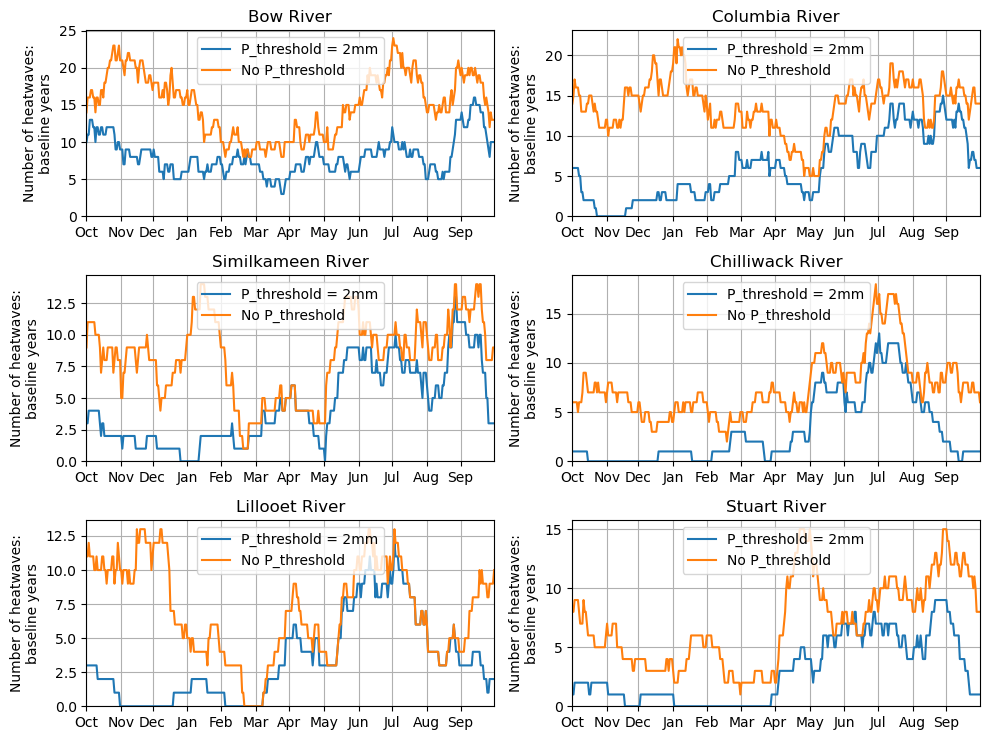

In [125]:
#NUMBER HEATWAVES AS A FUNCTION OF PRECIP THRESHOLD

saveIt = 0

P_thresholds = np.array([2,200]) #different precip thresholds to consider
N_P = len(P_thresholds)
N_baseline_hw = np.zeros((Nsites,365,N_P))

#for each precip threshold, calculate number of future proxy and baseline heatwaves through time
for kk_P, P_threshold in enumerate(P_thresholds):
    N_future_proxy_hw, N_baseline_hw[:,:,kk_P] = get_N_hws(df_sites, Nsites, sites, Nyears_sites, Tmean_90, P_running, freshet_day, years_future_proxy, years_baseline, P_threshold)
    
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2.5*nrows))

labels = ['P_threshold = ' + str(P_thresholds[0]) + 'mm',
          'No P_threshold']

for kk_site, ax in enumerate(axes.flatten()[:Nsites]): #for each site
    
    for kk_P, P_threshold in enumerate(P_thresholds): #for each precip threshold
        ax.plot(N_baseline_hw[kk_site,:,kk_P], label = labels[kk_P])
    ax.set_title(sites_short[kk_site])
    ax.legend(loc = 'upper center')
    ax.set_ylabel('Number of heatwaves:\nbaseline years')

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/N_hws_precip.png', dpi = 300, bbox_inches = 'tight')

In [126]:
np.mean(N_baseline_hw[:,:,0]), np.mean(N_baseline_hw[:,:,1])

(4.657534246575342, 9.780821917808218)

In [127]:
np.std(N_baseline_hw[:,:,0]), np.std(N_baseline_hw[:,:,1])

(3.7203102122418756, 4.815632578661945)

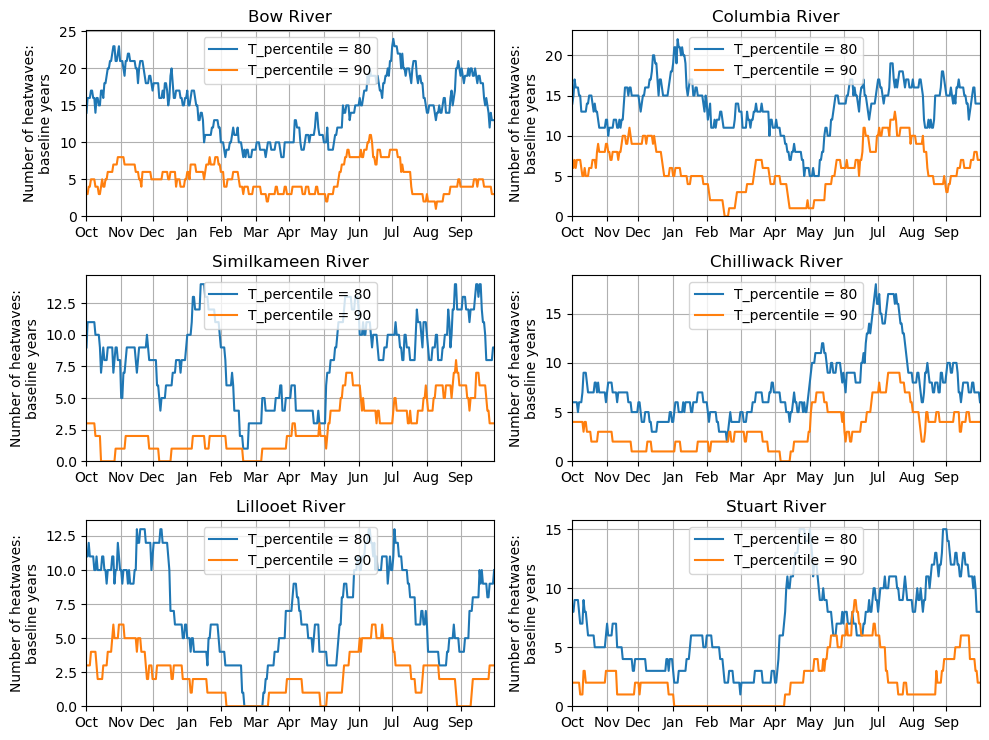

In [129]:
#NUMBER HEATWAVES AS A FUNCTION OF TEMPERATURE PERCENTILE

saveIt = 0

P_threshold = 200
T_percentile_thresholds = np.array([80,90]) #temp percentile thresholds
N_T = len(T_percentile_thresholds)
N_baseline_hw = np.zeros((Nsites,365,N_T))

#calculate number of events for rolling 30-day windows
for kk_T, T_percentile_threshold in enumerate(T_percentile_thresholds):
    
    #calculate rolling temperature percentile threshold
    Tmean_p = np.zeros((Nsites,365))

    #loop through each site
    for kk_site, site in enumerate(sites):
        df_weather = df_sites['Weather_stations'][site]
        Tmean = df_weather['Mean Temp (°C)']
        for day in range(365):
            if day<7:
                day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
            elif day + 7 >= 365:
                day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
            else:
                day_range = np.arange(day - 7, day + 8)
            Tmean_range = []
            for kk, dd in enumerate(day_range):
                Tmean_range.extend(Tmean[df_weather['Day_of_year'] == dd].values)
            Tmean_p[kk_site,day] = np.nanpercentile(Tmean_range, q = T_percentile_threshold)
    
    N_future_proxy_hw, N_baseline_hw[:,:,kk_T] = get_N_hws(df_sites, Nsites, sites, Nyears_sites, Tmean_p, P_running, freshet_day, years_future_proxy, years_baseline, P_threshold)
 
#visualize
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2.5*nrows))

labels = ['T_percentile = ' + str(tt) for tt in T_percentile_thresholds]

for kk_site, ax in enumerate(axes.flatten()[:Nsites]): #for each site
    
    for kk_T, T_threshold in enumerate(T_percentile_thresholds): #for each T threshold
        ax.plot(N_baseline_hw[kk_site,:,kk_T], label = labels[kk_T])
    ax.set_title(sites_short[kk_site])
    ax.legend(loc = 'upper center')
    ax.set_ylabel('Number of heatwaves:\nbaseline years')

#formatting
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
  
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/N_hws_T_threshold.png', dpi = 300, bbox_inches = 'tight')

In [130]:
np.mean(N_baseline_hw[:,:,0]), np.mean(N_baseline_hw[:,:,1])

(9.780821917808218, 3.6027397260273974)

In [131]:
np.std(N_baseline_hw[:,:,0]), np.std(N_baseline_hw[:,:,1])

(4.815632578661945, 2.614534677654761)

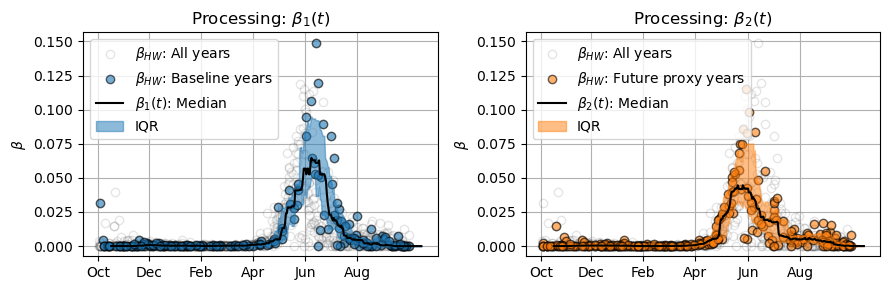

In [133]:
#figure showing preprocessing -- individual betas --> median + shading

saveIt = 0

kk_site = 0

nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4.5*ncols, 3*nrows))

##### BASELINE
ax = axes[0]

#ALL YEARS
x = t_hw[kk_site]
y = dQdT_hw[kk_site]
ax.scatter(x, y, edgecolor = 'k', facecolor = 'w', alpha = 0.1, label = '$\u03B2_{HW}$: All years')

#BASELINE YEARS
inds = np.argwhere(year_categories_hw[kk_site]==1).squeeze() #baseline
x = t_hw[kk_site][inds]
y = dQdT_hw[kk_site][inds]
ax.scatter(x, y, edgecolor = 'k', alpha = 0.6, label = '$\u03B2_{HW}$: Baseline years')
ax.plot(np.arange(365)+15, dQdT_rolling_baseline[kk_site], 'k', label = '$\u03B2 _1(t)$: Median')
ax.fill_between(x = np.arange(365)+15, y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.5, color='#1f77b4', label = 'IQR')
ax.set_title('Processing: $\u03B2_1(t)$')

##### FUTURE PROXY
ax = axes[1]

#ALL YEARS
x = t_hw[kk_site]
y = dQdT_hw[kk_site]
ax.scatter(x, y, edgecolor = 'k', facecolor = 'w', alpha = 0.1, label = '$\u03B2_{HW}$: All years')

#FUTURE PROXY YEARS
inds = np.argwhere(year_categories_hw[kk_site]==2).squeeze() #baseline
x = t_hw[kk_site][inds]
y = dQdT_hw[kk_site][inds]
ax.scatter(x, y, edgecolor = 'k', alpha = 0.6, label = '$\u03B2_{HW}$: Future proxy years', color = '#ff7f0e')
ax.plot(np.arange(365)+15, dQdT_rolling_future_proxy[kk_site], 'k', label = '$\u03B2 _2(t)$: Median')
ax.fill_between(x = np.arange(365)+15, y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.5, color = '#ff7f0e', label = 'IQR')
ax.set_title('Processing: $\u03B2_2(t)$')

#FIGURE DETAILS
for ax in axes:
    ax.set_ylabel('$\u03B2$')
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    ax.legend()

plt.tight_layout()
    
if saveIt:
    plt.savefig('Figures/Supplementary/processing.png', bbox_inches = 'tight', dpi = 300)
    
plt.show()

In [134]:
##### CMIP6: https://climate-scenarios.canada.ca/?page=cmip6-scenarios

cmip6_dir = '/Users/samanderson/repos/heatwave_obs/Data/CMIP6/'

year_ranges = ['2021-2040',
              '2041-2060',
              '2061-2080',
              '2081-2100']

var_names = ['tas',
             'snd',
             'pr']

time_periods = ['_yearly_',
               '_SON_',
               '_DJF_',
               '_MAM_',
               '_JJA_']

time_periods_full = ['Yearly',
                     'SON',
                     'DJF',
                     'MAM',
                     'JJA']
      
ssps = ['ssp1-1.9',
          'ssp1-2.6',
          'ssp2-4.5',
          'ssp4-6.0',
          'ssp3-7.0',
          'ssp5-8.5']  

percentiles = ['5th percentile',
               '25th percentile',
               '50th percentile',
               '75th percentile',
               '95th percentile']

kk_ssp = -1
boxes = [[[[] for kk in range(len(ssps))] for kk in range(len(var_names))] for kk in range(len(time_periods))]

for kk_period in range(len(time_periods)): #for each time period
    
    filenames = []
    for var_name in var_names:
        for year_range in year_ranges:
            filenames.append(var_name + time_periods[kk_period] + year_range + '.csv')
            
    for kk_var in range(len(var_names)): #for each variable
        for kk_ssp,ssp in enumerate(ssps): #for each ssp
            for kk_year_range, filename in enumerate(filenames[kk_var*4:(kk_var+1)*4]): #for each filename
                
                df = pd.read_csv(cmip6_dir + filename, index_col = 'Provinces')
                boxes[kk_period][kk_var][kk_ssp].append(
                    {
                        'label'  : year_ranges[kk_year_range],
                        'whislo' : df.loc['BC'][ssp + ', ' + percentiles[0]],
                        'q1'     : df.loc['BC'][ssp + ', ' + percentiles[1]],
                        'med'    : df.loc['BC'][ssp + ', ' + percentiles[2]],
                        'q3'     : df.loc['BC'][ssp + ', ' + percentiles[3]],
                        'whishi' : df.loc['BC'][ssp + ', ' + percentiles[4]],
                        'fliers' : []
                    }
                )

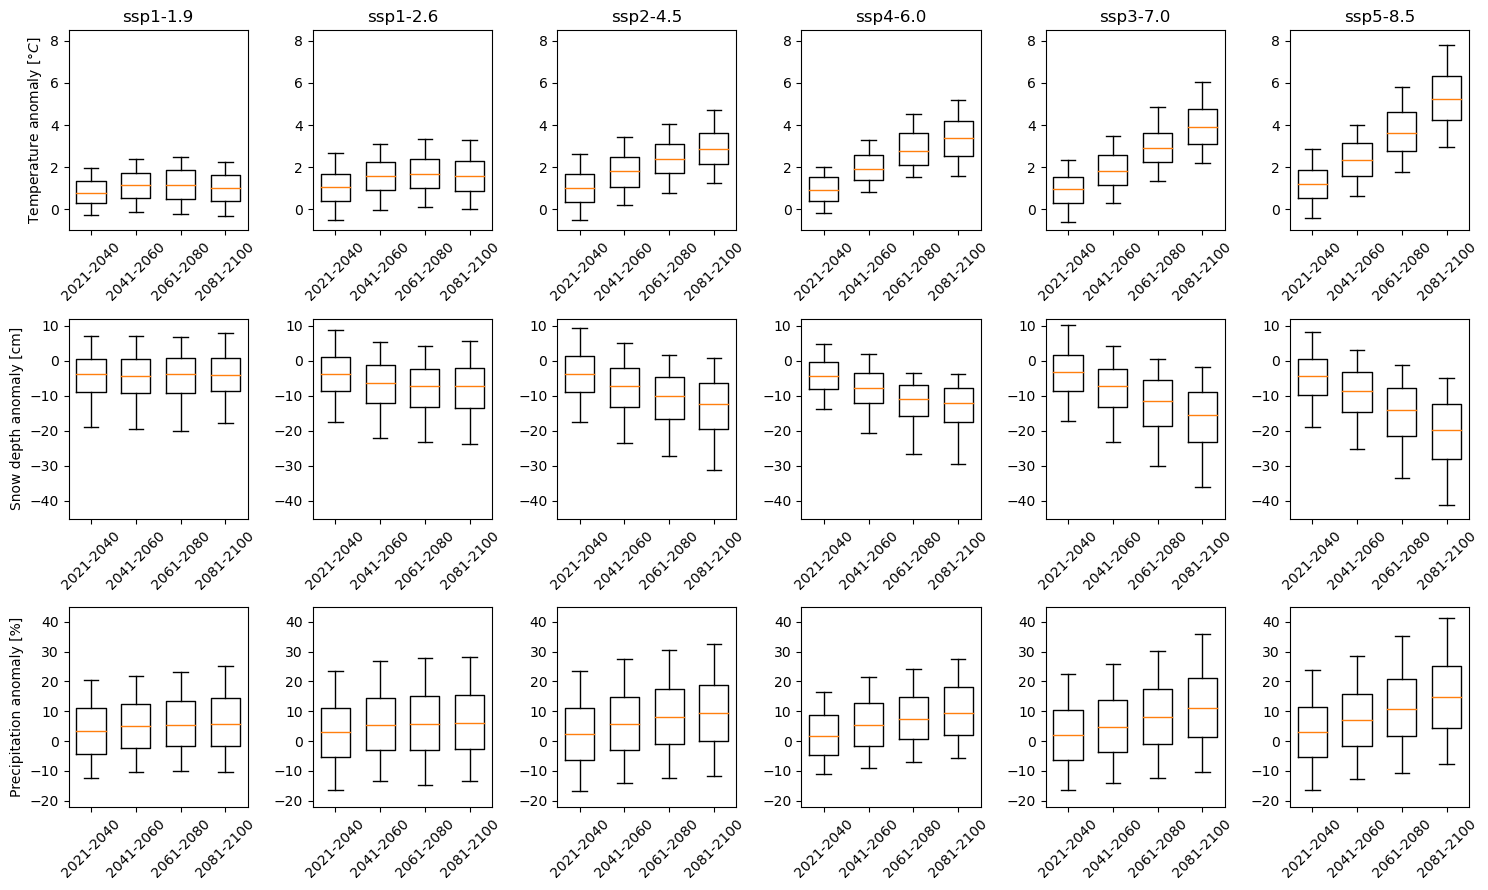

In [135]:
##### YEARLY

saveIt = 0

nrows = len(var_names)
ncols = len(ssps)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (2.5*ncols, 3*nrows))

var_names_full = ['Temperature anomaly [$\degree C$]',
                  'Snow depth anomaly [cm]',
                  'Precipitation anomaly [%]']

ylims_bottom = [-1,-45,-22]
ylims_top = [8.5,12,45]

for kk_var in range(len(var_names)):
    axes[kk_var,0].set_ylabel(var_names_full[kk_var])
    for kk_ssp in range(len(ssps)):
        axes[kk_var,kk_ssp].bxp(boxes[0][kk_var][kk_ssp], positions = np.arange(0,0.8,0.2), widths = 0.13)
        axes[kk_var,kk_ssp].set_ylim(bottom = ylims_bottom[kk_var], top = ylims_top[kk_var])
        axes[kk_var,kk_ssp].set_xticklabels(year_ranges, rotation=45)
        axes[kk_var,kk_ssp].set_xlim(left = -0.1, right = 0.7)
        
for kk_ssp in range(len(ssps)):
    axes[0,kk_ssp].set_title(ssps[kk_ssp])

plt.tight_layout()

if saveIt:
    plt.savefig('Figures2/Supplementary/cmip6_summary.png', dpi = 300, bbox_inches = 'tight')

plt.show()

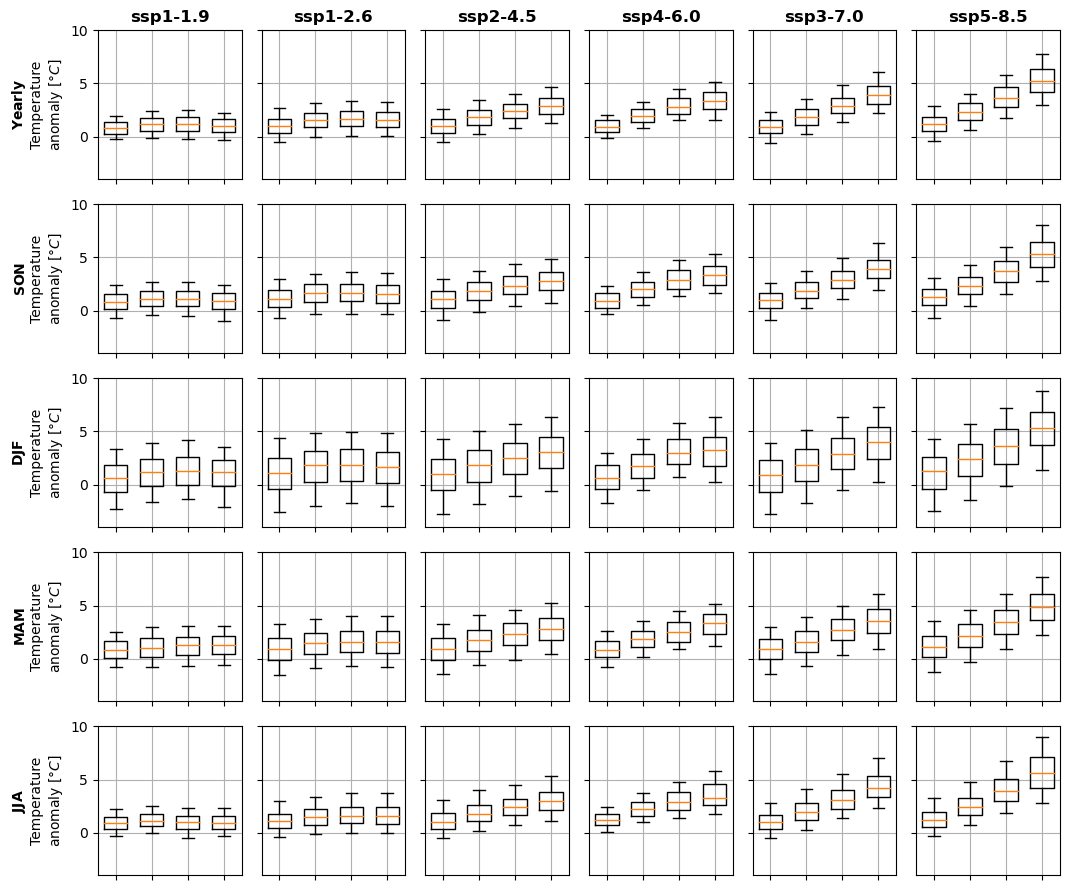

In [136]:
##### TEMP

saveIt = 0

kk_var = 0

nrows = len(time_periods)
ncols = len(ssps)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.8*ncols, 1.8*nrows))

var_names_full = ['Temperature\nanomaly [$\degree C$]',
                  'Snow depth anomaly [cm]',
                  'Precipitation anomaly [%]']

ylims_bottom = [-4]
ylims_top = [10]

for kk_period in range(len(time_periods)):
    axes[kk_period,0].set_ylabel(r'$\bf{' + time_periods_full[kk_period] + '}$\n' + var_names_full[0])

    for kk_ssp in range(len(ssps)):
        axes[kk_period,kk_ssp].bxp(boxes[kk_period][kk_var][kk_ssp], positions = np.arange(0,0.8,0.2), widths = 0.13)
        axes[kk_period,kk_ssp].set_ylim(bottom = ylims_bottom[0], top = ylims_top[0])
        axes[kk_period,kk_ssp].set_xticklabels([])
        if kk_ssp > 0:
            axes[kk_period,kk_ssp].set_yticklabels([])
        axes[kk_period,kk_ssp].set_xlim(left = -0.1, right = 0.7)
        
        axes[kk_period,kk_ssp].grid(True)
        
for kk_ssp in range(len(ssps)):
    axes[0,kk_ssp].set_title(ssps[kk_ssp], weight='bold')

plt.tight_layout()

if saveIt:
    plt.savefig('Figures2/Supplementary/cmip6_temp_summary.png', dpi = 300, bbox_inches = 'tight')

plt.show()

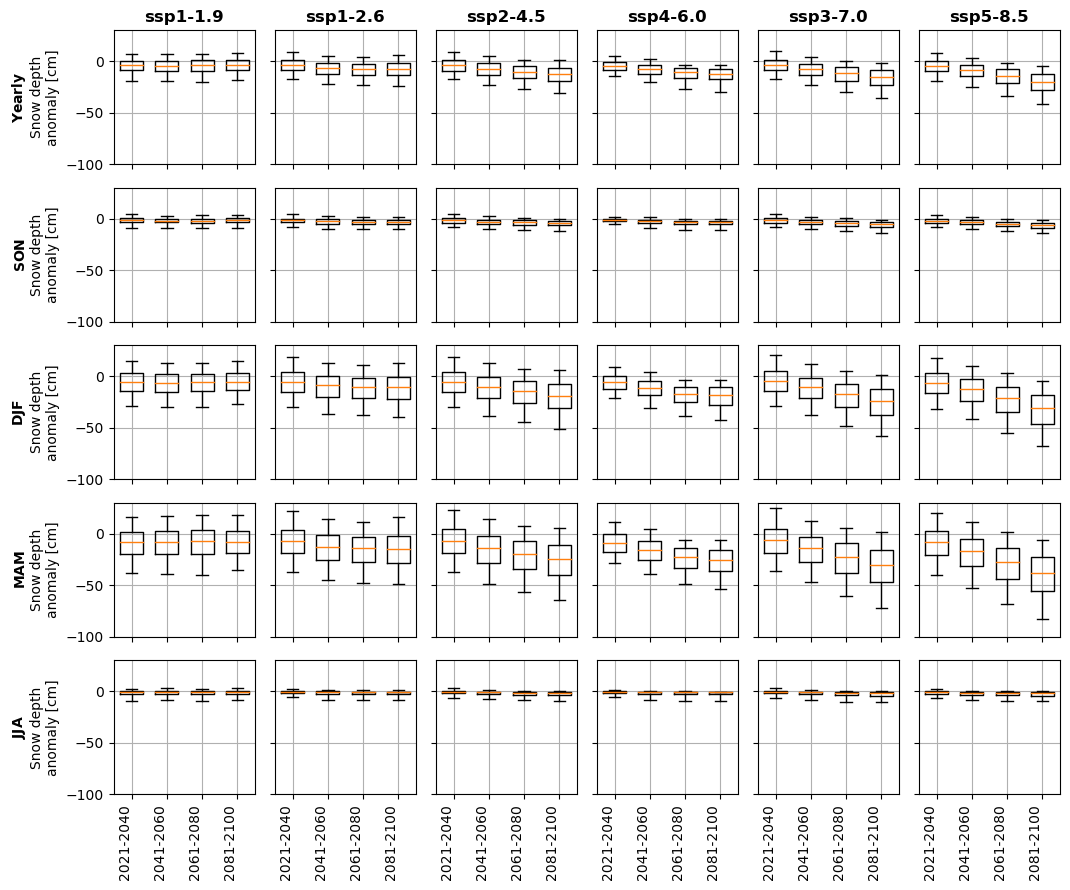

In [137]:
##### SNOW DEPTH

saveIt = 0

kk_var = 1

nrows = len(time_periods)
ncols = len(ssps)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.8*ncols, 1.8*nrows))

var_names_full = ['Temperature anomaly [$\degree C$]',
                  'Snow depth\nanomaly [cm]',
                  'Precipitation anomaly [%]']

ylims_bottom = [-100]
ylims_top = [30]

for kk_period in range(len(time_periods)):
    axes[kk_period,0].set_ylabel(r'$\bf{' + time_periods_full[kk_period] + '}$\n' + var_names_full[kk_var])

    for kk_ssp in range(len(ssps)):
        axes[kk_period,kk_ssp].bxp(boxes[kk_period][kk_var][kk_ssp], positions = np.arange(0,0.8,0.2), widths = 0.13)
        axes[kk_period,kk_ssp].set_ylim(bottom = ylims_bottom[0], top = ylims_top[0])
        axes[kk_period,kk_ssp].set_xticklabels([])
        if kk_ssp > 0:
            axes[kk_period,kk_ssp].set_yticklabels([])
        axes[kk_period,kk_ssp].set_xlim(left = -0.1, right = 0.7)
        
        axes[kk_period,kk_ssp].grid(True)
        
for kk_ssp in range(len(ssps)):
    axes[0,kk_ssp].set_title(ssps[kk_ssp], weight='bold')
    axes[kk_period,kk_ssp].set_xticklabels(year_ranges, rotation=90, ha = 'right')

plt.tight_layout()

if saveIt:
    plt.savefig('Figures2/Supplementary/cmip6_snow_summary.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
##### PRECIP

saveIt = 0

kk_var = 2

nrows = len(time_periods)
ncols = len(ssps)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.8*ncols, 1.8*nrows))

var_names_full = ['Temperature anomaly [$\degree C$]',
                  'Snow depth anomaly [cm]',
                  'Precipitation\nanomaly [%]']

ylims_bottom = [-60]
ylims_top = [80]

for kk_period in range(len(time_periods)):
    axes[kk_period,0].set_ylabel(r'$\bf{' + time_periods_full[kk_period] + '}$\n' + var_names_full[kk_var])

    for kk_ssp in range(len(ssps)):
        axes[kk_period,kk_ssp].bxp(boxes[kk_period][kk_var][kk_ssp], positions = np.arange(0,0.8,0.2), widths = 0.13)
        axes[kk_period,kk_ssp].set_ylim(bottom = ylims_bottom[0], top = ylims_top[0])
        axes[kk_period,kk_ssp].set_xticklabels([])
        if kk_ssp > 0:
            axes[kk_period,kk_ssp].set_yticklabels([])
        axes[kk_period,kk_ssp].set_xlim(left = -0.1, right = 0.7)
        
        axes[kk_period,kk_ssp].grid(True)
        
for kk_ssp in range(len(ssps)):
    axes[0,kk_ssp].set_title(ssps[kk_ssp], weight='bold')
    axes[kk_period,kk_ssp].set_xticklabels(year_ranges, rotation=90, ha = 'right')

plt.tight_layout()

if saveIt:
    plt.savefig('Figures2/Supplementary/cmip6_precip_summary.png', dpi = 300, bbox_inches = 'tight')

plt.show()